# **AN2DL First Challenge**
> ## ***Ibuprofen*** team

## 🌐 **Google Drive setup**

In [1]:
from google.colab import drive

drive.mount("/gdrive")
working_dir = "/gdrive/My Drive/Colab Notebooks/[2025-2026] AN2DL/First Challenge v4"
input_dir = working_dir

%cd $working_dir

print(f"Working at folder: {working_dir}")
print(f"Input at folder: {input_dir}")

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/[2025-2026] AN2DL/First Challenge v4
Working at folder: /gdrive/My Drive/Colab Notebooks/[2025-2026] AN2DL/First Challenge v4
Input at folder: /gdrive/My Drive/Colab Notebooks/[2025-2026] AN2DL/First Challenge v4


## 🌐 **Kaggle setup**

In [ ]:
working_dir = "/kaggle/working"
input_dir = "/kaggle/input"

---
## ⚙️ **Libraries Import**

In [2]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os
from datetime import datetime

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
# from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

PyTorch version: 2.8.0+cu126
Device: cuda


---
## ⏳ **Data loading**

### Search for data in the working directory and load it

In [3]:
dataset_name = "an2dl2526c1"

dataset_dir = f"{input_dir}/{dataset_name}"

# Check if data directory exists
if not os.path.exists(dataset_dir):
    print(f"Error: Dataset folder not found for '{dataset_name}' at expected input path: {input_dir}")
# Load data
else:
  print(f"Dataset folder found for '{dataset_name}': {dataset_dir}")

  try:
      df_features_raw = pd.read_csv(f'{dataset_dir}/pirate_pain_train.csv')
      df_labels_raw = pd.read_csv(f'{dataset_dir}/pirate_pain_train_labels.csv')
      df_test_raw = pd.read_csv(f'{dataset_dir}/pirate_pain_test.csv')
  except FileNotFoundError as e:
        print(f"Error: CSV file {e.filename} not found at expected data path: {dataset_dir}")
  print(f"Dataset '{dataset_name}' loaded successfully")

Dataset folder found for 'an2dl2526c1': /gdrive/My Drive/Colab Notebooks/[2025-2026] AN2DL/First Challenge v4/an2dl2526c1
Dataset 'an2dl2526c1' loaded successfully


---
## 🔄 **Data preprocessing**

### Drop missing values

In [4]:
# Remove rows with any missing values
df_features_raw.dropna(axis=0, how='any', inplace=True)
df_labels_raw.dropna(axis=0, how='any', inplace=True)
print("\nMissing values removed from features and labels")


Missing values removed from features and labels


### Setup

In [5]:
label_mapping = {
    'no_pain': 0,
    'low_pain': 1,
    'high_pain': 2
}
pain_survey_cols = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
body_parts_cols = ['n_legs', 'n_hands', 'n_eyes']
joint_cols = [f'joint_{i:02d}' for i in range(30)] # joint_00 to joint_29

df_features = df_features_raw.copy()
df_labels = df_labels_raw.copy()
df_labels['label'] = df_labels_raw['label'].map(label_mapping).

df_test = df_test_raw.copy()

df_features[joint_cols] = df_features[joint_cols].astype(np.float32)
df_test[joint_cols] = df_test[joint_cols].astype(np.float32)

df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 40 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  int64  
 3   pain_survey_2  105760 non-null  int64  
 4   pain_survey_3  105760 non-null  int64  
 5   pain_survey_4  105760 non-null  int64  
 6   n_legs         105760 non-null  object 
 7   n_hands        105760 non-null  object 
 8   n_eyes         105760 non-null  object 
 9   joint_00       105760 non-null  float32
 10  joint_01       105760 non-null  float32
 11  joint_02       105760 non-null  float32
 12  joint_03       105760 non-null  float32
 13  joint_04       105760 non-null  float32
 14  joint_05       105760 non-null  float32
 15  joint_06       105760 non-null  float32
 16  joint_07       105760 non-null  float32
 17  joint_08       105760 non-nul

### Feature selection - Drop constant features: `joint_30`

In [6]:
df_features.drop(columns=['joint_30'], inplace=True, errors='ignore')
df_test.drop(columns=['joint_30'], inplace=True, errors='ignore')

df_features.head()

sample_index  time  pain_survey_1  pain_survey_2  pain_survey_3  \
0             0     0              2              0              2   
1             0     1              2              2              2   
2             0     2              2              0              2   
3             0     3              2              2              2   
4             0     4              2              2              2   

   pain_survey_4 n_legs n_hands n_eyes  joint_00  ...      joint_20  \
0              1    two     two    two  1.094705  ...  6.140248e-07   
1              2    two     two    two  1.135183  ...  1.931978e-06   
2              2    two     two    two  1.080745  ...  5.730838e-07   
3              2    two     two    two  0.938017  ...  3.677486e-05   
4              2    two     two    two  1.090185  ...  2.037939e-05   

       joint_21      joint_22  joint_23      joint_24  joint_25  joint_26  \
0  3.499558e-06  1.945042e-06  0.000004  1.153299e-05  0.000004  0.017592   
1  3.976952e-07  6.765108e-07  0.000006  4.643774e-08  0.000000  0.013352   
2  1.533820e-07  1.698525e-07  0.000001  2.424536e-06  0.000003  0.016225   
3  1.006865e-05  5.511079e-07  0.000002  5.432416e-08  0.000000  0.011832   
4  4.437265e-06  1.735459e-07  0.000002  5.825366e-08  0.000007  0.005360   

   joint_27  joint_28  joint_29  
0  0.013508  0.026798  0.027815  
1  0.000000  0.013377  0.013716  
2  0.008110  0.024097  0.023105  
3  0.007450  0.028613  0.024648  
4  0.002532  0.033026  0.025328  

[5 rows x 39 columns]

### Feature selection - Drop static features uncorrelated with labels: `n_legs`, `n_hands` and `n_eyes`

In [7]:
df_features.drop(columns=body_parts_cols, inplace=True, errors='ignore')
df_test.drop(columns=body_parts_cols, inplace=True, errors='ignore')

df_features.head()

sample_index  time  pain_survey_1  pain_survey_2  pain_survey_3  \
0             0     0              2              0              2   
1             0     1              2              2              2   
2             0     2              2              0              2   
3             0     3              2              2              2   
4             0     4              2              2              2   

   pain_survey_4  joint_00  joint_01  joint_02  joint_03  ...      joint_20  \
0              1  1.094705  0.985281  1.018302  1.010385  ...  6.140248e-07   
1              2  1.135183  1.021175  0.994343  1.052364  ...  1.931978e-06   
2              2  1.080745  0.962842  1.009588  0.977169  ...  5.730838e-07   
3              2  0.938017  1.081592  0.998021  0.987283  ...  3.677486e-05   
4              2  1.090185  1.032145  1.008710  0.963658  ...  2.037939e-05   

       joint_21      joint_22  joint_23      joint_24  joint_25  joint_26  \
0  3.499558e-06  1.945042e-06  0.000004  1.153299e-05  0.000004  0.017592   
1  3.976952e-07  6.765108e-07  0.000006  4.643774e-08  0.000000  0.013352   
2  1.533820e-07  1.698525e-07  0.000001  2.424536e-06  0.000003  0.016225   
3  1.006865e-05  5.511079e-07  0.000002  5.432416e-08  0.000000  0.011832   
4  4.437265e-06  1.735459e-07  0.000002  5.825366e-08  0.000007  0.005360   

   joint_27  joint_28  joint_29  
0  0.013508  0.026798  0.027815  
1  0.000000  0.013377  0.013716  
2  0.008110  0.024097  0.023105  
3  0.007450  0.028613  0.024648  
4  0.002532  0.033026  0.025328  

[5 rows x 36 columns]

### Feature engineering - Derive more meaningful features from `joint_XX` angles measurement: the shakiness and the magnitude of movement
> Allows to consider the characteristics of the angles instead of noisy, raw angles.

In [8]:
rolling_window_size = 10

joint_vol_cols = [f'joint_{i:02d}_vol' for i in range(30)] # joint_00_vol to joint_29_vol
joint_trend_cols = [f'joint_{i:02d}_trend' for i in range(30)] # joint_00_trend to joint_29_trend

for col in joint_cols:
    # Calculate Volatility
    df_features[f'{col}_vol'] = df_features.groupby('sample_index')[col].transform(
        lambda x: x.diff().rolling(window=rolling_window_size).std()
    )
    df_test[f'{col}_vol'] = df_test.groupby('sample_index')[col].transform(
        lambda x: x.diff().rolling(window=rolling_window_size).std()
    )

    # Calculate Trend
    df_features[f'{col}_trend'] = df_features.groupby('sample_index')[col].transform(
        lambda x: x.diff().rolling(window=rolling_window_size).mean()
    )
    df_test[f'{col}_trend'] = df_test.groupby('sample_index')[col].transform(
        lambda x: x.diff().rolling(window=rolling_window_size).mean()
    )

# Drop the first 'window_size' rows of each sample (which are NaNs)
df_features.dropna(inplace=True)
df_test.dropna(inplace=True)
print("Raw joints removed.")
print("Remaining columns:", df_features.columns.tolist())

df_features.head()

Raw joints removed.
Remaining columns: ['sample_index', 'time', 'pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 'joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05', 'joint_06', 'joint_07', 'joint_08', 'joint_09', 'joint_10', 'joint_11', 'joint_12', 'joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_17', 'joint_18', 'joint_19', 'joint_20', 'joint_21', 'joint_22', 'joint_23', 'joint_24', 'joint_25', 'joint_26', 'joint_27', 'joint_28', 'joint_29', 'joint_00_vol', 'joint_00_trend', 'joint_01_vol', 'joint_01_trend', 'joint_02_vol', 'joint_02_trend', 'joint_03_vol', 'joint_03_trend', 'joint_04_vol', 'joint_04_trend', 'joint_05_vol', 'joint_05_trend', 'joint_06_vol', 'joint_06_trend', 'joint_07_vol', 'joint_07_trend', 'joint_08_vol', 'joint_08_trend', 'joint_09_vol', 'joint_09_trend', 'joint_10_vol', 'joint_10_trend', 'joint_11_vol', 'joint_11_trend', 'joint_12_vol', 'joint_12_trend', 'joint_13_vol', 'joint_13_trend', 'joint_14_vol', 'joint_14_trend'

sample_index  time  pain_survey_1  pain_survey_2  pain_survey_3  \
10             0    10              2              2              2   
11             0    11              2              2              2   
12             0    12              2              2              2   
13             0    13              2              0              2   
14             0    14              2              2              2   

    pain_survey_4  joint_00  joint_01  joint_02  joint_03  ...  joint_25_vol  \
10              2  1.100214  1.004498  0.991561  0.987526  ...      0.000004   
11              2  1.073236  1.024867  0.945640  0.937244  ...      0.000005   
12              2  1.188594  1.032610  0.953994  1.002735  ...      0.000005   
13              2  1.042035  1.015173  1.026328  0.998726  ...      0.000005   
14              2  0.963642  1.054384  0.960730  1.003397  ...      0.000005   

    joint_25_trend  joint_26_vol  joint_26_trend  joint_27_vol  \
10    3.782704e-07      0.008204        0.000573      0.007381   
11    0.000000e+00      0.008029        0.001144      0.005715   
12    3.283385e-07      0.010517       -0.001205      0.005753   
13    0.000000e+00      0.010461       -0.000765      0.006260   
14   -7.044831e-07      0.012794        0.002283      0.008282   

    joint_27_trend  joint_28_vol  joint_28_trend  joint_29_vol  joint_29_trend  
10        0.000272      0.013910        0.001363      0.009118        0.001743  
11        0.002207      0.012955        0.002644      0.007226        0.003424  
12        0.002240      0.013103        0.000654      0.008931        0.000975  
13        0.001718      0.013129       -0.000278      0.008988        0.001240  
14        0.000589      0.013387       -0.001776      0.009821        0.000049  

[5 rows x 96 columns]

### Data preparation functions

In [9]:
input_features = pain_survey_cols + joint_cols + joint_vol_cols + joint_trend_cols

In [10]:
def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [11]:
# Define a function to build sequences from the dataset
def build_sequences(df_features, df_labels=None, window=200, stride=200):
    """
    Builds sequences from time series data using a sliding window approach.

    Args:
        df_features (pd.DataFrame): DataFrame with time series features.
                                    Must contain 'sample_index' and 'time' columns,
                                    and the features specified in pain_survey_cols, joint_cols, joint_vol_cols, joint_trend_cols.
        df_labels (pd.DataFrame, optional): DataFrame with labels.
                                           Must contain 'sample_index' and 'label' columns.
                                           Defaults to None.
        window (int): The size of the sliding window.
        stride (int): The step size for the sliding window.

    Returns:
        tuple: (dataset, labels, sample_indices) - Numpy arrays of sequences,
               corresponding labels (if df_labels is provided), and original sample indices
               for each sequence.
    """
    # Sanity check to ensure the window is divisible by the stride
    assert window % stride == 0, "Window must be divisible by stride"

    # Initialise lists to store sequences, their corresponding labels, and original sample indices
    temporal_cols = input_features
    dataset = []
    labels = []
    sequence_sample_indices = [] # Store the original sample index for each sequence

    # Iterate over unique IDs in the DataFrame
    sample_indices = df_features['sample_index'].unique()
    for id in sample_indices:
        # Extract data for the current ID
        temp_df = df_features[df_features['sample_index'] == id].copy() # Use copy to avoid SettingWithCopyWarning
        temp = temp_df[temporal_cols].values


        # Retrieve the pain label for the current ID
        if df_labels is not None:
          label = df_labels[df_labels['sample_index'] == id]['label'].values[0]

        # Calculate padding length to ensure full windows
        # This padding is needed to ensure the last window captures the end of the sequence
        padding_len = window - len(temp) % window
        if padding_len > 0 and padding_len != window: # Avoid adding full window of padding if sequence length is already a multiple of window
             padding = np.zeros((padding_len, len(temporal_cols)), dtype='float32')
             temp = np.concatenate((temp, padding))

        # Build feature windows and associate them with labels and sample index
        idx = 0
        while idx + window <= len(temp):
            dataset.append(temp[idx:idx + window])
            if df_labels is not None:
              labels.append(label)
            sequence_sample_indices.append(id) # Append the original sample index
            idx += stride

    # Convert lists to numpy arrays for further processing
    dataset = np.array(dataset)
    labels = np.array(labels)
    sequence_sample_indices = np.array(sequence_sample_indices)

    if df_labels is not None:
        return dataset, labels, sequence_sample_indices
    else:
        return dataset, sequence_sample_indices

---
## 🛠️ **Model building** functions

In [12]:
def recurrent_summary(model, input_size):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers.

    This function is designed for models whose direct children are
    nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

    Args:
        model (nn.Module): The model to analyze.
        input_size (tuple): Shape of the input tensor (e.g., (seq_len, features)).
    """

    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""
        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"
        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create a dummy input tensor with batch_size=1
    dummy_input = torch.randn(1, *input_size).to(device)

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            model(dummy_input)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---

    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

In [13]:
class RecurrentClassifier(nn.Module):
    """
    Generic RNN classifier (RNN, LSTM, GRU).
    Uses the last hidden state for classification.
    """
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',        # 'RNN', 'LSTM', or 'GRU'
            bidirectional=False,
            dropout_rate=0.2
            ):
        super().__init__()

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        # Map string name to PyTorch RNN class
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[rnn_type]

        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0

        # Create the recurrent layer
        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,       # Input shape: (batch, seq_len, features)
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        # Calculate input size for the final classifier
        if self.bidirectional:
            classifier_input_size = hidden_size * 2 # Concat fwd + bwd
        else:
            classifier_input_size = hidden_size

        # Final classification layer
        self.classifier = nn.Linear(classifier_input_size, num_classes)

    def forward(self, x):
        """
        x shape: (batch_size, seq_length, input_size)
        """

        # rnn_out shape: (batch_size, seq_len, hidden_size * num_directions)
        rnn_out, hidden = self.rnn(x)

        # LSTM returns (h_n, c_n), we only need h_n
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]

        # hidden shape: (num_layers * num_directions, batch_size, hidden_size)

        if self.bidirectional:
            # Reshape to (num_layers, 2, batch_size, hidden_size)
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)

            # Concat last fwd (hidden[-1, 0, ...]) and bwd (hidden[-1, 1, ...])
            # Final shape: (batch_size, hidden_size * 2)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            # Take the last layer's hidden state
            # Final shape: (batch_size, hidden_size)
            hidden_to_classify = hidden[-1]

        # Get logits
        logits = self.classifier(hidden_to_classify)
        return logits

## 🧠 **Model training** functions

In [14]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0, max_grad_norm=1.0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization
        max_grad_norm (float): max gradient for gradient clipping

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            inputs = inputs.to(torch.float32)
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        # Unscale the gradients, then clip them
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
        # Apply gradients and update weights
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='micro'
    )

    return epoch_loss, epoch_f1

In [15]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                inputs = inputs.to(torch.float32)
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='micro'
    )

    return epoch_loss, epoch_accuracy

In [16]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [17]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

---
## 🔀 **K-Shuffle-Split Cross Validation** functions

In [18]:
def calculate_and_plot_confusion_matrix(model, data_loader, device, label_mapping, split_name, experiment_name):
    """
    Calculates and plots the confusion matrix.

    Args:
        model (nn.Module): The trained model.
        data_loader (DataLoader): DataLoader for the dataset to evaluate.
        device (torch.device): Computing device.
        label_mapping (dict): Mapping from label strings to integers.
        split_name (str): Name of the split (e.g., 'validation_split_0').
        experiment_name (str): The name of the experiment directory to save the plot.
    """
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                inputs = inputs.to(torch.float32)
                logits = model(inputs)
                predictions = logits.argmax(dim=1)

            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    cm = confusion_matrix(np.concatenate(all_targets), np.concatenate(all_predictions))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {split_name}')

    # Save the plot in the experiment directory
    plot_filename = f'confusion_matrix_{split_name.replace(" ", "_")}.png'
    plot_path = os.path.join("models", experiment_name, plot_filename)
    plt.savefig(plot_path)
    print(f"\nSaved confusion matrix plot to: '{plot_path}'")

    plt.show()


def k_shuffle_split_cross_validation_round_rnn(df, df_labels, epochs, criterion, device,
                            k, test_size, batch_size, hidden_layers, hidden_size, learning_rate, dropout_rate,
                            window_size, stride, rnn_type, bidirectional,
                            l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
                            restore_best_weights=True, writer=None, verbose=10, seed=42, experiment_name=""):
    """
    Perform K-fold shuffle split cross-validation with user-based splitting for time series data.

    Args:
        df: DataFrame with columns ['sample_index', 'time', *pain_survey_cols, *joint_cols]
        df_labels: DataFrame with columns ['label']
        epochs: Number of training epochs
        criterion: Loss function
        device: torch.device for computation
        k: Number of cross-validation splits
        test_size: Number of users or fraction of users for validation set
        batch_size: Batch size for training
        hidden_layers: Number of recurrent layers
        hidden_size: Hidden state dimensionality
        learning_rate: Learning rate for optimizer
        dropout_rate: Dropout rate
        window_size: Length of sliding windows
        stride: Step size for sliding windows
        rnn_type: Type of RNN ('RNN', 'LSTM', 'GRU')
        bidirectional: Whether to use bidirectional RNN
        l1_lambda: L1 regularization coefficient (if used)
        l2_lambda: L2 regularization coefficient (weight_decay)
        patience: Early stopping patience
        evaluation_metric: Metric to monitor for early stopping
        mode: 'max' or 'min' for evaluation metric
        restore_best_weights: Whether to restore best weights after training
        writer: TensorBoard writer
        verbose: Verbosity level
        seed: Random seed
        experiment_name: Name for experiment logging

    Returns:
        fold_losses: Dict with validation losses for each split
        fold_metrics: Dict with validation F1 scores for each split
        best_scores: Dict with best F1 score for each split plus mean and std
        best_model: Best model among the K-Shuffle-Splits
        best_experiment_name: Experiment name of the best model
    """

    # Initialize best model tracking variables
    best_model = None
    best_experiment_name = None
    best_performance = float('-inf')


    # Initialise containers for results across all splits
    fold_losses = {}
    fold_metrics = {}
    best_scores = {}

    # Get model architecture parameters
    in_features = len(input_features)
    num_classes = len(df_labels['label'].unique())

    # Initialise model architecture
    model = RecurrentClassifier(
        input_size=in_features,
        hidden_size=hidden_size,
        num_layers=hidden_layers,
        num_classes=num_classes,
        dropout_rate=dropout_rate,
        bidirectional=bidirectional,
        rnn_type=rnn_type
    ).to(device)

    # Store initial weights to reset model for each split
    initial_state = copy.deepcopy(model.state_dict())

    # Iterate through K random splits
    for split_idx in range(k):

        if verbose > 0:
            print(f"Split {split_idx+1}/{k}")

        # Randomly split sample_indices for training and validation
        train_users, val_users, train_labels, val_labels = train_test_split(
            df_labels['sample_index'], df_labels['label'],
            test_size=test_size,
            random_state=SEED+split_idx, # enforce randomness for each split
            stratify=df_labels['label'] # stratify by pain labels frequency
        )

        # Split the dataset into training and validation sets based on sample indices
        df_train = df[df['sample_index'].isin(train_users)].copy()
        df_val = df[df['sample_index'].isin(val_users)].copy()
        df_train_labels = df_labels[df_labels['sample_index'].isin(train_users)].copy()
        df_val_labels = df_labels[df_labels['sample_index'].isin(val_users)].copy()

        if verbose > 0:
            print(f"  Training set shape: {df_train.shape}")
            print(f"  Validation set shape: {df_val.shape}")

        # Normalise features using training set statistics
        to_norm_features = [*joint_cols, *joint_vol_cols, *joint_trend_cols]
        train_max = df_train[to_norm_features].max()
        train_min = df_train[to_norm_features].min()
        df_train[to_norm_features] = (df_train[to_norm_features] - train_min) / (train_max - train_min + 1e-8)
        df_val[to_norm_features] = (df_val[to_norm_features] - train_min) / (train_max - train_min + 1e-8)

        # Build sequences using the existing build_sequences function
        X_train, y_train, _ = build_sequences(df_train, df_train_labels, window=window_size, stride=stride)
        X_val, y_val, _ = build_sequences(df_val, df_val_labels, window=window_size, stride=stride)

        if verbose > 0:
            print(f"  Training sequences shape: {X_train.shape}")
            print(f"  Validation sequences shape: {X_val.shape}")

        # Create PyTorch datasets
        train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
        val_ds   = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))

        # Create data loaders
        train_loader = make_loader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
        val_loader   = make_loader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)

        # Reset model to initial weights for fair comparison across splits
        model.load_state_dict(initial_state)

        # Define optimizer with L2 regularization
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

        # Enable mixed precision training for GPU acceleration
        split_scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

        # Create directory for model checkpoints and normalization stats
        split_experiment_name = f"{experiment_name}/split_{split_idx}"
        os.makedirs(f"models/{split_experiment_name}", exist_ok=True)

        # Save train_max and train_min for this split in a single file
        norm_stats_df = pd.DataFrame({'train_max': train_max, 'train_min': train_min})
        norm_stats_df.to_csv(f"models/{split_experiment_name}/normalization_stats.csv")


        # Train model on current split
        model, training_history = fit(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=epochs,
            criterion=criterion,
            optimizer=optimizer,
            scaler=split_scaler,
            device=device,
            writer=writer,
            patience=patience,
            verbose=verbose,
            l1_lambda=l1_lambda,
            evaluation_metric=evaluation_metric,
            mode=mode,
            restore_best_weights=restore_best_weights,
            experiment_name=split_experiment_name
        )

        # Store results for this split
        fold_losses[f"split_{split_idx}"] = training_history['val_loss']
        fold_metrics[f"split_{split_idx}"] = training_history['val_f1']
        best_scores[f"split_{split_idx}"] = max(training_history['val_f1'])

        # Calculate and plot confusion matrix for the validation set of this split
        calculate_and_plot_confusion_matrix(model, val_loader, device, label_mapping, f'Validation Split {split_idx+1}', split_experiment_name)


        # Update best model if current performance is superior
        if best_scores[f"split_{split_idx}"] > best_performance:
            best_model = model
            best_experiment_name = split_experiment_name
            best_performance = best_scores[f"split_{split_idx}"]


    # Compute mean and standard deviation of best scores across splits
    best_scores["mean"] = np.mean([best_scores[k] for k in best_scores.keys() if k.startswith("split_")])
    best_scores["std"] = np.std([best_scores[k] for k in best_scores.keys() if k.startswith("split_")])

    if verbose > 0:
        print(f"Best score: {best_scores['mean']:.4f}±{best_scores['std']:.4f}")

    return fold_losses, fold_metrics, best_scores, best_model, best_experiment_name

---
##  🎛️ **Hyperparameter tuning** functions

In [19]:
def grid_search_cv_rnn(df, df_labels, param_grid, fixed_params, cv_params, verbose=True):
    """
    Execute grid search with K-shuffle-split cross-validation for RNN models on time series data.

    Args:
        df: DataFrame with columns ['sample_index', *pain_survey_ohenceded_cols, *joint_cols]
        param_grid: Dict of parameters to test, e.g. {'batch_size': [16, 32], 'rnn_type': ['LSTM', 'GRU']}
        fixed_params: Dict of fixed hyperparameters (hidden_size, learning_rate, window_size, stride, etc.)
        cv_params: Dict of CV settings (epochs, k, patience, criterion, scaler, device, etc.)
        verbose: Print progress for each configuration

    Returns:
        results: Dict with scores for each configuration
        best_config: Dict with best hyperparameter combination
        best_score: Best mean F1 score achieved
        best_normalization_stats: DataFrame with train_max and train_min for the best split
    """
    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    combinations = list(product(*param_values))

    results = {}
    best_score = -np.inf
    best_config = None
    best_experiment_name = ""


    total = len(combinations)

    for idx, combo in enumerate(combinations, 1):
        # Create current configuration dict
        current_config = dict(zip(param_names, combo))
        config_str = "_".join([f"{k}_{v}" for k, v in current_config.items()])

        if verbose:
            print(f"\nConfiguration {idx}/{total}:")
            for param, value in current_config.items():
                print(f"  {param}: {value}")

        # Merge current config with fixed parameters
        run_params = {**fixed_params, **current_config}

        # Execute cross-validation
        _, _, fold_scores, _, best_split_experiment = k_shuffle_split_cross_validation_round_rnn(
            df=df,
            df_labels=df_labels,
            experiment_name=config_str,
            **run_params,
            **cv_params
        )

        # Store results
        results[config_str] = fold_scores

        # Track best configuration
        if fold_scores["mean"] > best_score:
            best_score = fold_scores["mean"]
            best_config = current_config.copy()
            best_experiment_name = best_split_experiment
            if verbose:
                print("🎉🎉🎉  NEW BEST SCORE! 🎉🎉🎉")

        if verbose:
            print(f"  Experiment (split): {best_split_experiment}")
            print(f"  F1 Score: {fold_scores['mean']:.4f}±{fold_scores['std']:.4f}")

    return results, best_config, best_score, best_experiment_name


def plot_top_configurations_rnn(results, k_splits, top_n=5, figsize=(14, 7)):
    """
    Visualise top N RNN configurations with boxplots of F1 scores across CV splits.

    Args:
        results: Dict of results from grid_search_cv_rnn
        k_splits: Number of CV splits used
        top_n: Number of top configurations to display
        figsize: Figure size tuple
    """
    # Sort by mean score
    config_scores = {name: data['mean'] for name, data in results.items()}
    sorted_configs = sorted(config_scores.items(), key=lambda x: x[1], reverse=True)

    # Select top N
    top_configs = sorted_configs[:min(top_n, len(sorted_configs))]

    # Prepare boxplot data
    boxplot_data = []
    labels = []

    # Define a dictionary for replacements, ordered to handle prefixes correctly
    replacements = {
        'batch_size_': 'BS=',
        'learning_rate_': '\nLR=',
        'hidden_layers_': '\nHL=',
        'hidden_size_': '\nHS=',
        'dropout_rate_': '\nDR=',
        'window_size_': '\nWS=',
        'stride_': '\nSTR=',
        'rnn_type_': '\nRNN=',
        'bidirectional_': '\nBIDIR=',
        'l1_lambda_': '\nL1=',
        'l2_lambda_': '\nL2='
    }

    # Replacements for separators
    separator_replacements = {
        '_learning_rate_': '\nLR=',
        '_hidden_layers_': '\nHL=',
        '_hidden_size_': '\nHS=',
        '_dropout_rate_': '\nDR=',
        '_window_size_': '\nWS=',
        '_stride_': '\nSTR=',
        '_rnn_type_': '\nRNN=',
        '_bidirectional_': '\nBIDIR=',
        '_l1_lambda_': '\nL1=',
        '_l2_lambda_': '\nL2=',
        '_': ''
    }

    for config_name, mean_score in top_configs:
        # Extract best score from each split (auto-detect number of splits)
        split_scores = []
        for i in range(k_splits):
            if f'split_{i}' in results[config_name]:
                split_scores.append(results[config_name][f'split_{i}'])
        boxplot_data.append(split_scores)

        # Verify we have the expected number of splits
        if len(split_scores) != k_splits:
            print(f"Warning: Config {config_name} has {len(split_scores)} splits, expected {k_splits}")

        # Create readable label using the replacements dictionary
        readable_label = config_name
        for old, new in replacements.items():
            readable_label = readable_label.replace(old, new)

        # Apply separator replacements
        for old, new in separator_replacements.items():
             readable_label = readable_label.replace(old, new)

        labels.append(f"{readable_label}\n(μ={mean_score:.3f})")

    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True,
                    showmeans=True, meanline=True)

    # Styling
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)

    # Highlight best configuration
    ax.get_xticklabels()[0].set_fontweight('bold')

    ax.set_ylabel('F1 Score')
    ax.set_xlabel('Configuration')
    ax.set_title(f'Top {len(top_configs)} RNN Configurations - F1 Score Distribution Across {k_splits} Splits')
    ax.grid(alpha=0.3, axis='y')

    plt.xticks(rotation=0, ha='center')
    plt.tight_layout()
    plt.show()
    plt.savefig('top_configurations.png')

---
## 🚀 **1. Run an overfitting baseline...**
> Training F1 scores are (almost) perfect. </br>
> `Best score: 0.9504±0.0184`. Good validation starting point.

In [46]:
# @title Configuration
# Cross-validation
K = 3                    # Number of splits (5 and 10 are considered good values)
VAL_SIZE = 99            # Size or fraction for validation splits

# Training
EPOCHS = 10000           # Maximum epochs (increase to improve performance)
PATIENCE = 100           # Early stopping patience (increase to improve performance)
VERBOSE = 10             # Print frequency

# Optimisation
LEARNING_RATE = 1e-3     # Learning rate
BATCH_SIZE = 32          # Batch size
WINDOW_SIZE = 50         # Input window size
STRIDE = 10               # Input stride

# Architecture
HIDDEN_LAYERS = 2        # Hidden layers
HIDDEN_SIZE = 64         # Neurons per layer
RNN_TYPE = 'LSTM'        # Type of RNN architecture
BIDIRECTIONAL = True     # Bidirectional RNN

# Regularisation
DROPOUT_RATE = 0         # Dropout probability
L1_LAMBDA = 0            # L1 penalty
L2_LAMBDA = 0            # L2 penalty

# Loss function
ALPHA = 0.1              # Smoothing applied on the loss (between 0 and 1)
CLASS_WEIGHTS_LIST = [0.43, 2.32, 4.0]
CLASS_WEIGHTS = torch.tensor(CLASS_WEIGHTS_LIST, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=ALPHA, weight=CLASS_WEIGHTS)


# Experiment name
base_experiment_name = f'{str(datetime.now())}_vol-trend_lstm_baseline'
print(f"Experiment: {base_experiment_name}")

# Setup TensorBoard writer
writer = SummaryWriter("./"+logs_dir+"/"+base_experiment_name)

# Initialize best model tracking variables
best_model = None
best_experiment_name = None
best_performance = float('-inf')

Split 1/3
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.1883, F1 Score=0.4533 | Val: Loss=1.3588, F1 Score=0.5455
Epoch  10/10000 | Train: Loss=0.8396, F1 Score=0.8526 | Val: Loss=1.2400, F1 Score=0.7539
Epoch  20/10000 | Train: Loss=0.7084, F1 Score=0.9071 | Val: Loss=1.0980, F1 Score=0.8549
Epoch  30/10000 | Train: Loss=0.6394, F1 Score=0.9469 | Val: Loss=1.1356, F1 Score=0.8760
Epoch  40/10000 | Train: Loss=0.6128, F1 Score=0.9712 | Val: Loss=1.0844, F1 Score=0.8861
Epoch  50/10000 | Train: Loss=0.6045, F1 Score=0.9748 | Val: Loss=1.0605, F1 Score=0.9091
Epoch  60/10000 | Train: Loss=0.6025, F1 Score=0.9786 | Val: Loss=1.1033, F1 Score=0.8843
Epoch  70/10000 | Train: Loss=0.5907, F1 Score=0.9812 | Val: Loss=1.1351, F1 Score=0.8907
Epoch  80/10000 | Train: Loss=0.5748, F1 Score=0.9867 | Val: Loss=1.1249, F1 Score=0.87

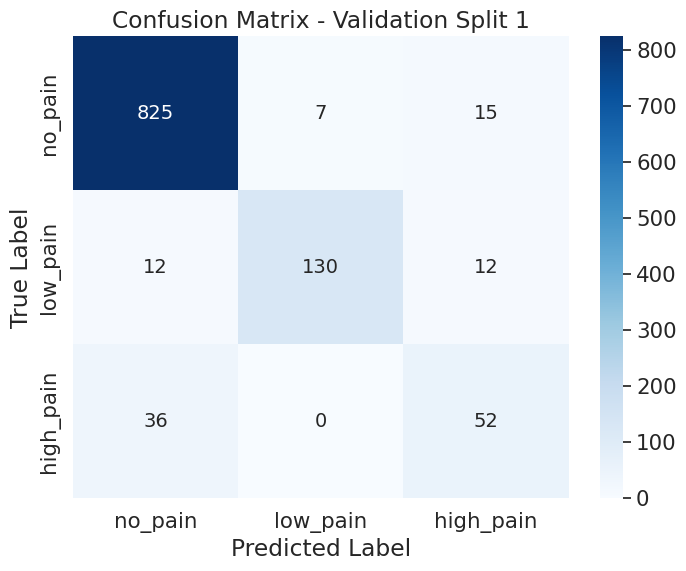

Split 2/3
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.1958, F1 Score=0.4102 | Val: Loss=1.3255, F1 Score=0.4004
Epoch  10/10000 | Train: Loss=0.8380, F1 Score=0.8164 | Val: Loss=1.0023, F1 Score=0.8843
Epoch  20/10000 | Train: Loss=0.7054, F1 Score=0.9036 | Val: Loss=1.1363, F1 Score=0.8779
Epoch  30/10000 | Train: Loss=0.6475, F1 Score=0.9361 | Val: Loss=1.0465, F1 Score=0.9265
Epoch  40/10000 | Train: Loss=0.6312, F1 Score=0.9536 | Val: Loss=1.0245, F1 Score=0.8650
Epoch  50/10000 | Train: Loss=0.6192, F1 Score=0.9654 | Val: Loss=1.0053, F1 Score=0.9275
Epoch  60/10000 | Train: Loss=0.5972, F1 Score=0.9725 | Val: Loss=0.9626, F1 Score=0.9412
Epoch  70/10000 | Train: Loss=0.5973, F1 Score=0.9798 | Val: Loss=0.9654, F1 Score=0.9311
Epoch  80/10000 | Train: Loss=0.6021, F1 Score=0.9786 | Val: Loss=0.9733, F1 Score=0.93

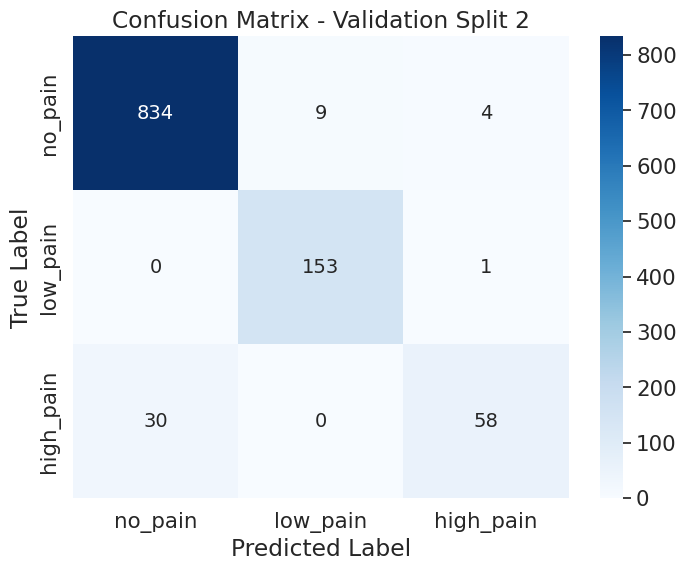

Split 3/3
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.1896, F1 Score=0.4377 | Val: Loss=1.2755, F1 Score=0.7511
Epoch  10/10000 | Train: Loss=0.7993, F1 Score=0.8381 | Val: Loss=1.0320, F1 Score=0.8880
Epoch  20/10000 | Train: Loss=0.6930, F1 Score=0.9046 | Val: Loss=1.1316, F1 Score=0.8384
Epoch  30/10000 | Train: Loss=0.6406, F1 Score=0.9410 | Val: Loss=1.0047, F1 Score=0.9192
Epoch  40/10000 | Train: Loss=0.6328, F1 Score=0.9507 | Val: Loss=0.9609, F1 Score=0.9348
Epoch  50/10000 | Train: Loss=0.6342, F1 Score=0.9571 | Val: Loss=1.0687, F1 Score=0.9017
Epoch  60/10000 | Train: Loss=0.5946, F1 Score=0.9743 | Val: Loss=0.9537, F1 Score=0.9412
Epoch  70/10000 | Train: Loss=0.5946, F1 Score=0.9782 | Val: Loss=1.0643, F1 Score=0.8944
Epoch  80/10000 | Train: Loss=0.5774, F1 Score=0.9888 | Val: Loss=1.1118, F1 Score=0.88

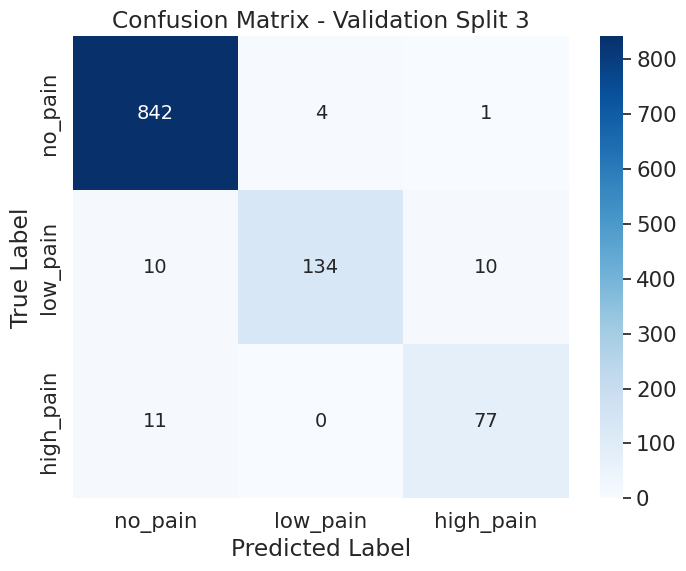

Best score: 0.9504±0.0184
CPU times: user 49min 45s, sys: 4min 15s, total: 54min 1s
Wall time: 34min 26s


In [47]:
# @title Run
%%time
# Execute K-fold cross-validation with baseline configuration
losses, metrics, best_scores, best_model, best_experiment_name = k_shuffle_split_cross_validation_round_rnn(
    df=df_features,
    df_labels=df_labels,
    epochs=EPOCHS,
    criterion=criterion,
    device=device,
    k=K,
    batch_size=BATCH_SIZE,
    hidden_layers=HIDDEN_LAYERS,
    hidden_size=HIDDEN_SIZE,
    learning_rate=LEARNING_RATE,
    dropout_rate=DROPOUT_RATE,
    l1_lambda=L1_LAMBDA,
    l2_lambda=L2_LAMBDA,
    verbose=VERBOSE,
    patience=PATIENCE,
    seed=SEED,
    experiment_name=base_experiment_name,
    test_size=VAL_SIZE,
    window_size=WINDOW_SIZE,
    stride=STRIDE,
    rnn_type=RNN_TYPE,
    bidirectional=BIDIRECTIONAL,
    writer=writer
)

final_best_params = {
  'k': K,
  'test_size': VAL_SIZE,
  'epochs': EPOCHS,
  'patience': PATIENCE,
  'verbose': 0,
  'learning_rate': LEARNING_RATE,
  'batch_size': BATCH_SIZE,
  'window_size': WINDOW_SIZE,
  'stride': STRIDE,
  'hidden_layers': HIDDEN_LAYERS,
  'hidden_size': HIDDEN_SIZE,
  'rnn_type': RNN_TYPE,
  'bidirectional': BIDIRECTIONAL,
  'dropout_rate': DROPOUT_RATE,
  'l1_lambda': L1_LAMBDA,
  'l2_lambda': L2_LAMBDA,
  'criterion': criterion,
  'device': device,
  'seed': SEED
}

print(f"Best experiment split: {best_experiment_name}")

In [48]:
best_experiment_name

'2025-11-13 09:13:06.779021_vol-trend_lstm_baseline/split_2'

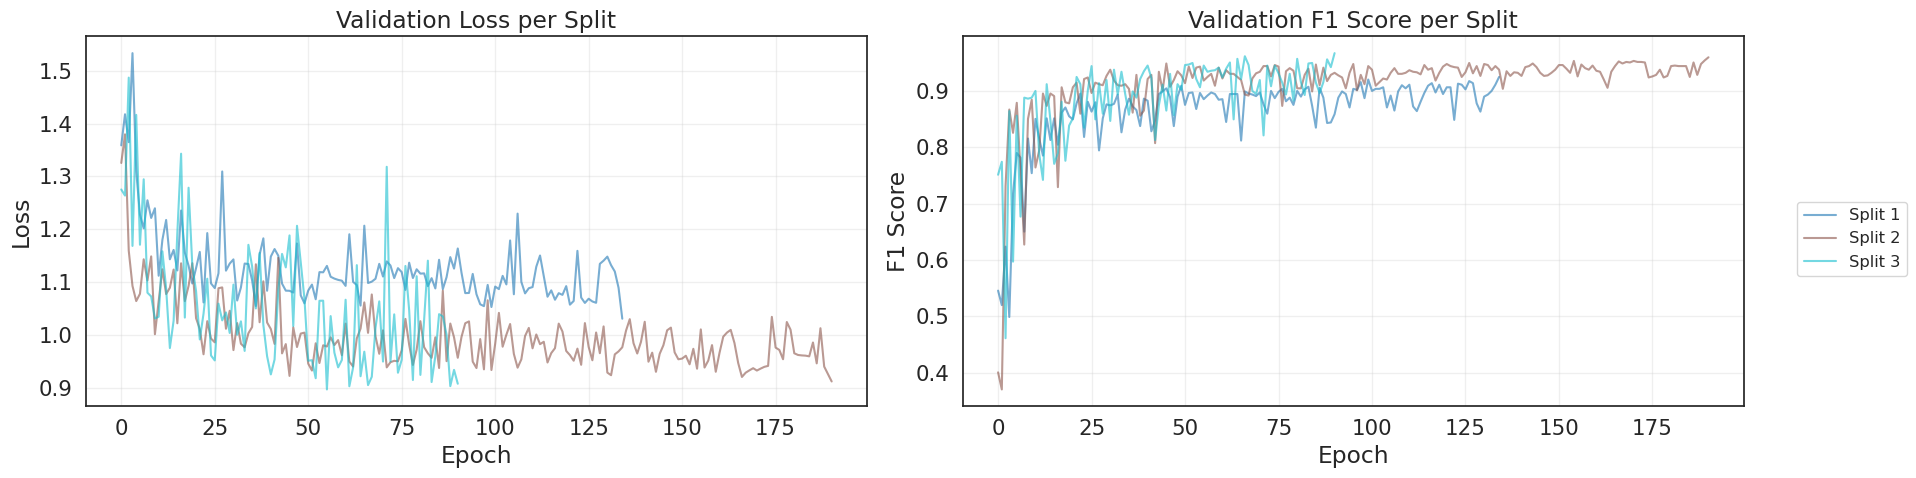

In [49]:
# @title Plot history
# Create figure with two subplots sharing x axis
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5), sharex=True)

# Color palette for K splits
colors = plt.cm.get_cmap('tab10', K)

# Plot validation loss for each split
for split in range(K):
    axes[0].plot(losses[f'split_{split}'][:-PATIENCE], label=f'Split {split+1}',
                 color=colors(split), alpha=0.6)
axes[0].set_title('Validation Loss per Split')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].grid(alpha=0.3)

# Plot validation F1 score for each split
for split in range(K):
    axes[1].plot(metrics[f'split_{split}'][:-PATIENCE], label=f'Split {split+1}',
                 color=colors(split), alpha=0.6)
axes[1].set_title('Validation F1 Score per Split')
axes[1].set_ylabel('F1 Score')
axes[1].set_xlabel('Epoch')
axes[1].grid(alpha=0.3)

# Add shared legend on the right
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(right=0.975)
plt.savefig(f'models/{base_experiment_name}/validation_f1-score_history.png')
plt.show()

---
## 🚀 **2. Run with regularization...**
> Dropout rate to 0.2. L2-lambda to 1e-4. </br>
> `Best score: 0.9559±0.0124`. No significant changes in validation scores.

In [62]:
# @title Configuration
# Cross-validation
K = 3                    # Number of splits (5 and 10 are considered good values)
VAL_SIZE = 99            # Size or fraction for validation splits

# Training
EPOCHS = 10000           # Maximum epochs (increase to improve performance)
PATIENCE = 100           # Early stopping patience (increase to improve performance)
VERBOSE = 10             # Print frequency

# Optimisation
LEARNING_RATE = 1e-3     # Learning rate
BATCH_SIZE = 32          # Batch size
WINDOW_SIZE = 50         # Input window size
STRIDE = 10               # Input stride

# Architecture
HIDDEN_LAYERS = 2        # Hidden layers
HIDDEN_SIZE = 64         # Neurons per layer
RNN_TYPE = 'LSTM'        # Type of RNN architecture
BIDIRECTIONAL = True     # Bidirectional RNN

# Regularisation
DROPOUT_RATE = 0.2       # Dropout probability
L1_LAMBDA = 0            # L1 penalty
L2_LAMBDA = 1e-4         # L2 penalty

# Loss function
ALPHA = 0.1              # Smoothing applied on the loss (between 0 and 1)
CLASS_WEIGHTS_LIST = [0.43, 2.32, 4.0]
CLASS_WEIGHTS = torch.tensor(CLASS_WEIGHTS_LIST, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=ALPHA, weight=CLASS_WEIGHTS)


# Experiment name
base_experiment_name = f'{str(datetime.now())}_vol-trend_lstm_v2_regularization'
print(f"Experiment: {base_experiment_name}")

# Setup TensorBoard writer
writer = SummaryWriter("./"+logs_dir+"/"+base_experiment_name)

# Initialize best model tracking variables
best_model = None
best_experiment_name = None
best_performance = float('-inf')

Experiment: 2025-11-13 10:33:17.139525_vol-trend_lstm_v2_regularization


Split 1/3
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.1945, F1 Score=0.3628 | Val: Loss=1.3263, F1 Score=0.7723
Epoch  10/10000 | Train: Loss=0.8259, F1 Score=0.8567 | Val: Loss=1.2654, F1 Score=0.7824
Epoch  20/10000 | Train: Loss=0.7083, F1 Score=0.9177 | Val: Loss=1.2477, F1 Score=0.8228
Epoch  30/10000 | Train: Loss=0.6577, F1 Score=0.9440 | Val: Loss=1.1876, F1 Score=0.8604
Epoch  40/10000 | Train: Loss=0.6304, F1 Score=0.9520 | Val: Loss=1.0796, F1 Score=0.8926
Epoch  50/10000 | Train: Loss=0.6207, F1 Score=0.9710 | Val: Loss=1.1399, F1 Score=0.8834
Epoch  60/10000 | Train: Loss=0.6123, F1 Score=0.9725 | Val: Loss=1.0477, F1 Score=0.9073
Epoch  70/10000 | Train: Loss=0.5883, F1 Score=0.9841 | Val: Loss=1.1476, F1 Score=0.8806
Epoch  80/10000 | Train: Loss=0.5899, F1 Score=0.9841 | Val: Loss=1.0421, F1 Score=0.91

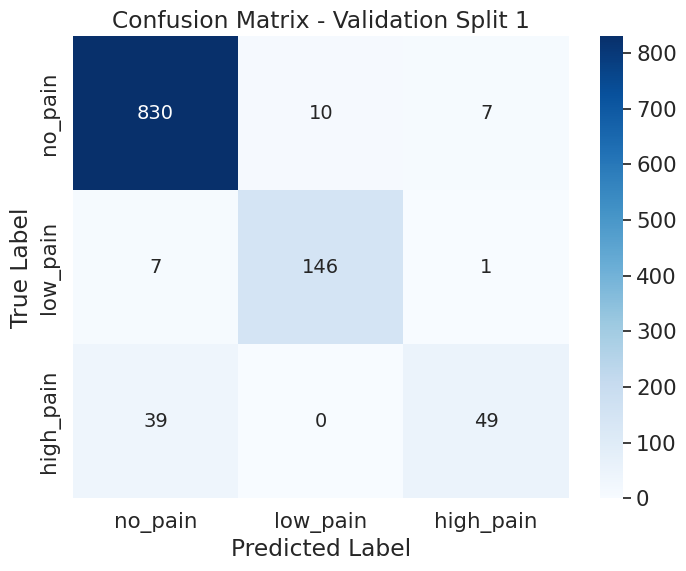

Split 2/3
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.1909, F1 Score=0.4492 | Val: Loss=1.2793, F1 Score=0.7961
Epoch  10/10000 | Train: Loss=0.8411, F1 Score=0.7994 | Val: Loss=1.1584, F1 Score=0.5583
Epoch  20/10000 | Train: Loss=0.7405, F1 Score=0.8976 | Val: Loss=1.1356, F1 Score=0.7906
Epoch  30/10000 | Train: Loss=0.6523, F1 Score=0.9401 | Val: Loss=1.0637, F1 Score=0.8972
Epoch  40/10000 | Train: Loss=0.6200, F1 Score=0.9586 | Val: Loss=1.0482, F1 Score=0.9017
Epoch  50/10000 | Train: Loss=0.6086, F1 Score=0.9638 | Val: Loss=1.0081, F1 Score=0.9339
Epoch  60/10000 | Train: Loss=0.6021, F1 Score=0.9762 | Val: Loss=1.1038, F1 Score=0.8659
Epoch  70/10000 | Train: Loss=0.5994, F1 Score=0.9774 | Val: Loss=1.0664, F1 Score=0.9073
Epoch  80/10000 | Train: Loss=0.5874, F1 Score=0.9829 | Val: Loss=1.0620, F1 Score=0.90

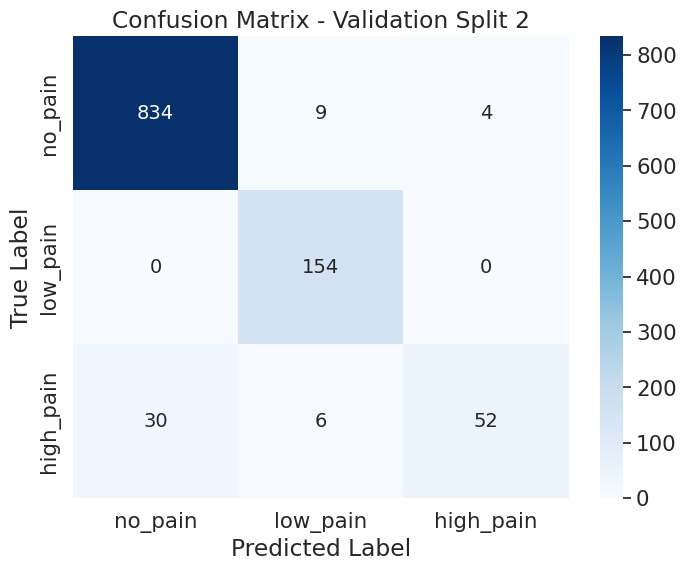

Split 3/3
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2004, F1 Score=0.3955 | Val: Loss=1.6934, F1 Score=0.2185
Epoch  10/10000 | Train: Loss=0.8576, F1 Score=0.8027 | Val: Loss=1.1944, F1 Score=0.8724
Epoch  20/10000 | Train: Loss=0.7618, F1 Score=0.8581 | Val: Loss=1.1151, F1 Score=0.7328
Epoch  30/10000 | Train: Loss=0.6948, F1 Score=0.9233 | Val: Loss=1.0112, F1 Score=0.8907
Epoch  40/10000 | Train: Loss=0.6337, F1 Score=0.9583 | Val: Loss=1.0527, F1 Score=0.9073
Epoch  50/10000 | Train: Loss=0.6287, F1 Score=0.9589 | Val: Loss=0.9696, F1 Score=0.9219
Epoch  60/10000 | Train: Loss=0.6121, F1 Score=0.9660 | Val: Loss=1.0105, F1 Score=0.8705
Epoch  70/10000 | Train: Loss=0.5967, F1 Score=0.9764 | Val: Loss=0.9474, F1 Score=0.9486
Epoch  80/10000 | Train: Loss=0.5874, F1 Score=0.9840 | Val: Loss=0.9450, F1 Score=0.92

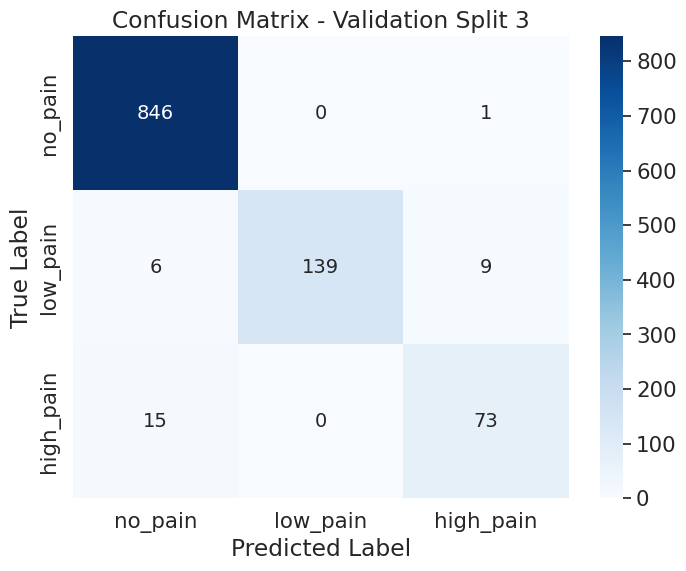

Best score: 0.9559±0.0124
Best experiment split: 2025-11-13 10:33:17.139525_vol-trend_lstm_v2_regularization/split_2
CPU times: user 49min 32s, sys: 4min 29s, total: 54min 1s
Wall time: 34min 37s


In [63]:
# @title Run
%%time
# Execute K-fold cross-validation with baseline configuration
losses, metrics, best_scores, best_model, best_experiment_name = k_shuffle_split_cross_validation_round_rnn(
    df=df_features,
    df_labels=df_labels,
    epochs=EPOCHS,
    criterion=criterion,
    device=device,
    k=K,
    batch_size=BATCH_SIZE,
    hidden_layers=HIDDEN_LAYERS,
    hidden_size=HIDDEN_SIZE,
    learning_rate=LEARNING_RATE,
    dropout_rate=DROPOUT_RATE,
    l1_lambda=L1_LAMBDA,
    l2_lambda=L2_LAMBDA,
    verbose=VERBOSE,
    patience=PATIENCE,
    seed=SEED,
    experiment_name=base_experiment_name,
    test_size=VAL_SIZE,
    window_size=WINDOW_SIZE,
    stride=STRIDE,
    rnn_type=RNN_TYPE,
    bidirectional=BIDIRECTIONAL,
    writer=writer
)

final_best_params = {
  'k': K,
  'test_size': VAL_SIZE,
  'epochs': EPOCHS,
  'patience': PATIENCE,
  'verbose': 0,
  'learning_rate': LEARNING_RATE,
  'batch_size': BATCH_SIZE,
  'window_size': WINDOW_SIZE,
  'stride': STRIDE,
  'hidden_layers': HIDDEN_LAYERS,
  'hidden_size': HIDDEN_SIZE,
  'rnn_type': RNN_TYPE,
  'bidirectional': BIDIRECTIONAL,
  'dropout_rate': DROPOUT_RATE,
  'l1_lambda': L1_LAMBDA,
  'l2_lambda': L2_LAMBDA,
  'criterion': criterion,
  'device': device,
  'seed': SEED
}

print(f"Best experiment split: {best_experiment_name}")

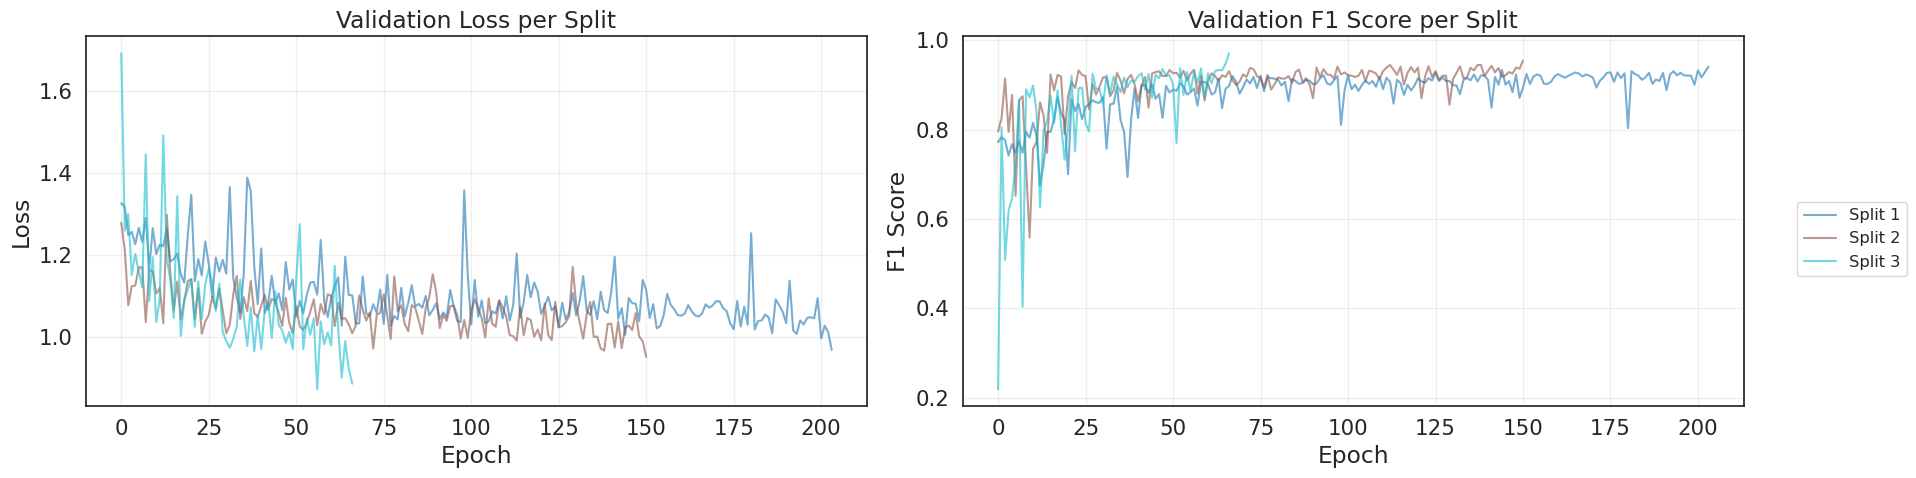

In [64]:
# @title Plot history
# Create figure with two subplots sharing x axis
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5), sharex=True)

# Color palette for K splits
colors = plt.cm.get_cmap('tab10', K)

# Plot validation loss for each split
for split in range(K):
    axes[0].plot(losses[f'split_{split}'][:-PATIENCE], label=f'Split {split+1}',
                 color=colors(split), alpha=0.6)
axes[0].set_title('Validation Loss per Split')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].grid(alpha=0.3)

# Plot validation F1 score for each split
for split in range(K):
    axes[1].plot(metrics[f'split_{split}'][:-PATIENCE], label=f'Split {split+1}',
                 color=colors(split), alpha=0.6)
axes[1].set_title('Validation F1 Score per Split')
axes[1].set_ylabel('F1 Score')
axes[1].set_xlabel('Epoch')
axes[1].grid(alpha=0.3)

# Add shared legend on the right
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(right=0.975)
plt.savefig(f'models/{base_experiment_name}/validation_f1-score_history.png')
plt.show()

---
## ❌ **3. Run with more regularization...**
> Dropout rate to 0.3. L2-lambda to 3e-4. </br>
> `Best score: 0.9510±0.0129`. Going back to underfitting.

In [65]:
# @title Configuration
# Cross-validation
K = 3                    # Number of splits (5 and 10 are considered good values)
VAL_SIZE = 99            # Size or fraction for validation splits

# Training
EPOCHS = 10000           # Maximum epochs (increase to improve performance)
PATIENCE = 100           # Early stopping patience (increase to improve performance)
VERBOSE = 10             # Print frequency

# Optimisation
LEARNING_RATE = 1e-3     # Learning rate
BATCH_SIZE = 32          # Batch size
WINDOW_SIZE = 50         # Input window size
STRIDE = 10               # Input stride

# Architecture
HIDDEN_LAYERS = 2        # Hidden layers
HIDDEN_SIZE = 64         # Neurons per layer
RNN_TYPE = 'LSTM'        # Type of RNN architecture
BIDIRECTIONAL = True     # Bidirectional RNN

# Regularisation
DROPOUT_RATE = 0.3       # Dropout probability
L1_LAMBDA = 0            # L1 penalty
L2_LAMBDA = 3e-4         # L2 penalty


# Loss function
ALPHA = 0.1              # Smoothing applied on the loss (between 0 and 1)
CLASS_WEIGHTS_LIST = [0.43, 2.32, 4.0]
CLASS_WEIGHTS = torch.tensor(CLASS_WEIGHTS_LIST, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=ALPHA, weight=CLASS_WEIGHTS)


# Experiment name
base_experiment_name = f'{str(datetime.now())}_vol-trend_lstm_v3_regularization'
print(f"Experiment: {base_experiment_name}")

# Setup TensorBoard writer
writer = SummaryWriter("./"+logs_dir+"/"+base_experiment_name)

# Initialize best model tracking variables
best_model = None
best_experiment_name = None
best_performance = float('-inf')

Experiment: 2025-11-13 11:21:28.813585_vol-trend_lstm_v3_regularization


Split 1/3
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.1940, F1 Score=0.3966 | Val: Loss=1.4181, F1 Score=0.2378
Epoch  10/10000 | Train: Loss=0.8656, F1 Score=0.8310 | Val: Loss=1.2935, F1 Score=0.7025
Epoch  20/10000 | Train: Loss=0.7280, F1 Score=0.9135 | Val: Loss=1.3024, F1 Score=0.8274
Epoch  30/10000 | Train: Loss=0.6779, F1 Score=0.9403 | Val: Loss=1.1794, F1 Score=0.8522
Epoch  40/10000 | Train: Loss=0.6183, F1 Score=0.9623 | Val: Loss=1.1531, F1 Score=0.8595
Epoch  50/10000 | Train: Loss=0.6004, F1 Score=0.9693 | Val: Loss=1.1719, F1 Score=0.8659
Epoch  60/10000 | Train: Loss=0.6038, F1 Score=0.9740 | Val: Loss=1.0591, F1 Score=0.9036
Epoch  70/10000 | Train: Loss=0.5939, F1 Score=0.9796 | Val: Loss=1.0635, F1 Score=0.9155
Epoch  80/10000 | Train: Loss=0.5934, F1 Score=0.9816 | Val: Loss=1.1063, F1 Score=0.87

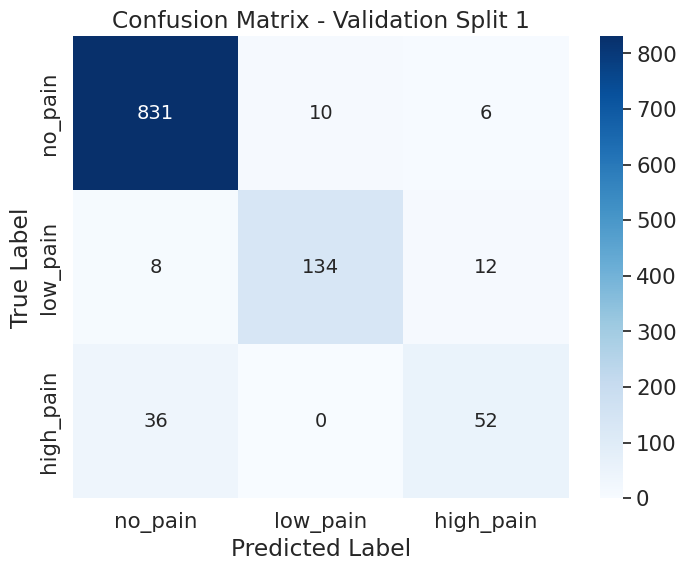

Split 2/3
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.1969, F1 Score=0.3978 | Val: Loss=1.2726, F1 Score=0.7493
Epoch  10/10000 | Train: Loss=0.8338, F1 Score=0.8374 | Val: Loss=1.0747, F1 Score=0.7906
Epoch  20/10000 | Train: Loss=0.7211, F1 Score=0.9089 | Val: Loss=1.3256, F1 Score=0.6474
Epoch  30/10000 | Train: Loss=0.6651, F1 Score=0.9346 | Val: Loss=1.0183, F1 Score=0.9265
Epoch  40/10000 | Train: Loss=0.6452, F1 Score=0.9479 | Val: Loss=0.9593, F1 Score=0.9348
Epoch  50/10000 | Train: Loss=0.6122, F1 Score=0.9626 | Val: Loss=0.9886, F1 Score=0.9330
Epoch  60/10000 | Train: Loss=0.6063, F1 Score=0.9667 | Val: Loss=0.9767, F1 Score=0.9366
Epoch  70/10000 | Train: Loss=0.6016, F1 Score=0.9748 | Val: Loss=1.0731, F1 Score=0.9045
Epoch  80/10000 | Train: Loss=0.6001, F1 Score=0.9725 | Val: Loss=0.9599, F1 Score=0.92

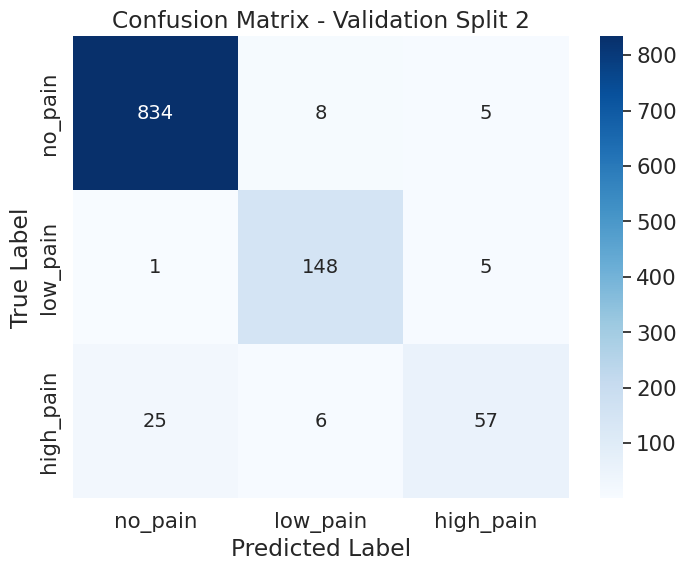

Split 3/3
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2091, F1 Score=0.3895 | Val: Loss=1.2893, F1 Score=0.7879
Epoch  10/10000 | Train: Loss=0.8340, F1 Score=0.8350 | Val: Loss=1.0631, F1 Score=0.8852
Epoch  20/10000 | Train: Loss=0.7093, F1 Score=0.9081 | Val: Loss=1.1963, F1 Score=0.8099
Epoch  30/10000 | Train: Loss=0.6728, F1 Score=0.9224 | Val: Loss=1.0045, F1 Score=0.9238
Epoch  40/10000 | Train: Loss=0.6311, F1 Score=0.9547 | Val: Loss=1.0266, F1 Score=0.9265
Epoch  50/10000 | Train: Loss=0.6173, F1 Score=0.9615 | Val: Loss=0.9269, F1 Score=0.9477
Epoch  60/10000 | Train: Loss=0.6181, F1 Score=0.9702 | Val: Loss=0.9544, F1 Score=0.9164
Epoch  70/10000 | Train: Loss=0.6150, F1 Score=0.9649 | Val: Loss=0.9936, F1 Score=0.9229
Epoch  80/10000 | Train: Loss=0.6089, F1 Score=0.9702 | Val: Loss=0.9572, F1 Score=0.93

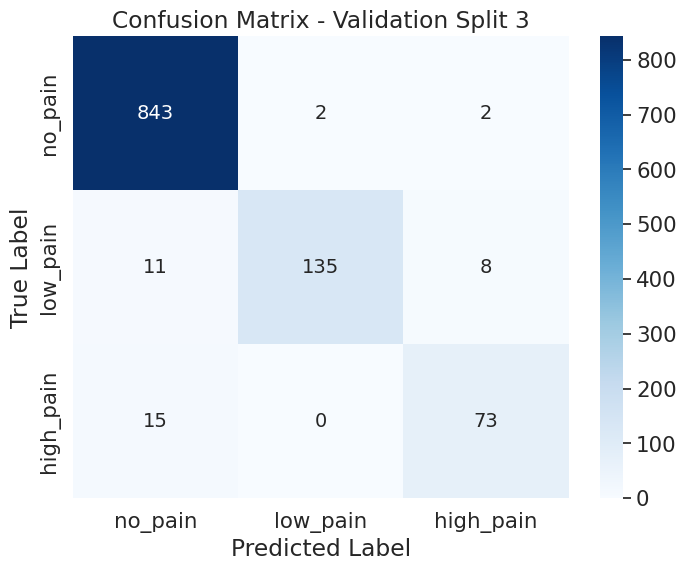

Best score: 0.9510±0.0129
Best experiment split: 2025-11-13 11:21:28.813585_vol-trend_lstm_v3_regularization/split_2
CPU times: user 50min 5s, sys: 4min 33s, total: 54min 39s
Wall time: 35min 20s


In [66]:
# @title Run
%%time
# Execute K-fold cross-validation with baseline configuration
losses, metrics, best_scores, best_model, best_experiment_name = k_shuffle_split_cross_validation_round_rnn(
    df=df_features,
    df_labels=df_labels,
    epochs=EPOCHS,
    criterion=criterion,
    device=device,
    k=K,
    batch_size=BATCH_SIZE,
    hidden_layers=HIDDEN_LAYERS,
    hidden_size=HIDDEN_SIZE,
    learning_rate=LEARNING_RATE,
    dropout_rate=DROPOUT_RATE,
    l1_lambda=L1_LAMBDA,
    l2_lambda=L2_LAMBDA,
    verbose=VERBOSE,
    patience=PATIENCE,
    seed=SEED,
    experiment_name=base_experiment_name,
    test_size=VAL_SIZE,
    window_size=WINDOW_SIZE,
    stride=STRIDE,
    rnn_type=RNN_TYPE,
    bidirectional=BIDIRECTIONAL,
    writer=writer
)

final_best_params = {
  'k': K,
  'test_size': VAL_SIZE,
  'epochs': EPOCHS,
  'patience': PATIENCE,
  'verbose': 0,
  'learning_rate': LEARNING_RATE,
  'batch_size': BATCH_SIZE,
  'window_size': WINDOW_SIZE,
  'stride': STRIDE,
  'hidden_layers': HIDDEN_LAYERS,
  'hidden_size': HIDDEN_SIZE,
  'rnn_type': RNN_TYPE,
  'bidirectional': BIDIRECTIONAL,
  'dropout_rate': DROPOUT_RATE,
  'l1_lambda': L1_LAMBDA,
  'l2_lambda': L2_LAMBDA,
  'criterion': criterion,
  'device': device,
  'seed': SEED
}

print(f"Best experiment split: {best_experiment_name}")

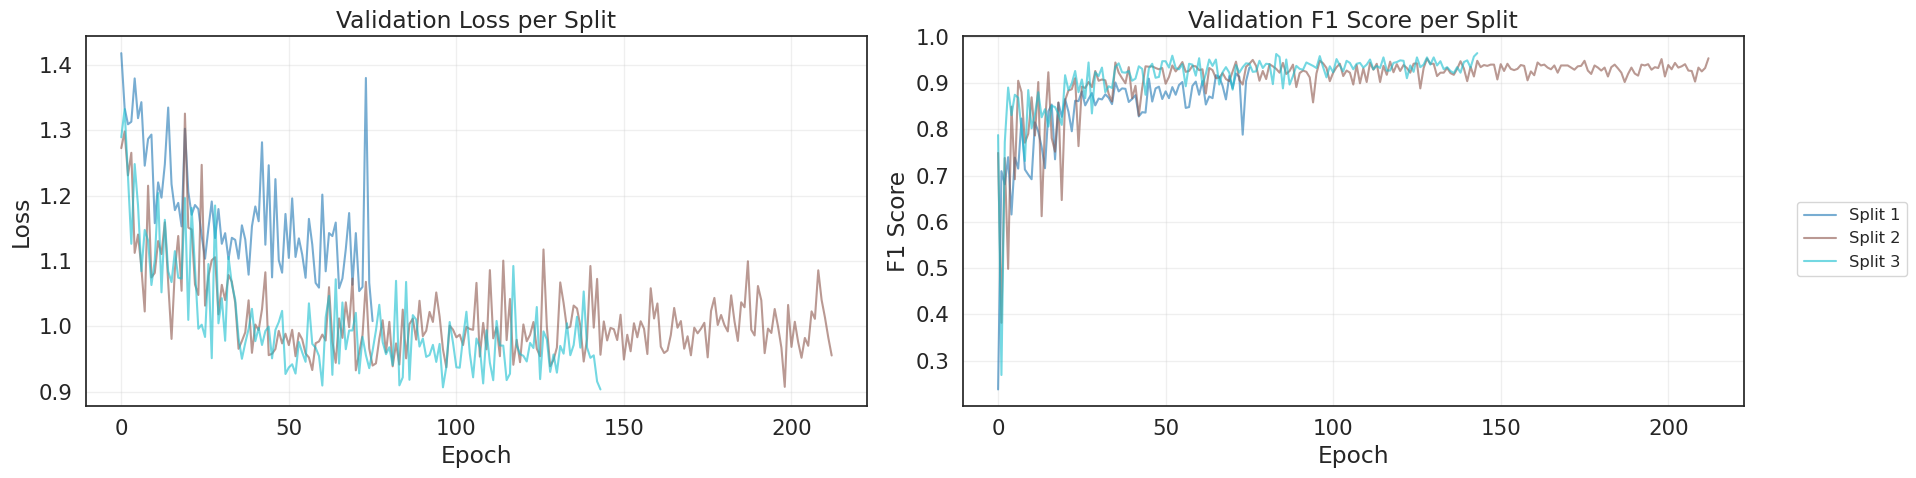

In [67]:
# @title Plot history
# Create figure with two subplots sharing x axis
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5), sharex=True)

# Color palette for K splits
colors = plt.cm.get_cmap('tab10', K)

# Plot validation loss for each split
for split in range(K):
    axes[0].plot(losses[f'split_{split}'][:-PATIENCE], label=f'Split {split+1}',
                 color=colors(split), alpha=0.6)
axes[0].set_title('Validation Loss per Split')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].grid(alpha=0.3)

# Plot validation F1 score for each split
for split in range(K):
    axes[1].plot(metrics[f'split_{split}'][:-PATIENCE], label=f'Split {split+1}',
                 color=colors(split), alpha=0.6)
axes[1].set_title('Validation F1 Score per Split')
axes[1].set_ylabel('F1 Score')
axes[1].set_xlabel('Epoch')
axes[1].grid(alpha=0.3)

# Add shared legend on the right
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(right=0.975)
plt.savefig(f'models/{base_experiment_name}/validation_f1-score_history.png')
plt.show()

---
## ❌ **3b. Run with smaller learning rate...**
> Learning rate to 5e-4. K = 5. </br>
> `Best score: 0.9330±0.0255`. If we ignore the additional K-splits, the first three showed basically no improvements.

In [68]:
# @title Configuration
# Cross-validation
K = 5                    # Number of splits (5 and 10 are considered good values)
VAL_SIZE = 99            # Size or fraction for validation splits

# Training
EPOCHS = 10000           # Maximum epochs (increase to improve performance)
PATIENCE = 100           # Early stopping patience (increase to improve performance)
VERBOSE = 10             # Print frequency

# Optimisation
LEARNING_RATE = 5e-4     # Learning rate
BATCH_SIZE = 32          # Batch size
WINDOW_SIZE = 50         # Input window size
STRIDE = 10               # Input stride

# Architecture
HIDDEN_LAYERS = 2        # Hidden layers
HIDDEN_SIZE = 64         # Neurons per layer
RNN_TYPE = 'LSTM'        # Type of RNN architecture
BIDIRECTIONAL = True     # Bidirectional RNN

# Regularisation
DROPOUT_RATE = 0.2       # Dropout probability
L1_LAMBDA = 0            # L1 penalty
L2_LAMBDA = 1e-4         # L2 penalty

# Loss function
ALPHA = 0.1              # Smoothing applied on the loss (between 0 and 1)
CLASS_WEIGHTS_LIST = [0.43, 2.32, 4.0]
CLASS_WEIGHTS = torch.tensor(CLASS_WEIGHTS_LIST, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=ALPHA, weight=CLASS_WEIGHTS)


# Experiment name
base_experiment_name = f'{str(datetime.now())}_vol-trend_lstm_v3b_lr'
print(f"Experiment: {base_experiment_name}")

# Setup TensorBoard writer
writer = SummaryWriter("./"+logs_dir+"/"+base_experiment_name)

# Initialize best model tracking variables
best_model = None
best_experiment_name = None
best_performance = float('-inf')

Experiment: 2025-11-13 12:07:36.017961_vol-trend_lstm_v3b_lr


Split 1/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.1976, F1 Score=0.3610 | Val: Loss=1.4459, F1 Score=0.1873
Epoch  10/10000 | Train: Loss=0.8538, F1 Score=0.8373 | Val: Loss=1.2174, F1 Score=0.7576
Epoch  20/10000 | Train: Loss=0.7190, F1 Score=0.9122 | Val: Loss=1.2140, F1 Score=0.8347
Epoch  30/10000 | Train: Loss=0.6513, F1 Score=0.9534 | Val: Loss=1.1841, F1 Score=0.8696
Epoch  40/10000 | Train: Loss=0.6276, F1 Score=0.9698 | Val: Loss=1.1153, F1 Score=0.8926
Epoch  50/10000 | Train: Loss=0.6067, F1 Score=0.9774 | Val: Loss=1.0966, F1 Score=0.9027
Epoch  60/10000 | Train: Loss=0.5947, F1 Score=0.9832 | Val: Loss=1.0820, F1 Score=0.9109
Epoch  70/10000 | Train: Loss=0.5898, F1 Score=0.9875 | Val: Loss=1.0884, F1 Score=0.9109
Epoch  80/10000 | Train: Loss=0.5796, F1 Score=0.9895 | Val: Loss=1.0897, F1 Score=0.90

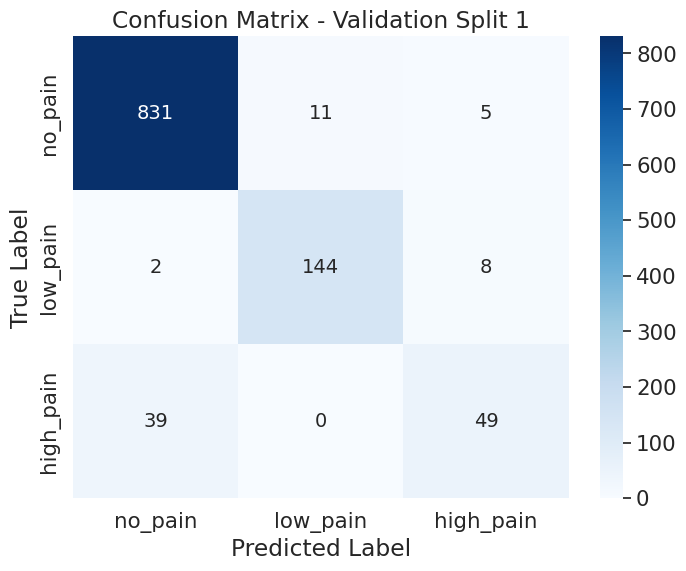

Split 2/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2039, F1 Score=0.3598 | Val: Loss=1.2838, F1 Score=0.7383
Epoch  10/10000 | Train: Loss=0.8406, F1 Score=0.8255 | Val: Loss=1.1629, F1 Score=0.7365
Epoch  20/10000 | Train: Loss=0.7204, F1 Score=0.8923 | Val: Loss=1.1307, F1 Score=0.7888
Epoch  30/10000 | Train: Loss=0.6608, F1 Score=0.9448 | Val: Loss=1.1340, F1 Score=0.8843
Epoch  40/10000 | Train: Loss=0.6451, F1 Score=0.9549 | Val: Loss=0.9977, F1 Score=0.9339
Epoch  50/10000 | Train: Loss=0.6162, F1 Score=0.9655 | Val: Loss=1.0372, F1 Score=0.9118
Epoch  60/10000 | Train: Loss=0.5953, F1 Score=0.9819 | Val: Loss=1.0795, F1 Score=0.9155
Epoch  70/10000 | Train: Loss=0.6034, F1 Score=0.9780 | Val: Loss=1.0664, F1 Score=0.9054
Epoch  80/10000 | Train: Loss=0.5874, F1 Score=0.9837 | Val: Loss=1.0293, F1 Score=0.91

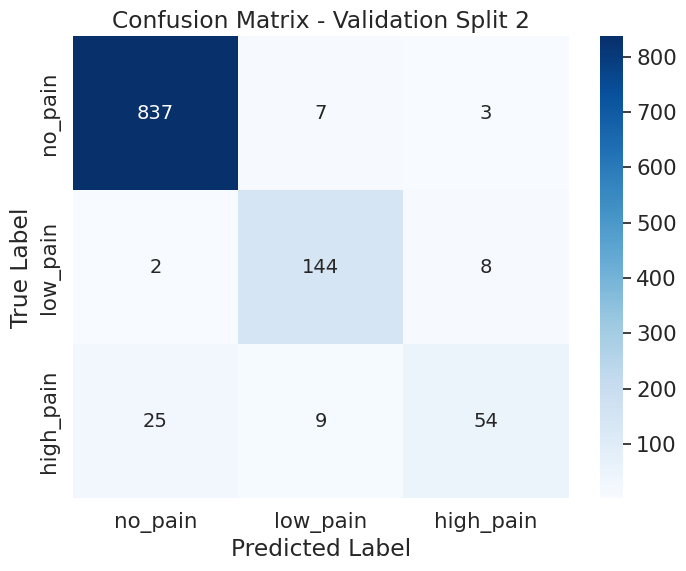

Split 3/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2022, F1 Score=0.3447 | Val: Loss=1.2931, F1 Score=0.6612
Epoch  10/10000 | Train: Loss=0.8283, F1 Score=0.8379 | Val: Loss=1.2304, F1 Score=0.7438
Epoch  20/10000 | Train: Loss=0.6986, F1 Score=0.9177 | Val: Loss=1.0513, F1 Score=0.8751
Epoch  30/10000 | Train: Loss=0.6459, F1 Score=0.9474 | Val: Loss=0.9452, F1 Score=0.9238
Epoch  40/10000 | Train: Loss=0.6394, F1 Score=0.9570 | Val: Loss=0.9747, F1 Score=0.9495
Epoch  50/10000 | Train: Loss=0.6209, F1 Score=0.9728 | Val: Loss=0.9234, F1 Score=0.9495
Epoch  60/10000 | Train: Loss=0.6245, F1 Score=0.9709 | Val: Loss=1.0476, F1 Score=0.9155
Epoch  70/10000 | Train: Loss=0.6117, F1 Score=0.9754 | Val: Loss=0.9246, F1 Score=0.9532
Epoch  80/10000 | Train: Loss=0.5883, F1 Score=0.9845 | Val: Loss=0.9709, F1 Score=0.94

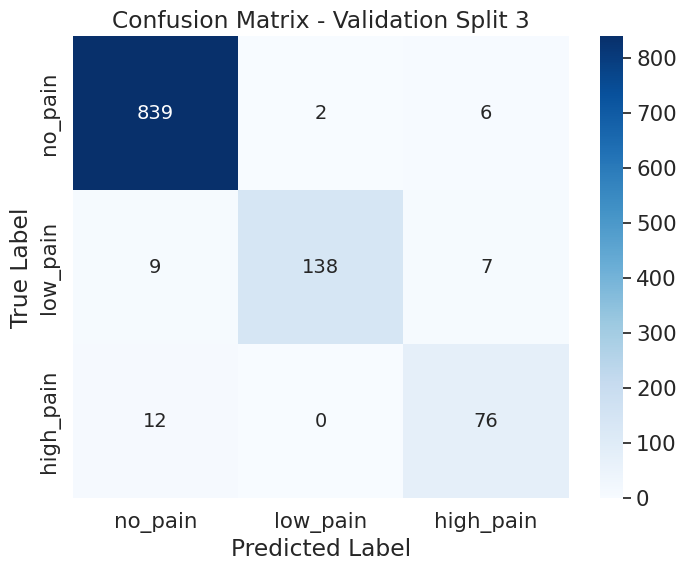

Split 4/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2001, F1 Score=0.2978 | Val: Loss=1.4288, F1 Score=0.3535
Epoch  10/10000 | Train: Loss=0.7960, F1 Score=0.8805 | Val: Loss=1.2457, F1 Score=0.8219
Epoch  20/10000 | Train: Loss=0.6736, F1 Score=0.9343 | Val: Loss=1.1765, F1 Score=0.8494
Epoch  30/10000 | Train: Loss=0.6306, F1 Score=0.9659 | Val: Loss=1.1764, F1 Score=0.8393
Epoch  40/10000 | Train: Loss=0.6057, F1 Score=0.9761 | Val: Loss=1.2309, F1 Score=0.8118
Epoch  50/10000 | Train: Loss=0.5975, F1 Score=0.9803 | Val: Loss=1.1693, F1 Score=0.8659
Epoch  60/10000 | Train: Loss=0.6084, F1 Score=0.9780 | Val: Loss=1.2931, F1 Score=0.8421
Epoch  70/10000 | Train: Loss=0.5889, F1 Score=0.9832 | Val: Loss=1.2258, F1 Score=0.8558
Epoch  80/10000 | Train: Loss=0.5849, F1 Score=0.9887 | Val: Loss=1.1745, F1 Score=0.86

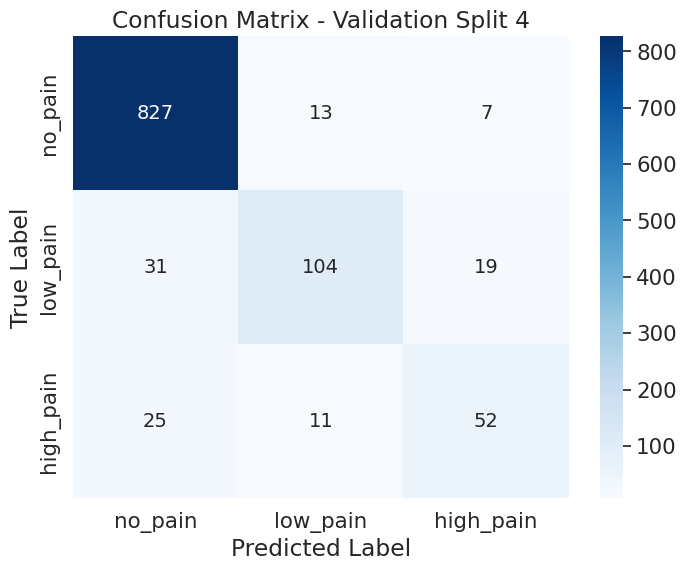

Split 5/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2119, F1 Score=0.2926 | Val: Loss=1.3417, F1 Score=0.6850
Epoch  10/10000 | Train: Loss=0.8236, F1 Score=0.8405 | Val: Loss=1.3927, F1 Score=0.6630
Epoch  20/10000 | Train: Loss=0.7090, F1 Score=0.9047 | Val: Loss=1.2674, F1 Score=0.8421
Epoch  30/10000 | Train: Loss=0.6439, F1 Score=0.9490 | Val: Loss=1.3575, F1 Score=0.7723
Epoch  40/10000 | Train: Loss=0.6241, F1 Score=0.9680 | Val: Loss=1.1998, F1 Score=0.8843
Epoch  50/10000 | Train: Loss=0.6085, F1 Score=0.9765 | Val: Loss=1.1834, F1 Score=0.8962
Epoch  60/10000 | Train: Loss=0.6123, F1 Score=0.9749 | Val: Loss=1.2457, F1 Score=0.8430
Epoch  70/10000 | Train: Loss=0.5812, F1 Score=0.9863 | Val: Loss=1.2387, F1 Score=0.8770
Epoch  80/10000 | Train: Loss=0.5829, F1 Score=0.9874 | Val: Loss=1.1542, F1 Score=0.90

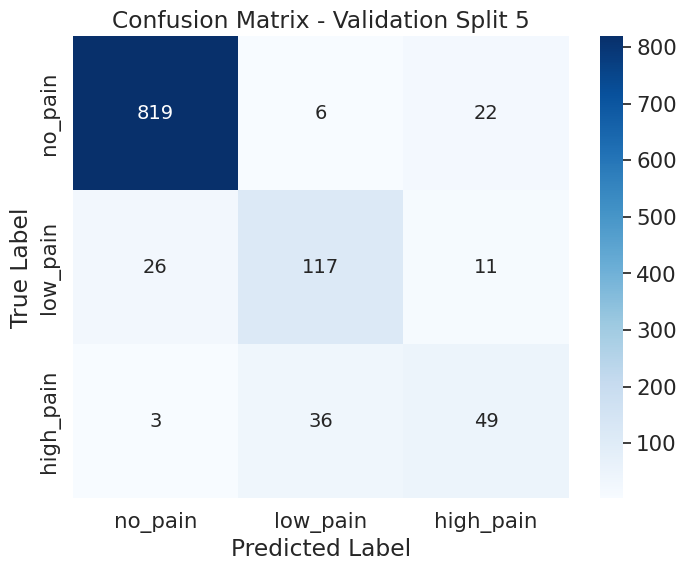

Best score: 0.9330±0.0255
Best experiment split: 2025-11-13 12:07:36.017961_vol-trend_lstm_v3b_lr/split_2
CPU times: user 1h 14min 27s, sys: 6min 46s, total: 1h 21min 14s
Wall time: 52min 36s


In [69]:
# @title Run
%%time
# Execute K-fold cross-validation with baseline configuration
losses, metrics, best_scores, best_model, best_experiment_name = k_shuffle_split_cross_validation_round_rnn(
    df=df_features,
    df_labels=df_labels,
    epochs=EPOCHS,
    criterion=criterion,
    device=device,
    k=K,
    batch_size=BATCH_SIZE,
    hidden_layers=HIDDEN_LAYERS,
    hidden_size=HIDDEN_SIZE,
    learning_rate=LEARNING_RATE,
    dropout_rate=DROPOUT_RATE,
    l1_lambda=L1_LAMBDA,
    l2_lambda=L2_LAMBDA,
    verbose=VERBOSE,
    patience=PATIENCE,
    seed=SEED,
    experiment_name=base_experiment_name,
    test_size=VAL_SIZE,
    window_size=WINDOW_SIZE,
    stride=STRIDE,
    rnn_type=RNN_TYPE,
    bidirectional=BIDIRECTIONAL,
    writer=writer
)

final_best_params = {
  'k': K,
  'test_size': VAL_SIZE,
  'epochs': EPOCHS,
  'patience': PATIENCE,
  'verbose': 0,
  'learning_rate': LEARNING_RATE,
  'batch_size': BATCH_SIZE,
  'window_size': WINDOW_SIZE,
  'stride': STRIDE,
  'hidden_layers': HIDDEN_LAYERS,
  'hidden_size': HIDDEN_SIZE,
  'rnn_type': RNN_TYPE,
  'bidirectional': BIDIRECTIONAL,
  'dropout_rate': DROPOUT_RATE,
  'l1_lambda': L1_LAMBDA,
  'l2_lambda': L2_LAMBDA,
  'criterion': criterion,
  'device': device,
  'seed': SEED
}

print(f"Best experiment split: {best_experiment_name}")

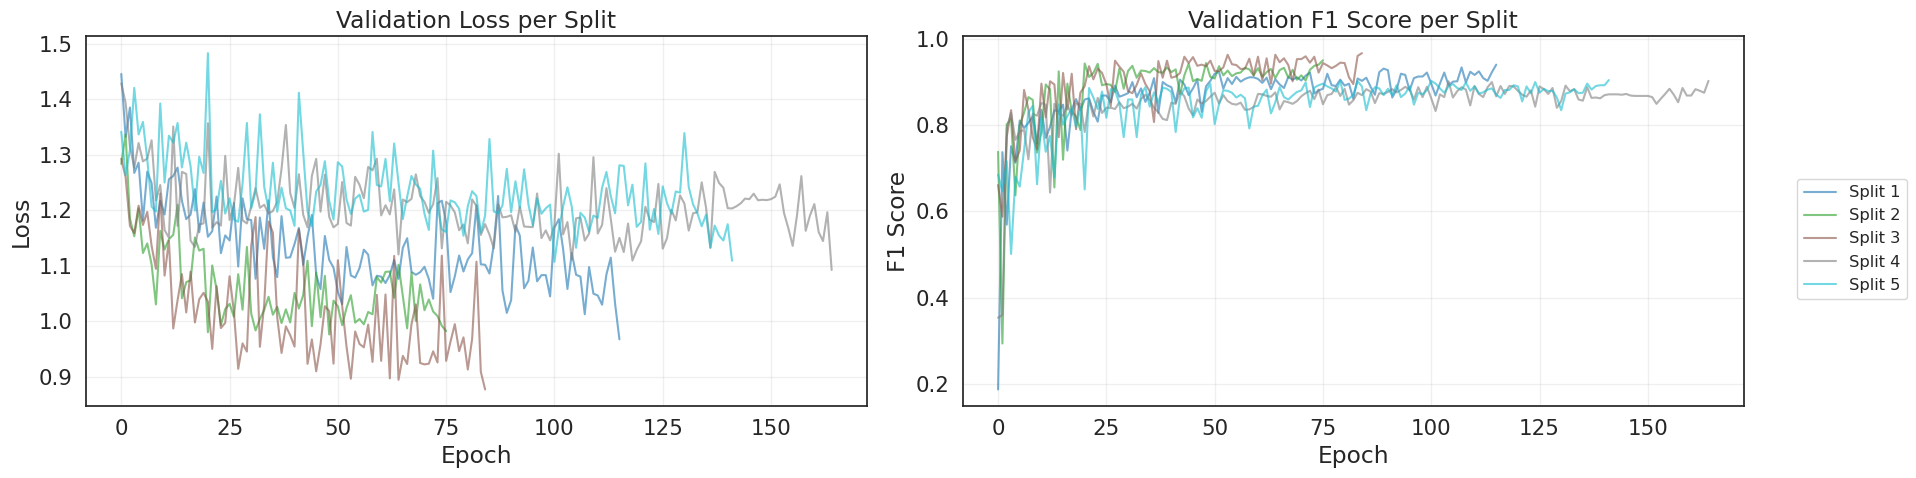

In [70]:
# @title Plot history
# Create figure with two subplots sharing x axis
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5), sharex=True)

# Color palette for K splits
colors = plt.cm.get_cmap('tab10', K)

# Plot validation loss for each split
for split in range(K):
    axes[0].plot(losses[f'split_{split}'][:-PATIENCE], label=f'Split {split+1}',
                 color=colors(split), alpha=0.6)
axes[0].set_title('Validation Loss per Split')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].grid(alpha=0.3)

# Plot validation F1 score for each split
for split in range(K):
    axes[1].plot(metrics[f'split_{split}'][:-PATIENCE], label=f'Split {split+1}',
                 color=colors(split), alpha=0.6)
axes[1].set_title('Validation F1 Score per Split')
axes[1].set_ylabel('F1 Score')
axes[1].set_xlabel('Epoch')
axes[1].grid(alpha=0.3)

# Add shared legend on the right
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(right=0.975)
plt.savefig(f'models/{base_experiment_name}/validation_f1-score_history.png')
plt.show()

---
## 🚀 **3c. Run with grid search over model capacity...**
> Hidden layers in 1, 2, 3. Hidden size in 32, 64, 128. </br>
> The best models seems to be our 2x64 model and the 1x128 one - the first with less variance.

In [76]:
# @title Configuration
# Cross-validation
K = 5                    # Number of splits (5 and 10 are considered good values)
VAL_SIZE = 99            # Size or fraction for validation splits

# Training
EPOCHS = 10000           # Maximum epochs (increase to improve performance)
PATIENCE = 100           # Early stopping patience (increase to improve performance)
VERBOSE = 100            # Print frequency

# Optimisation
LEARNING_RATE = 1e-3     # Learning rate
BATCH_SIZE = 32          # Batch size
WINDOW_SIZE = 50         # Input window size
STRIDE = 10               # Input stride

# Architecture
HIDDEN_LAYERS = 2        # Hidden layers
HIDDEN_SIZE = 64         # Neurons per layer
RNN_TYPE = 'LSTM'        # Type of RNN architecture
BIDIRECTIONAL = True     # Bidirectional RNN

# Regularisation
DROPOUT_RATE = 0.2       # Dropout probability
L1_LAMBDA = 0            # L1 penalty
L2_LAMBDA = 1e-4         # L2 penalty

# Loss function
ALPHA = 0.1              # Smoothing applied on the loss (between 0 and 1)
CLASS_WEIGHTS_LIST = [0.43, 2.32, 4.0]
CLASS_WEIGHTS = torch.tensor(CLASS_WEIGHTS_LIST, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=ALPHA, weight=CLASS_WEIGHTS)


# Experiment name
base_experiment_name = f'{str(datetime.now())}_vol-trend_lstm_v3c_GS-capacity'
print(f"Experiment: {base_experiment_name}")

# Setup TensorBoard writer
# --- writer = SummaryWriter("./"+logs_dir+"/"+base_experiment_name)

# Initialize best model tracking variables
best_model = None
best_experiment_name = None
best_performance = float('-inf')

Experiment: 2025-11-13 13:42:36.424631_vol-trend_lstm_v3c_GS-capacity



Configuration 1/9:
  hidden_layers: 1
  hidden_size: 32
Split 1/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.1889, F1 Score=0.3606 | Val: Loss=1.3393, F1 Score=0.5748
Epoch  50/10000 | Train: Loss=0.6472, F1 Score=0.9600 | Val: Loss=1.1435, F1 Score=0.8806
Epoch 100/10000 | Train: Loss=0.6095, F1 Score=0.9799 | Val: Loss=1.1872, F1 Score=0.8852
Epoch 150/10000 | Train: Loss=0.5969, F1 Score=0.9832 | Val: Loss=1.1404, F1 Score=0.8898
Epoch 200/10000 | Train: Loss=0.5625, F1 Score=0.9968 | Val: Loss=1.1765, F1 Score=0.8962
Epoch 250/10000 | Train: Loss=0.5624, F1 Score=0.9984 | Val: Loss=1.0802, F1 Score=0.9118
Early stopping triggered after 280 epochs.
Best model restored from epoch 180 with val_f1 0.9219

Saved confusion matrix plot to: 'models/hidden_layers_1_hidden_size_32/split_0/confusion_matrix_Validation_Split

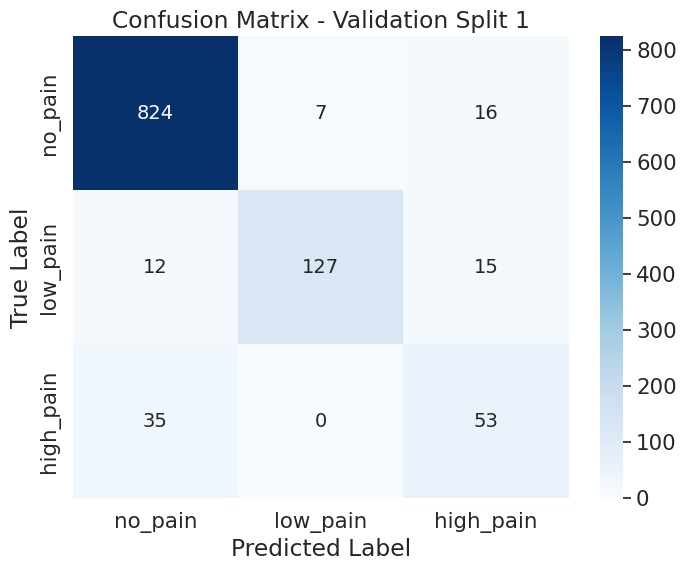

Split 2/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.1976, F1 Score=0.4050 | Val: Loss=1.4164, F1 Score=0.1001
Epoch  50/10000 | Train: Loss=0.6383, F1 Score=0.9439 | Val: Loss=1.0295, F1 Score=0.9128
Epoch 100/10000 | Train: Loss=0.5884, F1 Score=0.9824 | Val: Loss=0.9893, F1 Score=0.9229
Epoch 150/10000 | Train: Loss=0.5770, F1 Score=0.9906 | Val: Loss=1.0639, F1 Score=0.8962
Early stopping triggered after 177 epochs.
Best model restored from epoch 77 with val_f1 0.9522

Saved confusion matrix plot to: 'models/hidden_layers_1_hidden_size_32/split_1/confusion_matrix_Validation_Split_2.png'


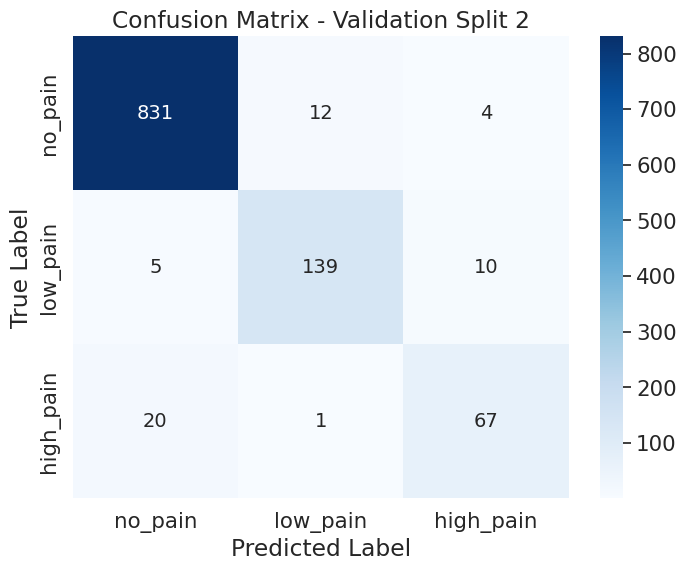

Split 3/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2056, F1 Score=0.3227 | Val: Loss=1.3222, F1 Score=0.5390
Epoch  50/10000 | Train: Loss=0.6449, F1 Score=0.9416 | Val: Loss=0.9471, F1 Score=0.8926
Epoch 100/10000 | Train: Loss=0.6034, F1 Score=0.9735 | Val: Loss=0.9565, F1 Score=0.8935
Epoch 150/10000 | Train: Loss=0.5942, F1 Score=0.9843 | Val: Loss=0.9039, F1 Score=0.9366
Epoch 200/10000 | Train: Loss=0.5724, F1 Score=0.9905 | Val: Loss=0.9562, F1 Score=0.9348
Epoch 250/10000 | Train: Loss=0.5799, F1 Score=0.9895 | Val: Loss=0.9371, F1 Score=0.9412
Epoch 300/10000 | Train: Loss=0.5663, F1 Score=0.9950 | Val: Loss=0.9051, F1 Score=0.9504
Epoch 350/10000 | Train: Loss=0.5635, F1 Score=0.9950 | Val: Loss=0.9655, F1 Score=0.9376
Early stopping triggered after 363 epochs.
Best model restored from epoch 263 with val_

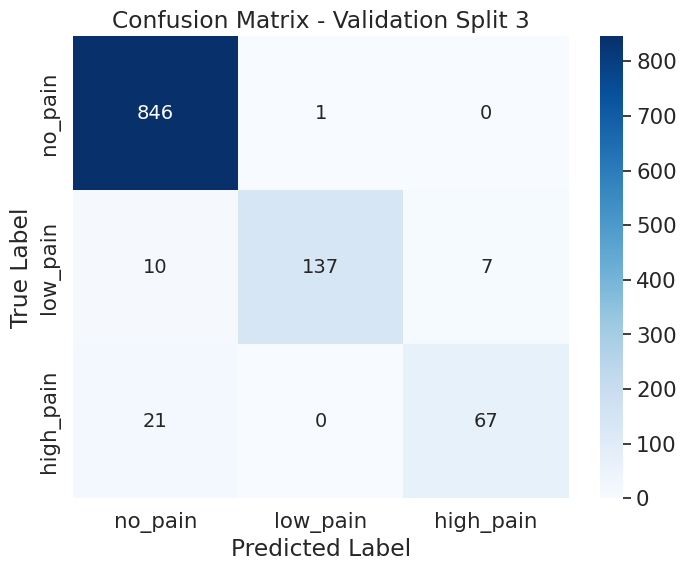

Split 4/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2001, F1 Score=0.3389 | Val: Loss=1.2907, F1 Score=0.6979
Epoch  50/10000 | Train: Loss=0.6511, F1 Score=0.9617 | Val: Loss=1.1422, F1 Score=0.8421
Epoch 100/10000 | Train: Loss=0.6023, F1 Score=0.9795 | Val: Loss=1.1954, F1 Score=0.8724
Epoch 150/10000 | Train: Loss=0.5756, F1 Score=0.9935 | Val: Loss=1.2357, F1 Score=0.8604
Epoch 200/10000 | Train: Loss=0.5913, F1 Score=0.9900 | Val: Loss=1.2624, F1 Score=0.8540
Epoch 250/10000 | Train: Loss=0.5569, F1 Score=0.9994 | Val: Loss=1.3519, F1 Score=0.8209
Early stopping triggered after 290 epochs.
Best model restored from epoch 190 with val_f1 0.8861

Saved confusion matrix plot to: 'models/hidden_layers_1_hidden_size_32/split_3/confusion_matrix_Validation_Split_4.png'


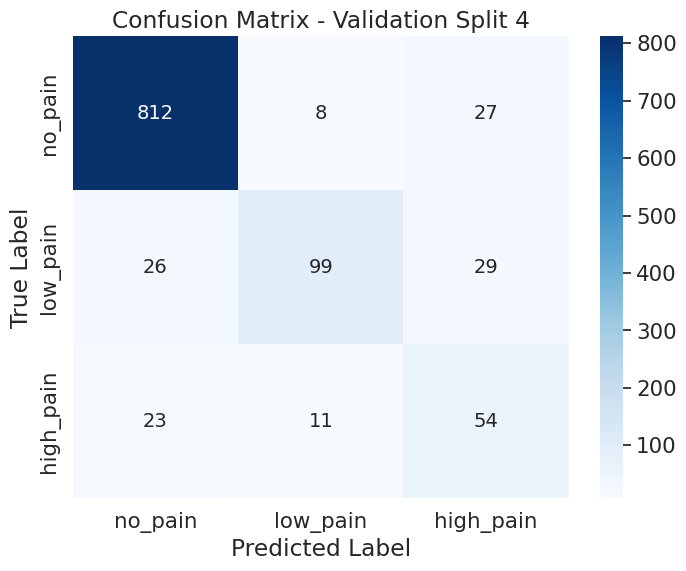

Split 5/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2109, F1 Score=0.2747 | Val: Loss=1.2606, F1 Score=0.6465
Epoch  50/10000 | Train: Loss=0.6318, F1 Score=0.9516 | Val: Loss=1.2645, F1 Score=0.8219
Epoch 100/10000 | Train: Loss=0.5903, F1 Score=0.9808 | Val: Loss=1.2748, F1 Score=0.8393
Epoch 150/10000 | Train: Loss=0.5809, F1 Score=0.9903 | Val: Loss=1.2389, F1 Score=0.8650
Epoch 200/10000 | Train: Loss=0.5764, F1 Score=0.9901 | Val: Loss=1.1617, F1 Score=0.8935
Epoch 250/10000 | Train: Loss=0.5578, F1 Score=0.9977 | Val: Loss=1.1838, F1 Score=0.8852
Early stopping triggered after 283 epochs.
Best model restored from epoch 183 with val_f1 0.9036

Saved confusion matrix plot to: 'models/hidden_layers_1_hidden_size_32/split_4/confusion_matrix_Validation_Split_5.png'


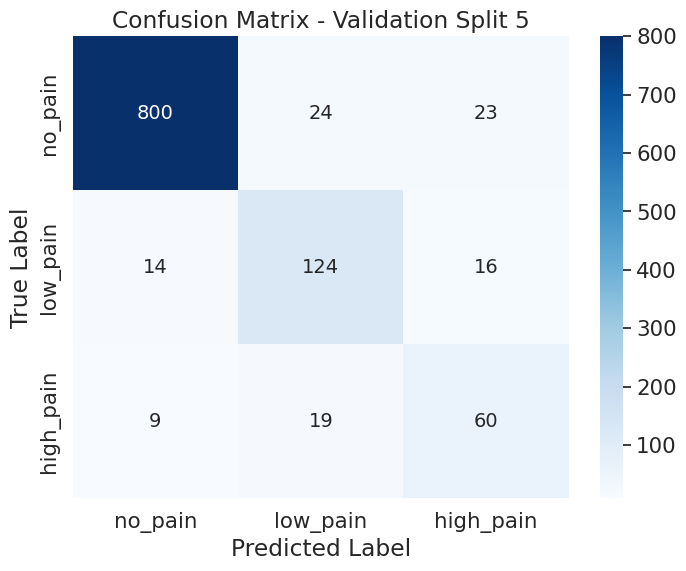

Best score: 0.9256±0.0292
🎉🎉🎉  NEW BEST SCORE! 🎉🎉🎉
  Experiment (split): hidden_layers_1_hidden_size_32/split_2
  F1 Score: 0.9256±0.0292

Configuration 2/9:
  hidden_layers: 1
  hidden_size: 64
Split 1/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2103, F1 Score=0.3782 | Val: Loss=1.3426, F1 Score=0.7649
Epoch  50/10000 | Train: Loss=0.6256, F1 Score=0.9678 | Val: Loss=1.0713, F1 Score=0.8962
Epoch 100/10000 | Train: Loss=0.5860, F1 Score=0.9850 | Val: Loss=1.0917, F1 Score=0.8999
Epoch 150/10000 | Train: Loss=0.5838, F1 Score=0.9911 | Val: Loss=1.0283, F1 Score=0.9238
Epoch 200/10000 | Train: Loss=0.5578, F1 Score=1.0000 | Val: Loss=1.0337, F1 Score=0.9302
Epoch 250/10000 | Train: Loss=0.5544, F1 Score=1.0000 | Val: Loss=1.0690, F1 Score=0.9164
Epoch 300/10000 | Train: Loss=0.5569, F1 Score=0.9998 | Val: Loss=1.0989

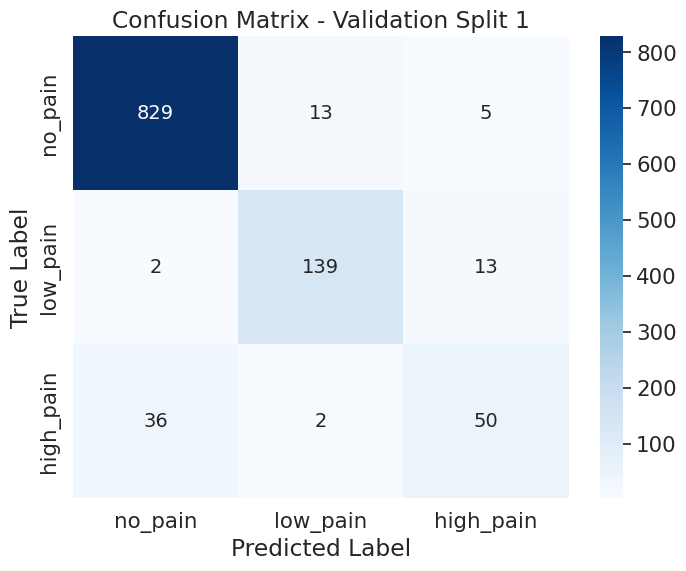

Split 2/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2028, F1 Score=0.3895 | Val: Loss=1.3082, F1 Score=0.4628
Epoch  50/10000 | Train: Loss=0.6249, F1 Score=0.9531 | Val: Loss=1.0235, F1 Score=0.9174
Epoch 100/10000 | Train: Loss=0.5910, F1 Score=0.9790 | Val: Loss=1.0349, F1 Score=0.9192
Epoch 150/10000 | Train: Loss=0.5727, F1 Score=0.9953 | Val: Loss=1.0928, F1 Score=0.9183
Epoch 200/10000 | Train: Loss=0.5634, F1 Score=0.9969 | Val: Loss=1.0924, F1 Score=0.9256
Early stopping triggered after 240 epochs.
Best model restored from epoch 140 with val_f1 0.9421

Saved confusion matrix plot to: 'models/hidden_layers_1_hidden_size_64/split_1/confusion_matrix_Validation_Split_2.png'


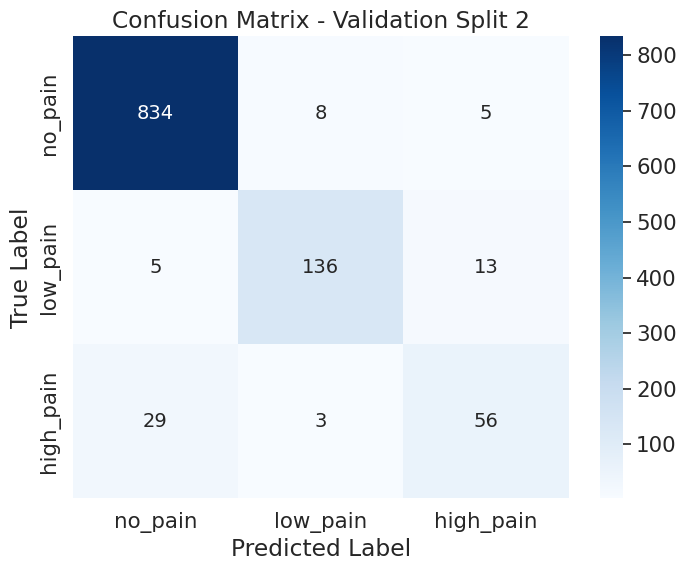

Split 3/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2048, F1 Score=0.3696 | Val: Loss=1.3375, F1 Score=0.6713
Epoch  50/10000 | Train: Loss=0.6441, F1 Score=0.9511 | Val: Loss=1.0495, F1 Score=0.8246
Epoch 100/10000 | Train: Loss=0.5906, F1 Score=0.9830 | Val: Loss=1.0712, F1 Score=0.8962
Epoch 150/10000 | Train: Loss=0.5854, F1 Score=0.9932 | Val: Loss=0.9034, F1 Score=0.9550
Early stopping triggered after 194 epochs.
Best model restored from epoch 94 with val_f1 0.9624

Saved confusion matrix plot to: 'models/hidden_layers_1_hidden_size_64/split_2/confusion_matrix_Validation_Split_3.png'


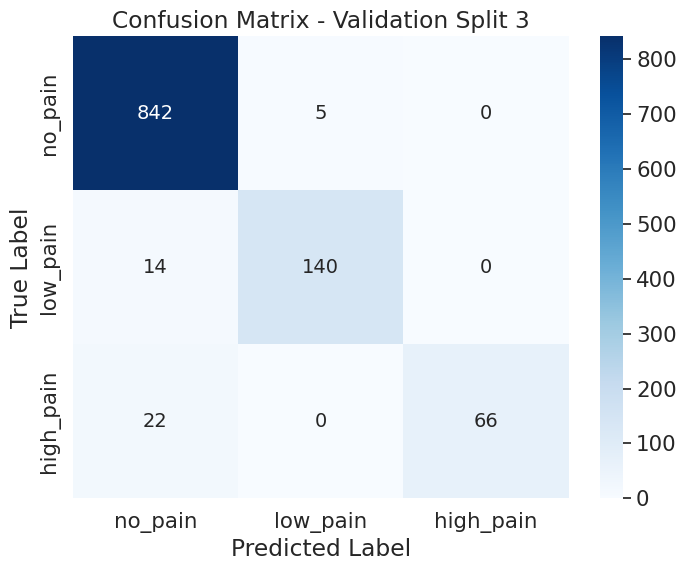

Split 4/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2102, F1 Score=0.3716 | Val: Loss=1.3003, F1 Score=0.7052
Epoch  50/10000 | Train: Loss=0.6212, F1 Score=0.9710 | Val: Loss=1.1729, F1 Score=0.8393
Epoch 100/10000 | Train: Loss=0.5721, F1 Score=0.9926 | Val: Loss=1.2077, F1 Score=0.8696
Epoch 150/10000 | Train: Loss=0.5646, F1 Score=0.9979 | Val: Loss=1.2080, F1 Score=0.8815
Epoch 200/10000 | Train: Loss=0.5539, F1 Score=1.0000 | Val: Loss=1.2181, F1 Score=0.8843
Epoch 250/10000 | Train: Loss=0.5691, F1 Score=0.9961 | Val: Loss=1.2181, F1 Score=0.8806
Early stopping triggered after 287 epochs.
Best model restored from epoch 187 with val_f1 0.8953

Saved confusion matrix plot to: 'models/hidden_layers_1_hidden_size_64/split_3/confusion_matrix_Validation_Split_4.png'


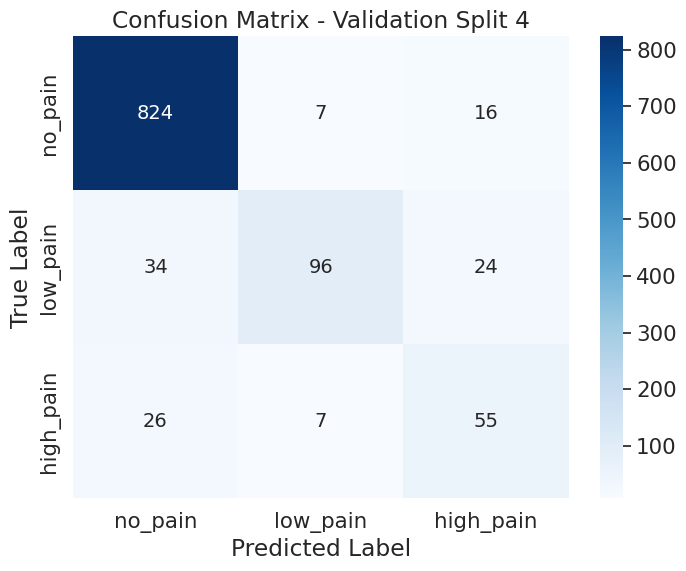

Split 5/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2083, F1 Score=0.3146 | Val: Loss=1.2623, F1 Score=0.6621
Epoch  50/10000 | Train: Loss=0.6232, F1 Score=0.9554 | Val: Loss=1.1825, F1 Score=0.8457
Epoch 100/10000 | Train: Loss=0.5864, F1 Score=0.9796 | Val: Loss=1.1399, F1 Score=0.8880
Epoch 150/10000 | Train: Loss=0.5723, F1 Score=0.9919 | Val: Loss=1.1015, F1 Score=0.9017
Epoch 200/10000 | Train: Loss=0.5659, F1 Score=0.9950 | Val: Loss=1.1229, F1 Score=0.8907
Epoch 250/10000 | Train: Loss=0.5624, F1 Score=0.9989 | Val: Loss=1.1530, F1 Score=0.8880
Early stopping triggered after 296 epochs.
Best model restored from epoch 196 with val_f1 0.9128

Saved confusion matrix plot to: 'models/hidden_layers_1_hidden_size_64/split_4/confusion_matrix_Validation_Split_5.png'


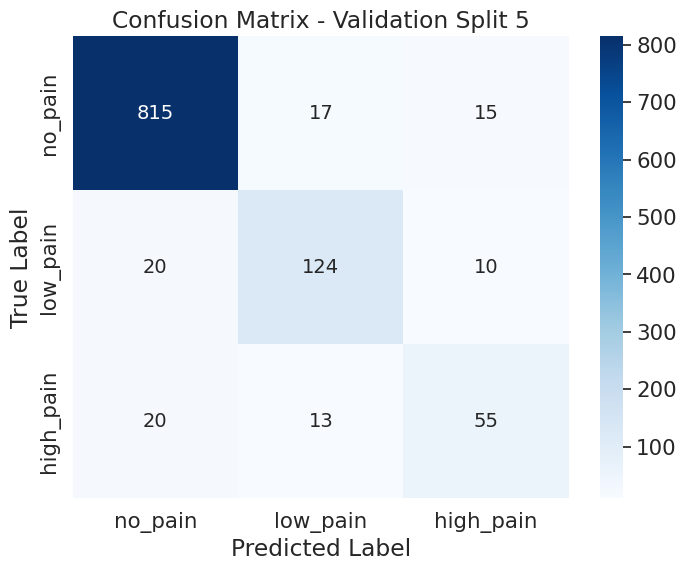

Best score: 0.9295±0.0233
🎉🎉🎉  NEW BEST SCORE! 🎉🎉🎉
  Experiment (split): hidden_layers_1_hidden_size_64/split_2
  F1 Score: 0.9295±0.0233

Configuration 3/9:
  hidden_layers: 1
  hidden_size: 128
Split 1/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2047, F1 Score=0.4497 | Val: Loss=1.3440, F1 Score=0.7273
Epoch  50/10000 | Train: Loss=0.6158, F1 Score=0.9673 | Val: Loss=1.1347, F1 Score=0.8705
Epoch 100/10000 | Train: Loss=0.5793, F1 Score=0.9921 | Val: Loss=1.0247, F1 Score=0.9238
Epoch 150/10000 | Train: Loss=0.5579, F1 Score=1.0000 | Val: Loss=1.0203, F1 Score=0.9320
Epoch 200/10000 | Train: Loss=0.5627, F1 Score=0.9984 | Val: Loss=1.0423, F1 Score=0.9219
Epoch 250/10000 | Train: Loss=0.5536, F1 Score=1.0000 | Val: Loss=1.0541, F1 Score=0.9229
Early stopping triggered after 262 epochs.
Best model restored from epo

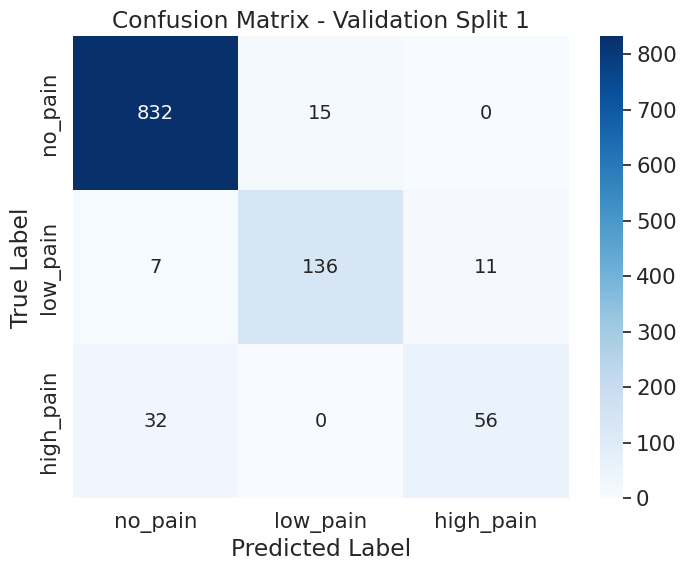

Split 2/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.1953, F1 Score=0.4317 | Val: Loss=1.3527, F1 Score=0.1690
Epoch  50/10000 | Train: Loss=0.6249, F1 Score=0.9579 | Val: Loss=1.0816, F1 Score=0.8613
Epoch 100/10000 | Train: Loss=0.6020, F1 Score=0.9777 | Val: Loss=0.9820, F1 Score=0.9376
Epoch 150/10000 | Train: Loss=0.5802, F1 Score=0.9927 | Val: Loss=1.0215, F1 Score=0.9385
Epoch 200/10000 | Train: Loss=0.5614, F1 Score=1.0000 | Val: Loss=0.9606, F1 Score=0.9504
Early stopping triggered after 220 epochs.
Best model restored from epoch 120 with val_f1 0.9578

Saved confusion matrix plot to: 'models/hidden_layers_1_hidden_size_128/split_1/confusion_matrix_Validation_Split_2.png'


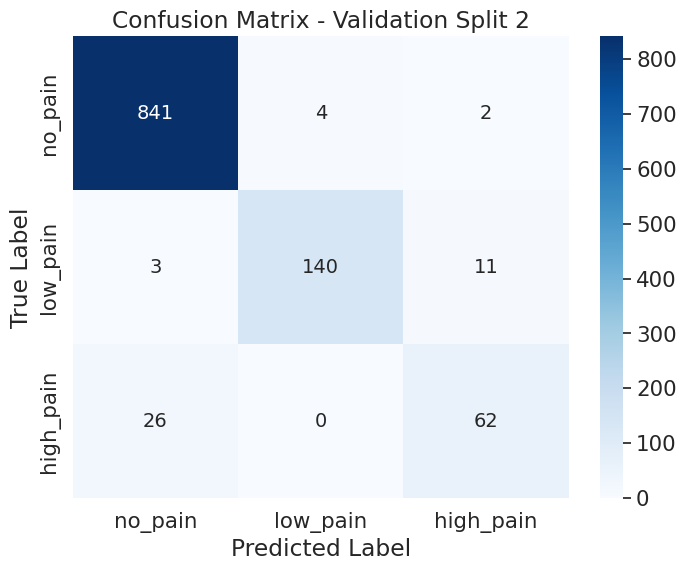

Split 3/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.1908, F1 Score=0.4096 | Val: Loss=1.2867, F1 Score=0.7658
Epoch  50/10000 | Train: Loss=0.6388, F1 Score=0.9542 | Val: Loss=1.0564, F1 Score=0.8852
Epoch 100/10000 | Train: Loss=0.5932, F1 Score=0.9822 | Val: Loss=0.9916, F1 Score=0.9183
Epoch 150/10000 | Train: Loss=0.5845, F1 Score=0.9896 | Val: Loss=0.9560, F1 Score=0.9431
Epoch 200/10000 | Train: Loss=0.5720, F1 Score=0.9940 | Val: Loss=0.9052, F1 Score=0.9651
Epoch 250/10000 | Train: Loss=0.5710, F1 Score=0.9961 | Val: Loss=0.9784, F1 Score=0.9568
Early stopping triggered after 285 epochs.
Best model restored from epoch 185 with val_f1 0.9697

Saved confusion matrix plot to: 'models/hidden_layers_1_hidden_size_128/split_2/confusion_matrix_Validation_Split_3.png'


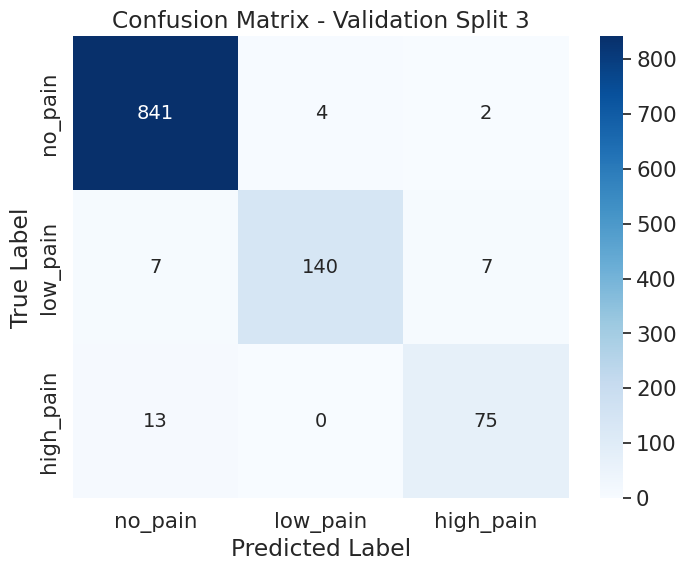

Split 4/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.1965, F1 Score=0.4068 | Val: Loss=1.3232, F1 Score=0.2433
Epoch  50/10000 | Train: Loss=0.6146, F1 Score=0.9749 | Val: Loss=1.1345, F1 Score=0.8549
Epoch 100/10000 | Train: Loss=0.5937, F1 Score=0.9822 | Val: Loss=1.2033, F1 Score=0.8595
Epoch 150/10000 | Train: Loss=0.5599, F1 Score=0.9995 | Val: Loss=1.2301, F1 Score=0.8742
Epoch 200/10000 | Train: Loss=0.5570, F1 Score=1.0000 | Val: Loss=1.2555, F1 Score=0.8724
Early stopping triggered after 229 epochs.
Best model restored from epoch 129 with val_f1 0.8916

Saved confusion matrix plot to: 'models/hidden_layers_1_hidden_size_128/split_3/confusion_matrix_Validation_Split_4.png'


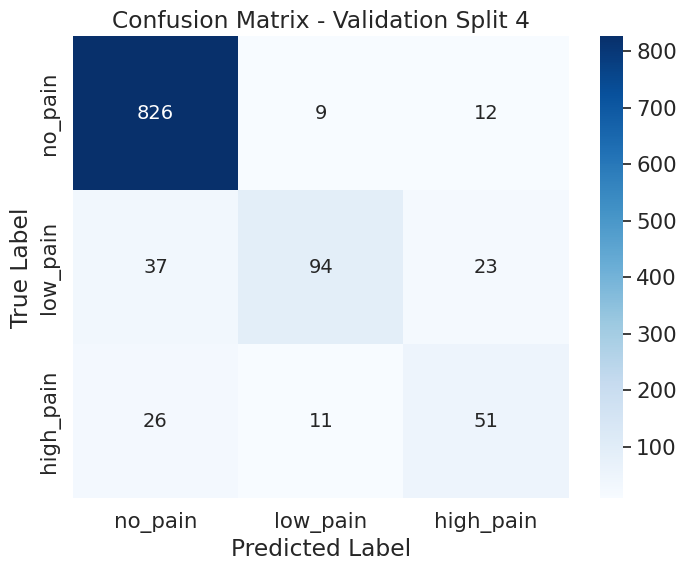

Split 5/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2093, F1 Score=0.3725 | Val: Loss=1.2200, F1 Score=0.7888
Epoch  50/10000 | Train: Loss=0.6251, F1 Score=0.9557 | Val: Loss=1.1570, F1 Score=0.8843
Epoch 100/10000 | Train: Loss=0.5749, F1 Score=0.9880 | Val: Loss=1.1986, F1 Score=0.8503
Epoch 150/10000 | Train: Loss=0.5636, F1 Score=0.9964 | Val: Loss=1.1845, F1 Score=0.8770
Epoch 200/10000 | Train: Loss=0.5576, F1 Score=1.0000 | Val: Loss=1.0981, F1 Score=0.9045
Epoch 250/10000 | Train: Loss=0.6714, F1 Score=0.9539 | Val: Loss=1.1850, F1 Score=0.8815
Early stopping triggered after 271 epochs.
Best model restored from epoch 171 with val_f1 0.9109

Saved confusion matrix plot to: 'models/hidden_layers_1_hidden_size_128/split_4/confusion_matrix_Validation_Split_5.png'


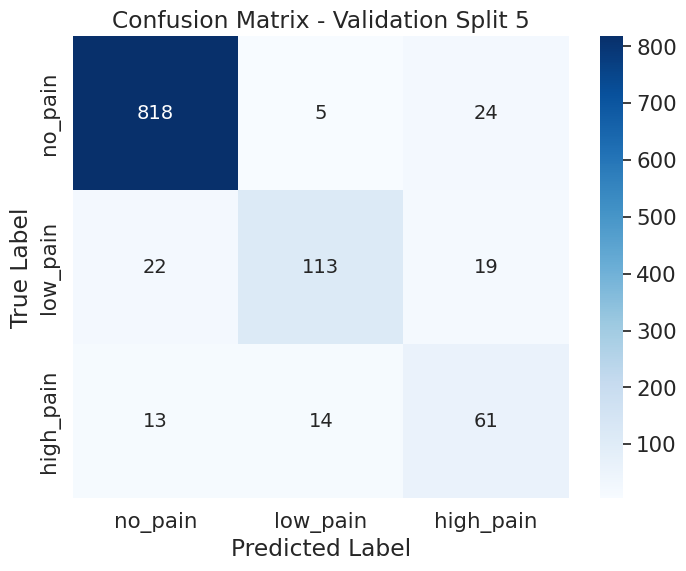

Best score: 0.9341±0.0290
🎉🎉🎉  NEW BEST SCORE! 🎉🎉🎉
  Experiment (split): hidden_layers_1_hidden_size_128/split_2
  F1 Score: 0.9341±0.0290

Configuration 4/9:
  hidden_layers: 2
  hidden_size: 32
Split 1/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.1909, F1 Score=0.3772 | Val: Loss=1.3505, F1 Score=0.6887
Epoch  50/10000 | Train: Loss=0.6162, F1 Score=0.9767 | Val: Loss=1.1428, F1 Score=0.8724
Epoch 100/10000 | Train: Loss=0.5802, F1 Score=0.9911 | Val: Loss=1.1822, F1 Score=0.8650
Epoch 150/10000 | Train: Loss=0.5792, F1 Score=0.9921 | Val: Loss=1.1264, F1 Score=0.8944
Epoch 200/10000 | Train: Loss=0.5662, F1 Score=0.9976 | Val: Loss=1.0822, F1 Score=0.9054
Epoch 250/10000 | Train: Loss=0.5589, F1 Score=1.0000 | Val: Loss=1.0720, F1 Score=0.9201
Early stopping triggered after 278 epochs.
Best model restored from epo

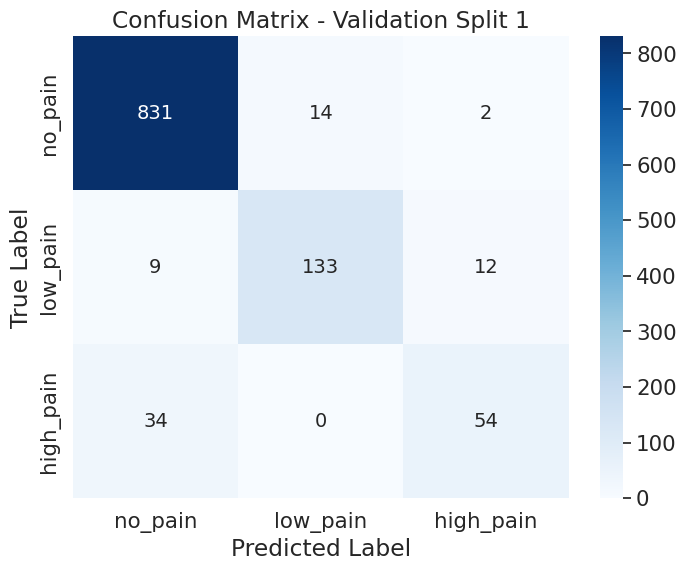

Split 2/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2078, F1 Score=0.3379 | Val: Loss=1.3037, F1 Score=0.5592
Epoch  50/10000 | Train: Loss=0.6237, F1 Score=0.9607 | Val: Loss=1.0817, F1 Score=0.9229
Epoch 100/10000 | Train: Loss=0.5907, F1 Score=0.9872 | Val: Loss=1.0499, F1 Score=0.9201
Epoch 150/10000 | Train: Loss=0.5729, F1 Score=0.9935 | Val: Loss=1.0446, F1 Score=0.9210
Early stopping triggered after 166 epochs.
Best model restored from epoch 66 with val_f1 0.9376

Saved confusion matrix plot to: 'models/hidden_layers_2_hidden_size_32/split_1/confusion_matrix_Validation_Split_2.png'


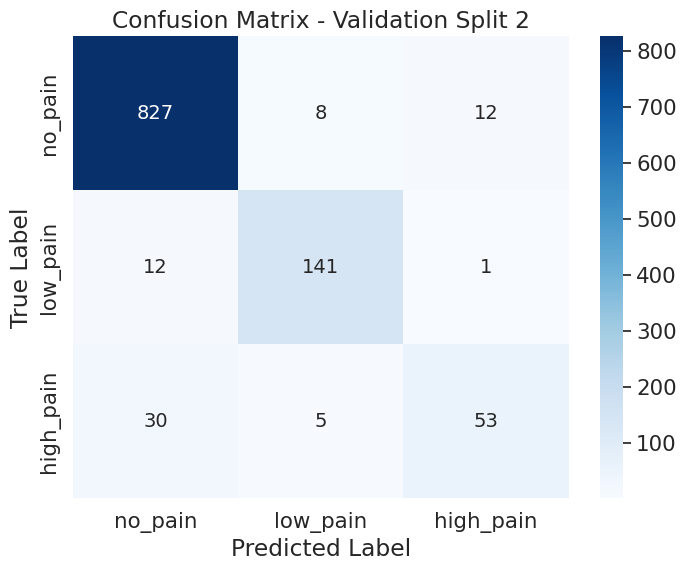

Split 3/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2113, F1 Score=0.3384 | Val: Loss=1.2858, F1 Score=0.6648
Epoch  50/10000 | Train: Loss=0.6646, F1 Score=0.9342 | Val: Loss=1.0522, F1 Score=0.9054
Epoch 100/10000 | Train: Loss=0.5946, F1 Score=0.9846 | Val: Loss=1.0265, F1 Score=0.9164
Epoch 150/10000 | Train: Loss=0.5584, F1 Score=0.9966 | Val: Loss=0.9693, F1 Score=0.9320
Epoch 200/10000 | Train: Loss=0.5701, F1 Score=0.9924 | Val: Loss=0.9342, F1 Score=0.9477
Epoch 250/10000 | Train: Loss=0.5568, F1 Score=1.0000 | Val: Loss=0.9185, F1 Score=0.9605
Early stopping triggered after 277 epochs.
Best model restored from epoch 177 with val_f1 0.9660

Saved confusion matrix plot to: 'models/hidden_layers_2_hidden_size_32/split_2/confusion_matrix_Validation_Split_3.png'


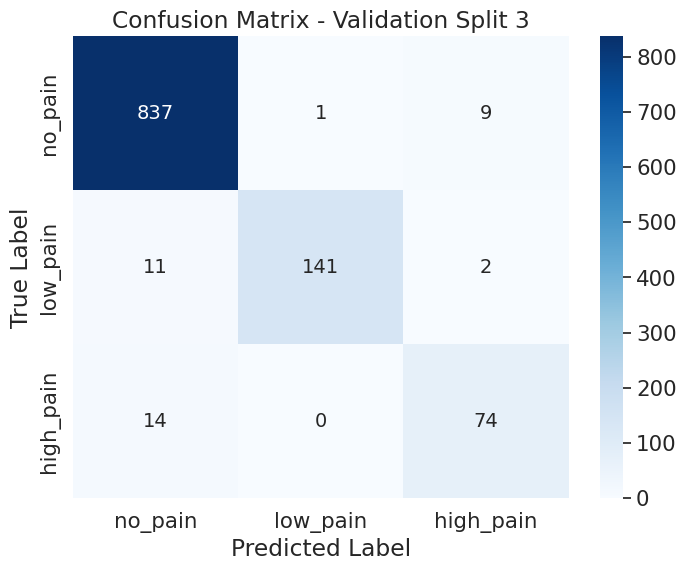

Split 4/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2064, F1 Score=0.3522 | Val: Loss=1.3334, F1 Score=0.3728
Epoch  50/10000 | Train: Loss=0.6121, F1 Score=0.9709 | Val: Loss=1.1869, F1 Score=0.8402
Epoch 100/10000 | Train: Loss=0.5843, F1 Score=0.9856 | Val: Loss=1.2237, F1 Score=0.8567
Epoch 150/10000 | Train: Loss=0.5692, F1 Score=0.9956 | Val: Loss=1.1732, F1 Score=0.8751
Early stopping triggered after 162 epochs.
Best model restored from epoch 62 with val_f1 0.8806

Saved confusion matrix plot to: 'models/hidden_layers_2_hidden_size_32/split_3/confusion_matrix_Validation_Split_4.png'


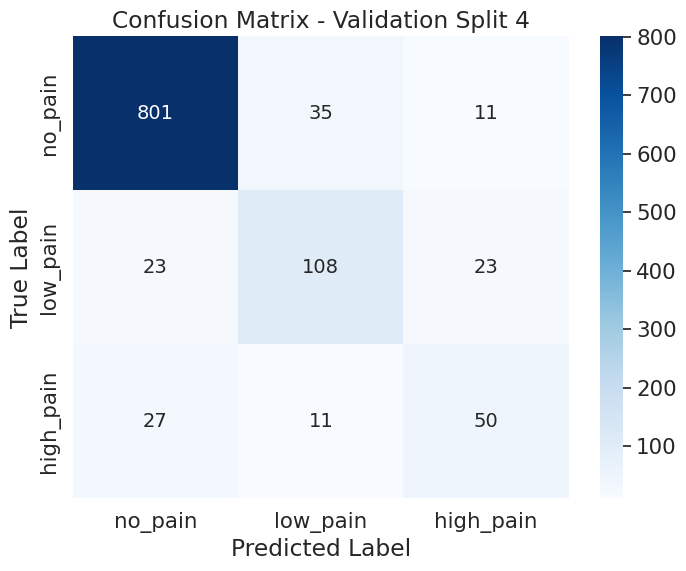

Split 5/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2166, F1 Score=0.2709 | Val: Loss=1.2701, F1 Score=0.4325
Epoch  50/10000 | Train: Loss=0.6162, F1 Score=0.9675 | Val: Loss=1.1770, F1 Score=0.8687
Epoch 100/10000 | Train: Loss=0.5794, F1 Score=0.9900 | Val: Loss=1.0868, F1 Score=0.8990
Epoch 150/10000 | Train: Loss=0.5759, F1 Score=0.9927 | Val: Loss=1.1159, F1 Score=0.9045
Epoch 200/10000 | Train: Loss=0.5528, F1 Score=1.0000 | Val: Loss=1.1455, F1 Score=0.8981
Epoch 250/10000 | Train: Loss=0.5587, F1 Score=0.9998 | Val: Loss=1.1131, F1 Score=0.9045
Epoch 300/10000 | Train: Loss=0.5641, F1 Score=0.9960 | Val: Loss=1.1757, F1 Score=0.8889
Early stopping triggered after 322 epochs.
Best model restored from epoch 222 with val_f1 0.9146

Saved confusion matrix plot to: 'models/hidden_layers_2_hidden_size_32/split_4/

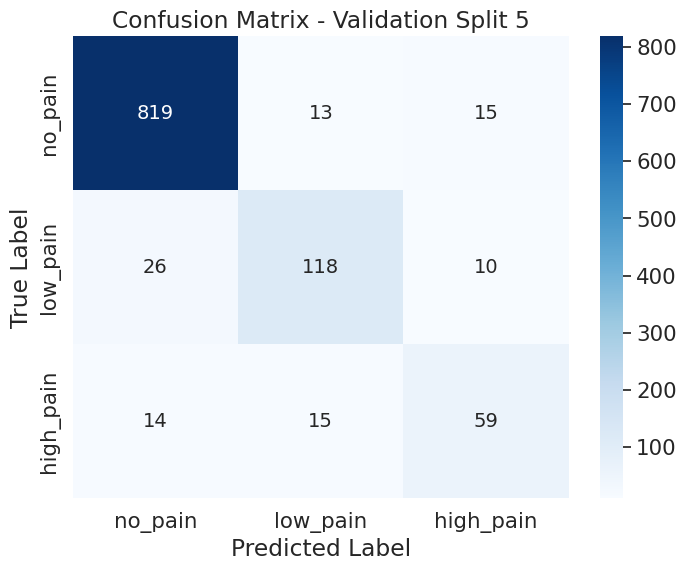

Best score: 0.9267±0.0283
  Experiment (split): hidden_layers_2_hidden_size_32/split_2
  F1 Score: 0.9267±0.0283

Configuration 5/9:
  hidden_layers: 2
  hidden_size: 64
Split 1/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.1736, F1 Score=0.4516 | Val: Loss=1.4086, F1 Score=0.4656
Epoch  50/10000 | Train: Loss=0.6057, F1 Score=0.9759 | Val: Loss=1.1041, F1 Score=0.9008
Epoch 100/10000 | Train: Loss=0.5847, F1 Score=0.9871 | Val: Loss=1.1313, F1 Score=0.8953
Epoch 150/10000 | Train: Loss=0.5650, F1 Score=0.9950 | Val: Loss=1.0447, F1 Score=0.9229
Early stopping triggered after 172 epochs.
Best model restored from epoch 72 with val_f1 0.9284

Saved confusion matrix plot to: 'models/hidden_layers_2_hidden_size_64/split_0/confusion_matrix_Validation_Split_1.png'


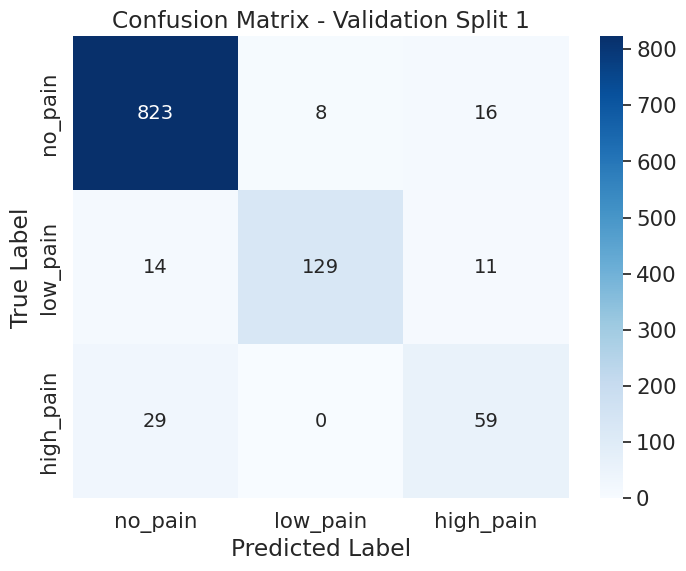

Split 2/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.1876, F1 Score=0.4337 | Val: Loss=1.3097, F1 Score=0.5243
Epoch  50/10000 | Train: Loss=0.6027, F1 Score=0.9672 | Val: Loss=1.0111, F1 Score=0.9275
Epoch 100/10000 | Train: Loss=0.5801, F1 Score=0.9861 | Val: Loss=1.0066, F1 Score=0.9082
Early stopping triggered after 139 epochs.
Best model restored from epoch 39 with val_f1 0.9504

Saved confusion matrix plot to: 'models/hidden_layers_2_hidden_size_64/split_1/confusion_matrix_Validation_Split_2.png'


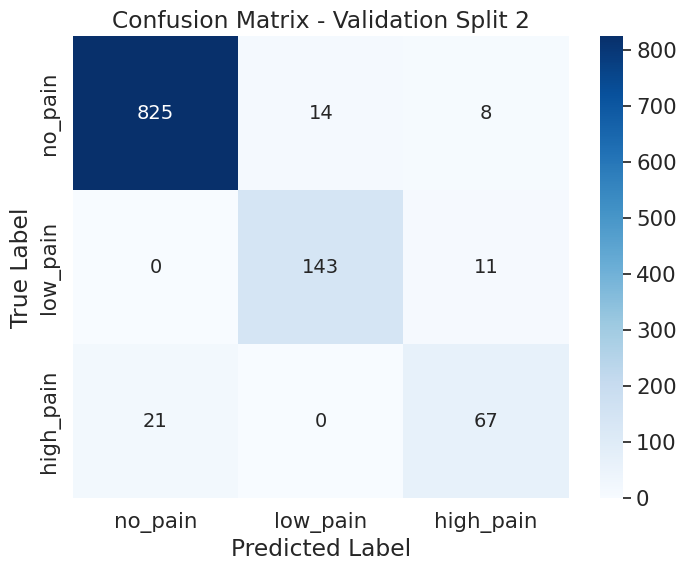

Split 3/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2033, F1 Score=0.3583 | Val: Loss=1.2745, F1 Score=0.7888
Epoch  50/10000 | Train: Loss=0.6156, F1 Score=0.9678 | Val: Loss=1.0337, F1 Score=0.8843
Epoch 100/10000 | Train: Loss=0.5836, F1 Score=0.9830 | Val: Loss=0.9135, F1 Score=0.9660
Epoch 150/10000 | Train: Loss=0.5845, F1 Score=0.9880 | Val: Loss=0.9432, F1 Score=0.9486
Early stopping triggered after 173 epochs.
Best model restored from epoch 73 with val_f1 0.9826

Saved confusion matrix plot to: 'models/hidden_layers_2_hidden_size_64/split_2/confusion_matrix_Validation_Split_3.png'


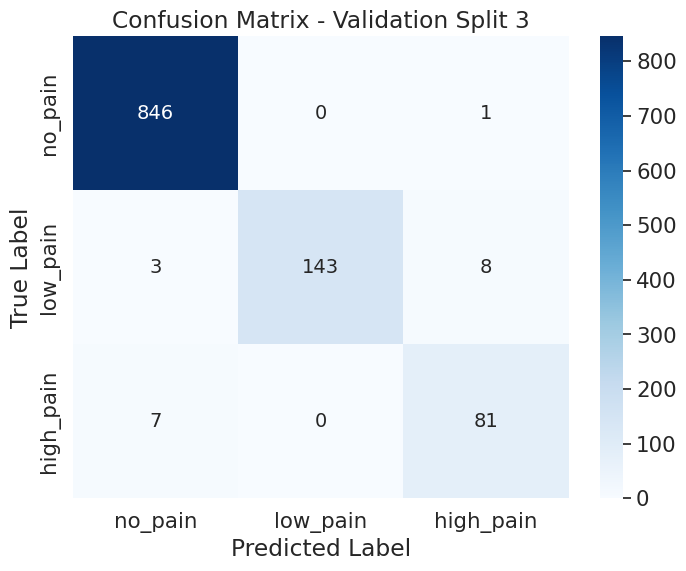

Split 4/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.1847, F1 Score=0.4340 | Val: Loss=1.3399, F1 Score=0.3085
Epoch  50/10000 | Train: Loss=0.6155, F1 Score=0.9685 | Val: Loss=1.2040, F1 Score=0.8393
Epoch 100/10000 | Train: Loss=0.5827, F1 Score=0.9885 | Val: Loss=1.2675, F1 Score=0.8512
Epoch 150/10000 | Train: Loss=0.5685, F1 Score=0.9950 | Val: Loss=1.2381, F1 Score=0.8558
Epoch 200/10000 | Train: Loss=0.5573, F1 Score=1.0000 | Val: Loss=1.1684, F1 Score=0.8880
Epoch 250/10000 | Train: Loss=0.5553, F1 Score=0.9992 | Val: Loss=1.1961, F1 Score=0.8779
Epoch 300/10000 | Train: Loss=0.5617, F1 Score=0.9973 | Val: Loss=1.1529, F1 Score=0.8907
Early stopping triggered after 321 epochs.
Best model restored from epoch 221 with val_f1 0.8972

Saved confusion matrix plot to: 'models/hidden_layers_2_hidden_size_64/split_3/

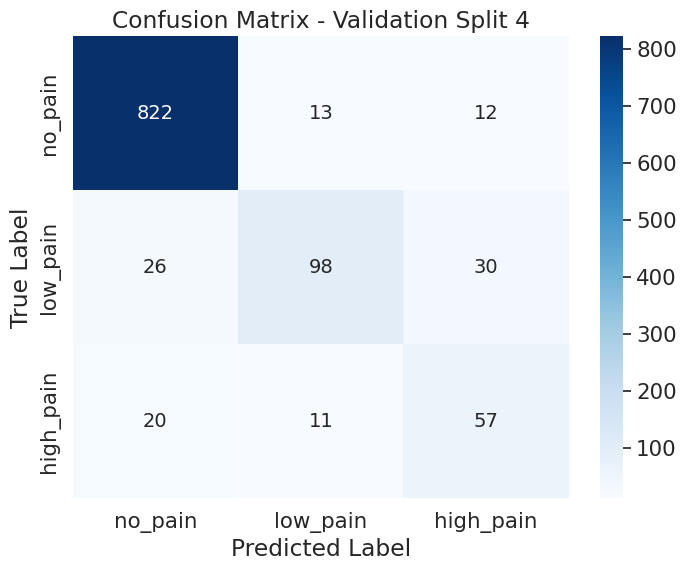

Split 5/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2057, F1 Score=0.3255 | Val: Loss=1.2320, F1 Score=0.7998
Epoch  50/10000 | Train: Loss=0.6161, F1 Score=0.9617 | Val: Loss=1.1479, F1 Score=0.8797
Epoch 100/10000 | Train: Loss=0.5868, F1 Score=0.9840 | Val: Loss=1.1065, F1 Score=0.8999
Epoch 150/10000 | Train: Loss=0.5676, F1 Score=0.9942 | Val: Loss=1.1694, F1 Score=0.8742
Epoch 200/10000 | Train: Loss=0.5563, F1 Score=1.0000 | Val: Loss=1.1465, F1 Score=0.8990
Early stopping triggered after 243 epochs.
Best model restored from epoch 143 with val_f1 0.9118

Saved confusion matrix plot to: 'models/hidden_layers_2_hidden_size_64/split_4/confusion_matrix_Validation_Split_5.png'


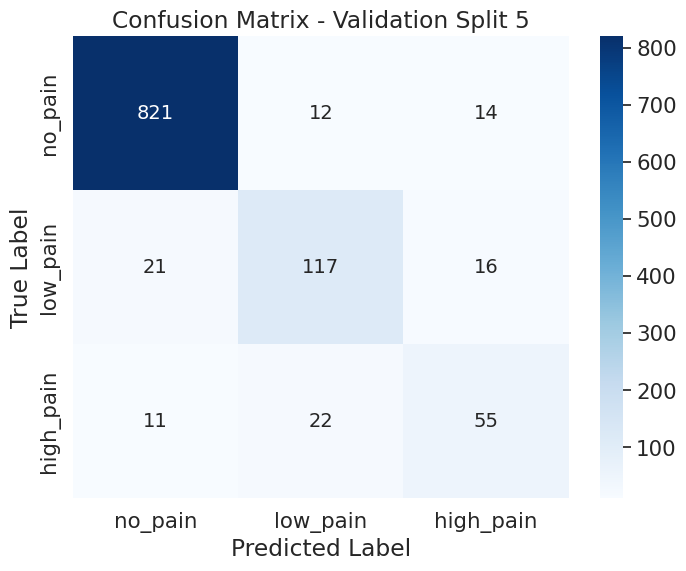

Best score: 0.9341±0.0300
🎉🎉🎉  NEW BEST SCORE! 🎉🎉🎉
  Experiment (split): hidden_layers_2_hidden_size_64/split_2
  F1 Score: 0.9341±0.0300

Configuration 6/9:
  hidden_layers: 2
  hidden_size: 128
Split 1/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.1946, F1 Score=0.4309 | Val: Loss=1.3551, F1 Score=0.6841
Epoch  50/10000 | Train: Loss=0.6095, F1 Score=0.9717 | Val: Loss=1.0290, F1 Score=0.9100
Epoch 100/10000 | Train: Loss=0.5790, F1 Score=0.9914 | Val: Loss=1.0116, F1 Score=0.9275
Epoch 150/10000 | Train: Loss=0.5603, F1 Score=0.9985 | Val: Loss=1.1472, F1 Score=0.8742
Epoch 200/10000 | Train: Loss=0.5686, F1 Score=0.9947 | Val: Loss=1.0341, F1 Score=0.9256
Epoch 250/10000 | Train: Loss=0.5597, F1 Score=0.9989 | Val: Loss=1.0722, F1 Score=0.9118
Early stopping triggered after 286 epochs.
Best model restored from epo

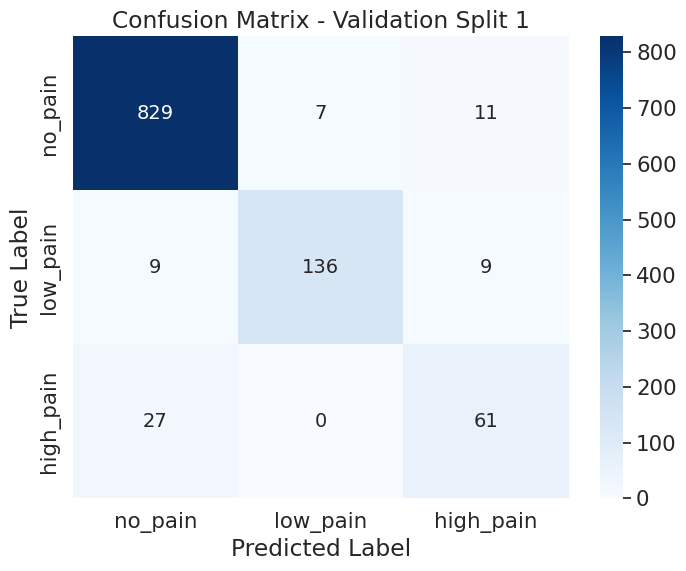

Split 2/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.1998, F1 Score=0.4393 | Val: Loss=1.2804, F1 Score=0.7245
Epoch  50/10000 | Train: Loss=0.6205, F1 Score=0.9612 | Val: Loss=0.9755, F1 Score=0.9357
Epoch 100/10000 | Train: Loss=0.5925, F1 Score=0.9882 | Val: Loss=0.9992, F1 Score=0.9357
Epoch 150/10000 | Train: Loss=0.5564, F1 Score=1.0000 | Val: Loss=0.9777, F1 Score=0.9385
Epoch 200/10000 | Train: Loss=0.5742, F1 Score=0.9922 | Val: Loss=0.9769, F1 Score=0.9348
Epoch 250/10000 | Train: Loss=0.5679, F1 Score=0.9963 | Val: Loss=0.9848, F1 Score=0.9311
Epoch 300/10000 | Train: Loss=0.5572, F1 Score=1.0000 | Val: Loss=0.9798, F1 Score=0.9394
Early stopping triggered after 312 epochs.
Best model restored from epoch 212 with val_f1 0.9504

Saved confusion matrix plot to: 'models/hidden_layers_2_hidden_size_128/split_1

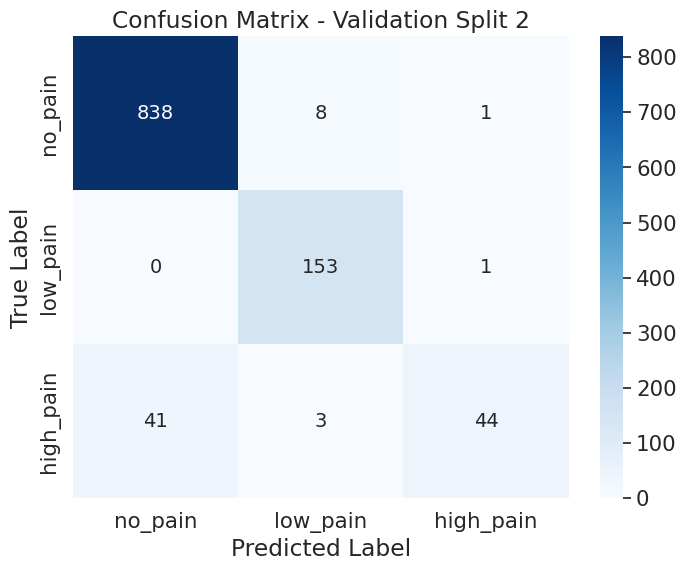

Split 3/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2016, F1 Score=0.3848 | Val: Loss=1.2944, F1 Score=0.7704
Epoch  50/10000 | Train: Loss=0.6309, F1 Score=0.9499 | Val: Loss=0.9748, F1 Score=0.9348
Epoch 100/10000 | Train: Loss=0.5700, F1 Score=0.9921 | Val: Loss=0.9198, F1 Score=0.9513
Epoch 150/10000 | Train: Loss=0.5706, F1 Score=0.9937 | Val: Loss=0.9472, F1 Score=0.9541
Epoch 200/10000 | Train: Loss=0.5657, F1 Score=0.9981 | Val: Loss=0.9589, F1 Score=0.9449
Early stopping triggered after 230 epochs.
Best model restored from epoch 130 with val_f1 0.9642

Saved confusion matrix plot to: 'models/hidden_layers_2_hidden_size_128/split_2/confusion_matrix_Validation_Split_3.png'


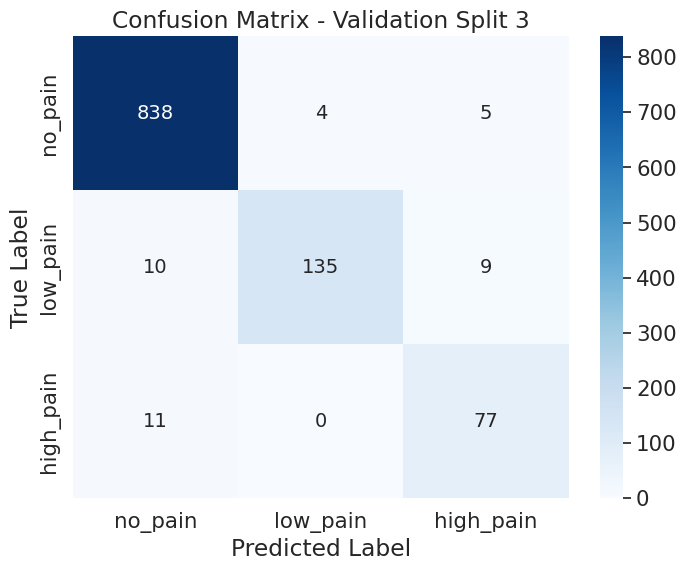

Split 4/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2002, F1 Score=0.3999 | Val: Loss=1.3178, F1 Score=0.6152
Epoch  50/10000 | Train: Loss=0.6294, F1 Score=0.9659 | Val: Loss=1.1678, F1 Score=0.8531
Epoch 100/10000 | Train: Loss=0.5775, F1 Score=0.9918 | Val: Loss=1.2017, F1 Score=0.8742
Epoch 150/10000 | Train: Loss=0.5617, F1 Score=0.9979 | Val: Loss=1.2183, F1 Score=0.8659
Epoch 200/10000 | Train: Loss=0.6514, F1 Score=0.9536 | Val: Loss=1.2481, F1 Score=0.8577
Epoch 250/10000 | Train: Loss=0.5562, F1 Score=1.0000 | Val: Loss=1.2166, F1 Score=0.8724
Early stopping triggered after 252 epochs.
Best model restored from epoch 152 with val_f1 0.8953

Saved confusion matrix plot to: 'models/hidden_layers_2_hidden_size_128/split_3/confusion_matrix_Validation_Split_4.png'


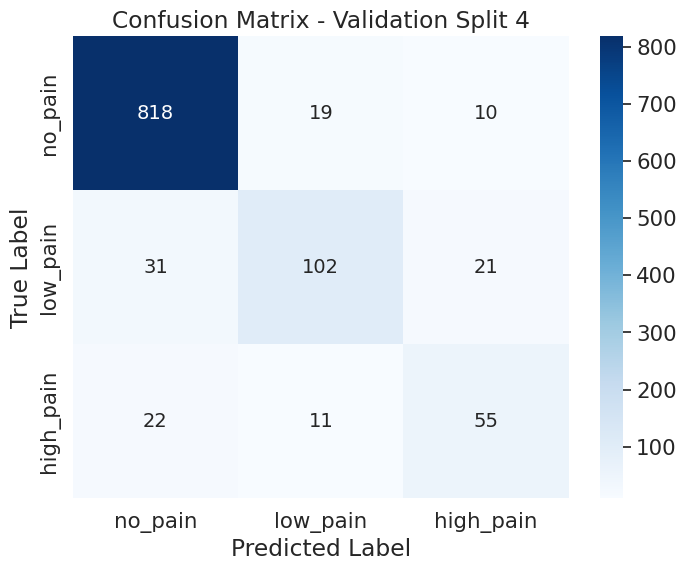

Split 5/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.1923, F1 Score=0.4678 | Val: Loss=1.2203, F1 Score=0.7291
Epoch  50/10000 | Train: Loss=0.6204, F1 Score=0.9686 | Val: Loss=1.1030, F1 Score=0.9082
Epoch 100/10000 | Train: Loss=0.5713, F1 Score=0.9914 | Val: Loss=1.0700, F1 Score=0.9155
Epoch 150/10000 | Train: Loss=0.5547, F1 Score=1.0000 | Val: Loss=1.0868, F1 Score=0.9091
Early stopping triggered after 196 epochs.
Best model restored from epoch 96 with val_f1 0.9183

Saved confusion matrix plot to: 'models/hidden_layers_2_hidden_size_128/split_4/confusion_matrix_Validation_Split_5.png'


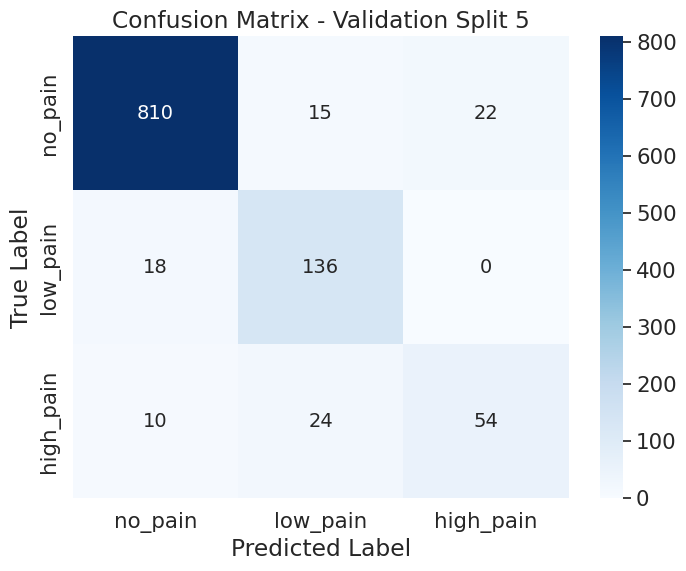

Best score: 0.9341±0.0245
  Experiment (split): hidden_layers_2_hidden_size_128/split_2
  F1 Score: 0.9341±0.0245

Configuration 7/9:
  hidden_layers: 3
  hidden_size: 32
Split 1/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.1969, F1 Score=0.3640 | Val: Loss=1.3917, F1 Score=0.2433
Epoch  50/10000 | Train: Loss=0.6188, F1 Score=0.9694 | Val: Loss=1.1456, F1 Score=0.8834
Epoch 100/10000 | Train: Loss=0.5835, F1 Score=0.9879 | Val: Loss=1.0967, F1 Score=0.9100
Epoch 150/10000 | Train: Loss=0.5763, F1 Score=0.9913 | Val: Loss=1.1131, F1 Score=0.8981
Epoch 200/10000 | Train: Loss=0.5626, F1 Score=0.9971 | Val: Loss=1.0363, F1 Score=0.9219
Epoch 250/10000 | Train: Loss=0.5568, F1 Score=1.0000 | Val: Loss=1.0803, F1 Score=0.9164
Epoch 300/10000 | Train: Loss=0.5591, F1 Score=1.0000 | Val: Loss=1.0639, F1 Score=0.9238
Early 

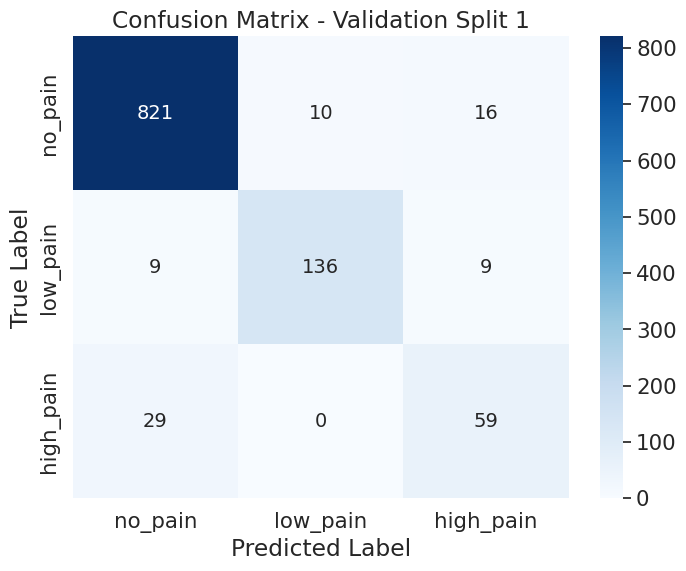

Split 2/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2010, F1 Score=0.4267 | Val: Loss=1.2855, F1 Score=0.6171
Epoch  50/10000 | Train: Loss=0.6125, F1 Score=0.9644 | Val: Loss=0.9478, F1 Score=0.9385
Epoch 100/10000 | Train: Loss=0.5761, F1 Score=0.9875 | Val: Loss=1.0519, F1 Score=0.9210
Epoch 150/10000 | Train: Loss=0.5903, F1 Score=0.9874 | Val: Loss=1.0417, F1 Score=0.9256
Early stopping triggered after 151 epochs.
Best model restored from epoch 51 with val_f1 0.9522

Saved confusion matrix plot to: 'models/hidden_layers_3_hidden_size_32/split_1/confusion_matrix_Validation_Split_2.png'


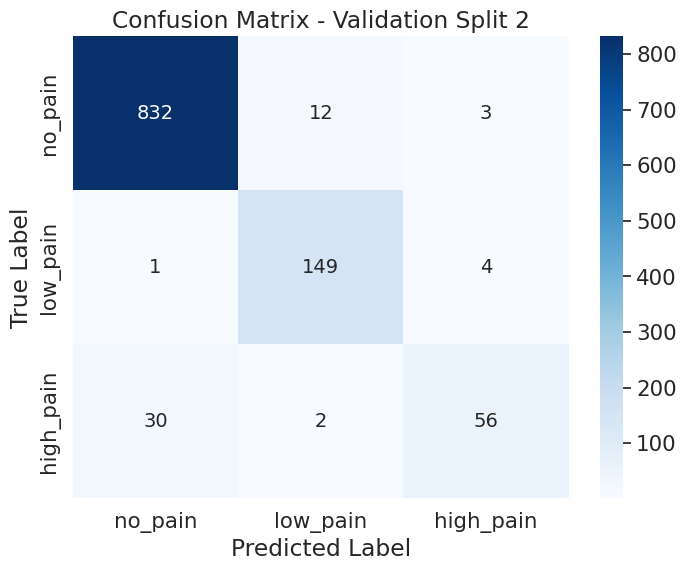

Split 3/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2290, F1 Score=0.1863 | Val: Loss=1.3148, F1 Score=0.7631
Epoch  50/10000 | Train: Loss=0.6170, F1 Score=0.9678 | Val: Loss=0.9807, F1 Score=0.9376
Epoch 100/10000 | Train: Loss=0.5698, F1 Score=0.9926 | Val: Loss=0.9592, F1 Score=0.9357
Epoch 150/10000 | Train: Loss=0.5672, F1 Score=0.9945 | Val: Loss=0.9278, F1 Score=0.9532
Epoch 200/10000 | Train: Loss=0.5619, F1 Score=0.9984 | Val: Loss=0.9979, F1 Score=0.9412
Early stopping triggered after 249 epochs.
Best model restored from epoch 149 with val_f1 0.9633

Saved confusion matrix plot to: 'models/hidden_layers_3_hidden_size_32/split_2/confusion_matrix_Validation_Split_3.png'


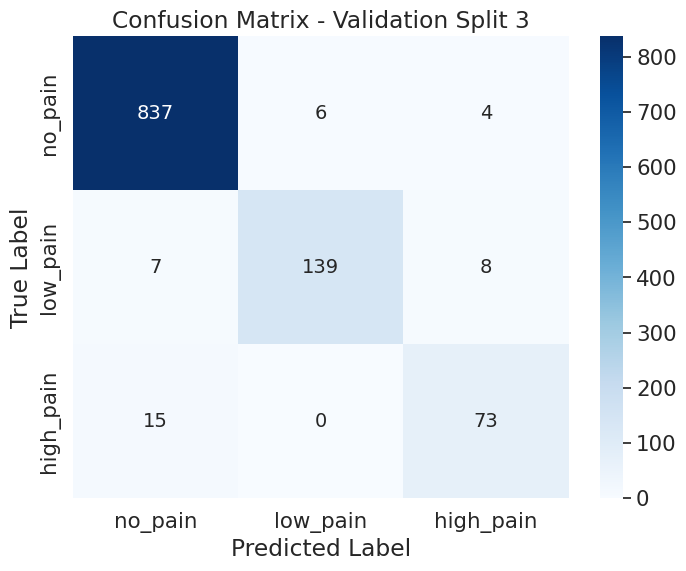

Split 4/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2208, F1 Score=0.3174 | Val: Loss=1.3632, F1 Score=0.4435
Epoch  50/10000 | Train: Loss=0.6207, F1 Score=0.9743 | Val: Loss=1.2271, F1 Score=0.8613
Epoch 100/10000 | Train: Loss=0.5795, F1 Score=0.9901 | Val: Loss=1.1496, F1 Score=0.8889
Epoch 150/10000 | Train: Loss=0.5790, F1 Score=0.9929 | Val: Loss=1.1800, F1 Score=0.8843
Early stopping triggered after 173 epochs.
Best model restored from epoch 73 with val_f1 0.8981

Saved confusion matrix plot to: 'models/hidden_layers_3_hidden_size_32/split_3/confusion_matrix_Validation_Split_4.png'


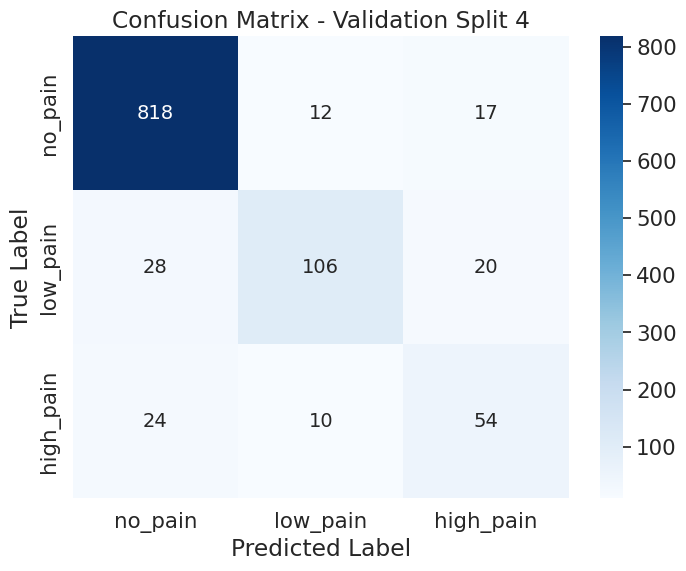

Split 5/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2246, F1 Score=0.2210 | Val: Loss=1.4125, F1 Score=0.4343
Epoch  50/10000 | Train: Loss=0.6076, F1 Score=0.9753 | Val: Loss=1.1691, F1 Score=0.8705
Epoch 100/10000 | Train: Loss=0.5729, F1 Score=0.9926 | Val: Loss=1.1114, F1 Score=0.8953
Epoch 150/10000 | Train: Loss=0.6258, F1 Score=0.9707 | Val: Loss=1.1814, F1 Score=0.8760
Early stopping triggered after 195 epochs.
Best model restored from epoch 95 with val_f1 0.9155

Saved confusion matrix plot to: 'models/hidden_layers_3_hidden_size_32/split_4/confusion_matrix_Validation_Split_5.png'


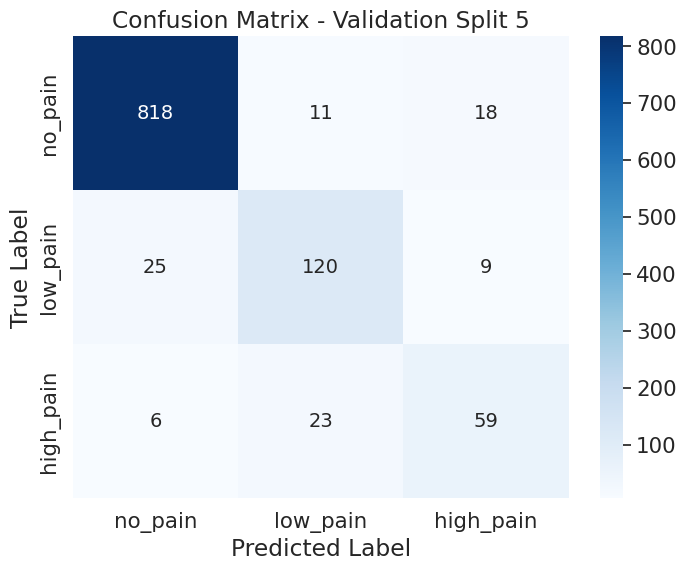

Best score: 0.9324±0.0237
  Experiment (split): hidden_layers_3_hidden_size_32/split_2
  F1 Score: 0.9324±0.0237

Configuration 8/9:
  hidden_layers: 3
  hidden_size: 64
Split 1/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2084, F1 Score=0.3827 | Val: Loss=1.3532, F1 Score=0.7254
Epoch  50/10000 | Train: Loss=0.6248, F1 Score=0.9670 | Val: Loss=1.2238, F1 Score=0.8393
Epoch 100/10000 | Train: Loss=0.5794, F1 Score=0.9908 | Val: Loss=1.0587, F1 Score=0.9164
Epoch 150/10000 | Train: Loss=0.5710, F1 Score=0.9955 | Val: Loss=1.1060, F1 Score=0.8972
Epoch 200/10000 | Train: Loss=0.5575, F1 Score=1.0000 | Val: Loss=1.0108, F1 Score=0.9330
Epoch 250/10000 | Train: Loss=0.5558, F1 Score=1.0000 | Val: Loss=1.0560, F1 Score=0.9201
Early stopping triggered after 289 epochs.
Best model restored from epoch 189 with val_f1 0.9394


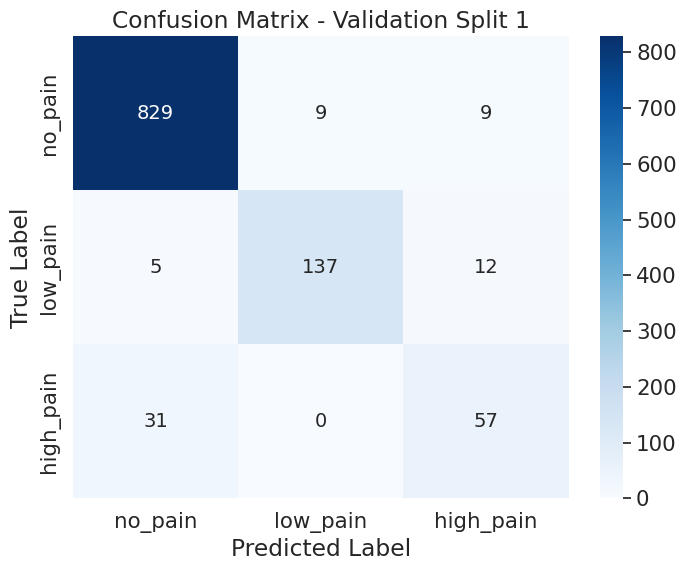

Split 2/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2038, F1 Score=0.4071 | Val: Loss=1.3097, F1 Score=0.6520
Epoch  50/10000 | Train: Loss=0.6153, F1 Score=0.9625 | Val: Loss=1.1105, F1 Score=0.8981
Epoch 100/10000 | Train: Loss=0.5900, F1 Score=0.9872 | Val: Loss=1.0169, F1 Score=0.9219
Epoch 150/10000 | Train: Loss=0.5704, F1 Score=0.9955 | Val: Loss=1.0180, F1 Score=0.9265
Epoch 200/10000 | Train: Loss=0.6294, F1 Score=0.9753 | Val: Loss=1.0616, F1 Score=0.9027
Early stopping triggered after 219 epochs.
Best model restored from epoch 119 with val_f1 0.9458

Saved confusion matrix plot to: 'models/hidden_layers_3_hidden_size_64/split_1/confusion_matrix_Validation_Split_2.png'


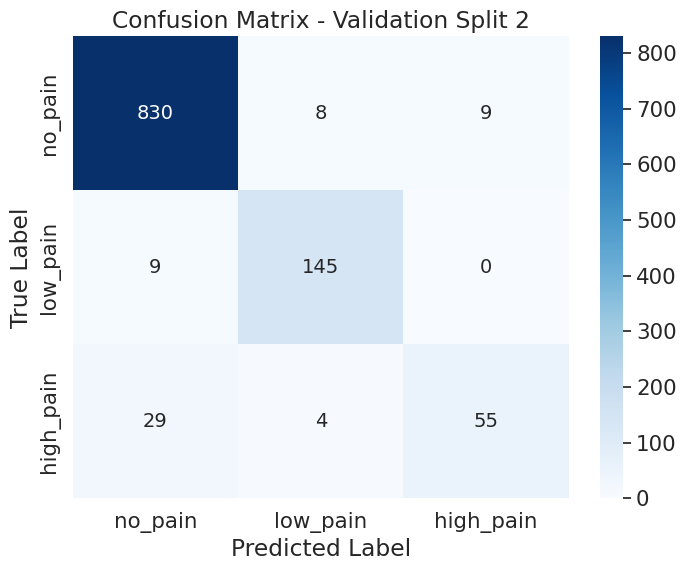

Split 3/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2001, F1 Score=0.4073 | Val: Loss=1.2966, F1 Score=0.6988
Epoch  50/10000 | Train: Loss=0.6217, F1 Score=0.9557 | Val: Loss=1.1260, F1 Score=0.8962
Epoch 100/10000 | Train: Loss=0.5816, F1 Score=0.9900 | Val: Loss=0.9542, F1 Score=0.9449
Epoch 150/10000 | Train: Loss=0.6577, F1 Score=0.9620 | Val: Loss=0.9685, F1 Score=0.9146
Early stopping triggered after 174 epochs.
Best model restored from epoch 74 with val_f1 0.9669

Saved confusion matrix plot to: 'models/hidden_layers_3_hidden_size_64/split_2/confusion_matrix_Validation_Split_3.png'


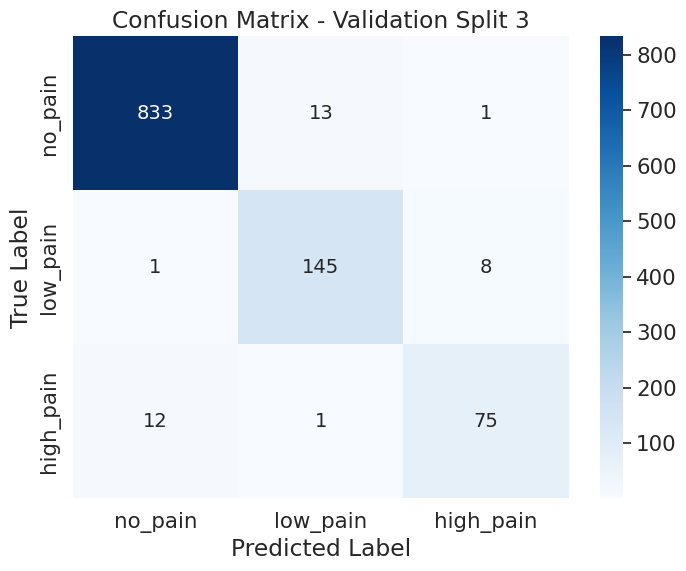

Split 4/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.1925, F1 Score=0.4573 | Val: Loss=1.3523, F1 Score=0.2415
Epoch  50/10000 | Train: Loss=0.6129, F1 Score=0.9762 | Val: Loss=1.2209, F1 Score=0.8595
Epoch 100/10000 | Train: Loss=0.5816, F1 Score=0.9914 | Val: Loss=1.2173, F1 Score=0.8567
Epoch 150/10000 | Train: Loss=0.5531, F1 Score=0.9977 | Val: Loss=1.2194, F1 Score=0.8632
Epoch 200/10000 | Train: Loss=0.5678, F1 Score=0.9939 | Val: Loss=1.2094, F1 Score=0.8705
Early stopping triggered after 211 epochs.
Best model restored from epoch 111 with val_f1 0.8953

Saved confusion matrix plot to: 'models/hidden_layers_3_hidden_size_64/split_3/confusion_matrix_Validation_Split_4.png'


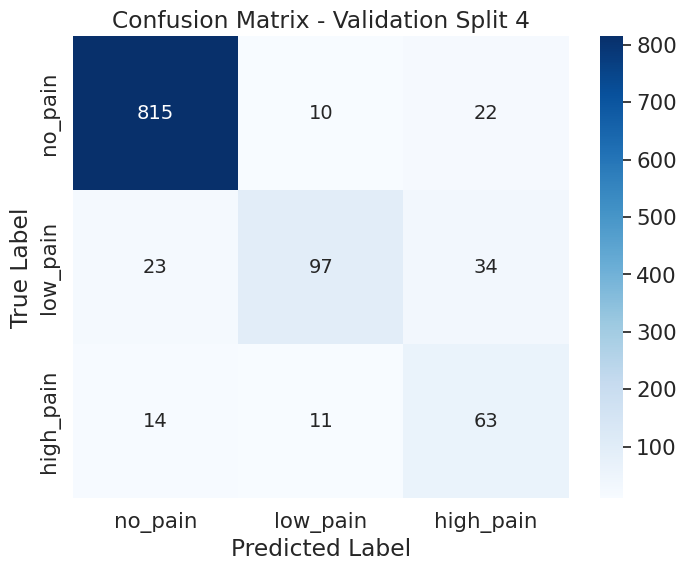

Split 5/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2086, F1 Score=0.3599 | Val: Loss=1.2559, F1 Score=0.6088
Epoch  50/10000 | Train: Loss=0.6162, F1 Score=0.9668 | Val: Loss=1.1203, F1 Score=0.8650
Epoch 100/10000 | Train: Loss=0.5708, F1 Score=0.9863 | Val: Loss=1.1564, F1 Score=0.8788
Epoch 150/10000 | Train: Loss=0.5736, F1 Score=0.9937 | Val: Loss=1.0886, F1 Score=0.8926
Epoch 200/10000 | Train: Loss=0.5546, F1 Score=1.0000 | Val: Loss=1.1501, F1 Score=0.8935
Epoch 250/10000 | Train: Loss=0.5588, F1 Score=1.0000 | Val: Loss=1.2982, F1 Score=0.8678
Early stopping triggered after 280 epochs.
Best model restored from epoch 180 with val_f1 0.9128

Saved confusion matrix plot to: 'models/hidden_layers_3_hidden_size_64/split_4/confusion_matrix_Validation_Split_5.png'


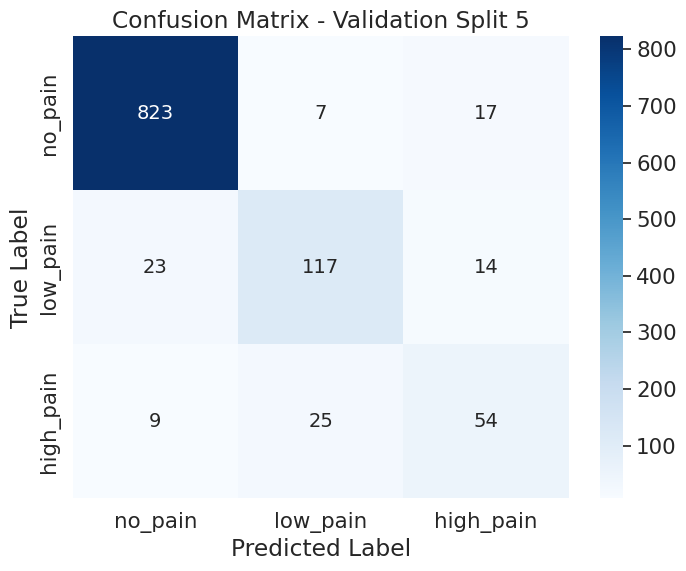

Best score: 0.9320±0.0252
  Experiment (split): hidden_layers_3_hidden_size_64/split_2
  F1 Score: 0.9320±0.0252

Configuration 9/9:
  hidden_layers: 3
  hidden_size: 128
Split 1/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2036, F1 Score=0.4562 | Val: Loss=1.3939, F1 Score=0.4077
Epoch  50/10000 | Train: Loss=0.6298, F1 Score=0.9673 | Val: Loss=1.0916, F1 Score=0.8926
Epoch 100/10000 | Train: Loss=0.5686, F1 Score=0.9913 | Val: Loss=1.0306, F1 Score=0.9219
Epoch 150/10000 | Train: Loss=0.5636, F1 Score=0.9963 | Val: Loss=1.0856, F1 Score=0.9146
Epoch 200/10000 | Train: Loss=0.5534, F1 Score=1.0000 | Val: Loss=1.0574, F1 Score=0.9201
Epoch 250/10000 | Train: Loss=0.5552, F1 Score=1.0000 | Val: Loss=1.0487, F1 Score=0.9192
Early stopping triggered after 260 epochs.
Best model restored from epoch 160 with val_f1 0.9403

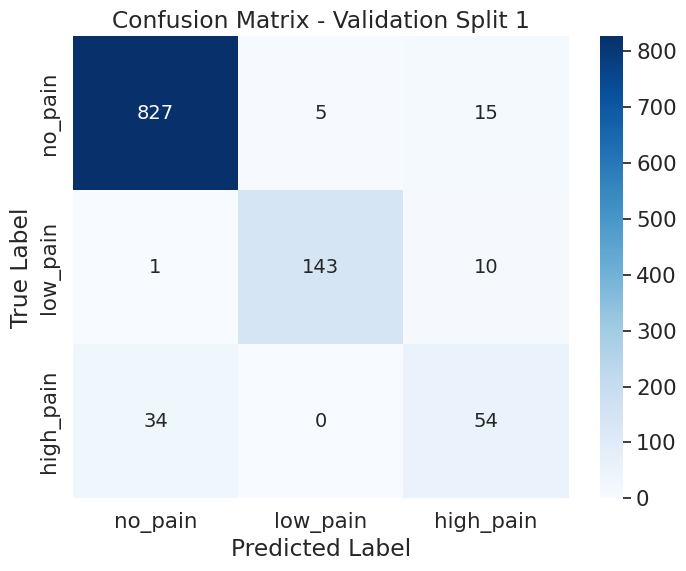

Split 2/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2115, F1 Score=0.3834 | Val: Loss=1.5556, F1 Score=0.0817
Epoch  50/10000 | Train: Loss=0.6177, F1 Score=0.9609 | Val: Loss=0.9462, F1 Score=0.9412
Epoch 100/10000 | Train: Loss=0.5710, F1 Score=0.9947 | Val: Loss=1.0652, F1 Score=0.9155
Epoch 150/10000 | Train: Loss=0.6310, F1 Score=0.9664 | Val: Loss=0.9550, F1 Score=0.9385
Early stopping triggered after 174 epochs.
Best model restored from epoch 74 with val_f1 0.9495

Saved confusion matrix plot to: 'models/hidden_layers_3_hidden_size_128/split_1/confusion_matrix_Validation_Split_2.png'


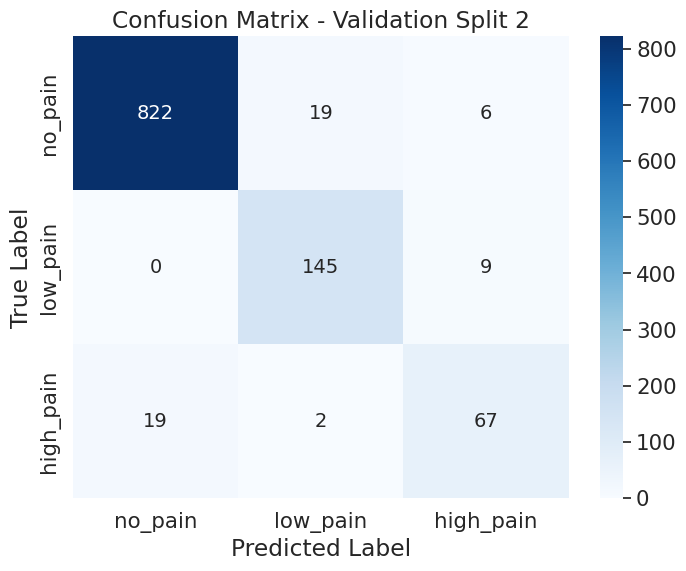

Split 3/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2030, F1 Score=0.4914 | Val: Loss=1.3268, F1 Score=0.5556
Epoch  50/10000 | Train: Loss=0.6525, F1 Score=0.9596 | Val: Loss=0.9390, F1 Score=0.9495
Epoch 100/10000 | Train: Loss=0.5965, F1 Score=0.9814 | Val: Loss=1.0090, F1 Score=0.9394
Epoch 150/10000 | Train: Loss=0.5782, F1 Score=0.9905 | Val: Loss=0.9894, F1 Score=0.9348
Epoch 200/10000 | Train: Loss=0.5570, F1 Score=1.0000 | Val: Loss=0.9450, F1 Score=0.9513
Epoch 250/10000 | Train: Loss=0.5580, F1 Score=1.0000 | Val: Loss=0.9202, F1 Score=0.9605
Early stopping triggered after 288 epochs.
Best model restored from epoch 188 with val_f1 0.9669

Saved confusion matrix plot to: 'models/hidden_layers_3_hidden_size_128/split_2/confusion_matrix_Validation_Split_3.png'


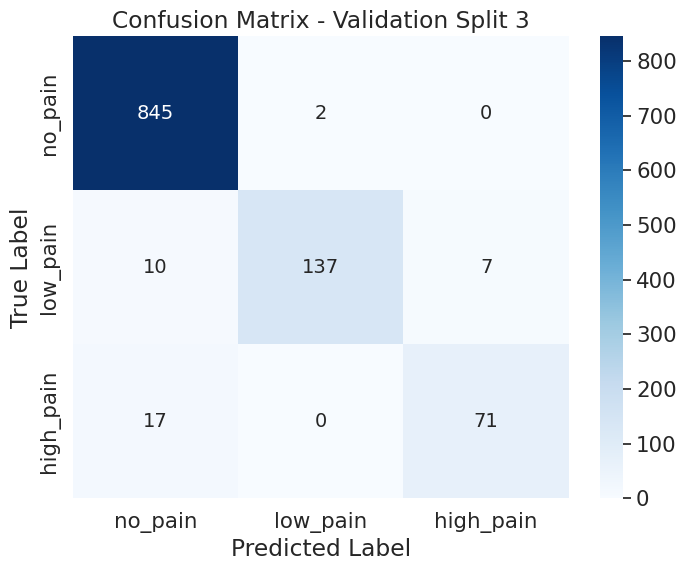

Split 4/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2218, F1 Score=0.3133 | Val: Loss=1.2935, F1 Score=0.7420
Epoch  50/10000 | Train: Loss=0.6203, F1 Score=0.9686 | Val: Loss=1.5659, F1 Score=0.6951
Epoch 100/10000 | Train: Loss=0.5635, F1 Score=0.9948 | Val: Loss=1.2216, F1 Score=0.8678
Epoch 150/10000 | Train: Loss=0.5576, F1 Score=0.9984 | Val: Loss=1.2736, F1 Score=0.8549
Epoch 200/10000 | Train: Loss=0.5699, F1 Score=0.9958 | Val: Loss=1.2204, F1 Score=0.8714
Early stopping triggered after 202 epochs.
Best model restored from epoch 102 with val_f1 0.8871

Saved confusion matrix plot to: 'models/hidden_layers_3_hidden_size_128/split_3/confusion_matrix_Validation_Split_4.png'


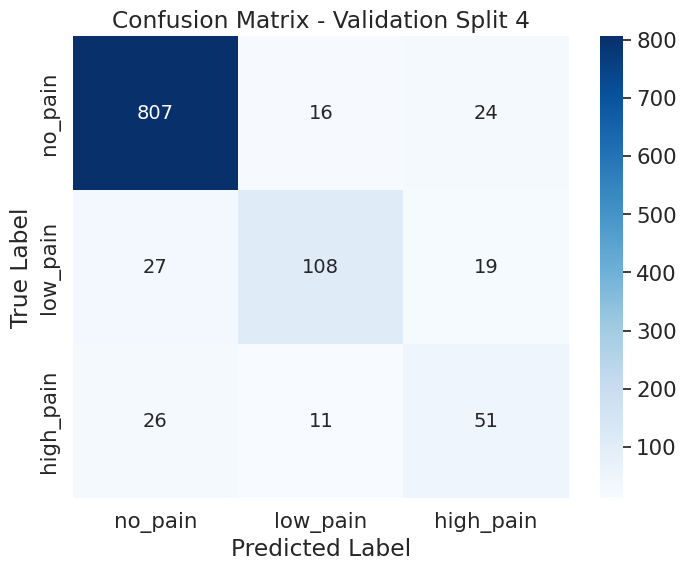

Split 5/5
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2300, F1 Score=0.2630 | Val: Loss=1.2571, F1 Score=0.8108
Epoch  50/10000 | Train: Loss=0.6111, F1 Score=0.9662 | Val: Loss=1.2872, F1 Score=0.8044
Epoch 100/10000 | Train: Loss=0.5777, F1 Score=0.9900 | Val: Loss=1.1734, F1 Score=0.8705
Epoch 150/10000 | Train: Loss=0.5637, F1 Score=0.9989 | Val: Loss=1.1207, F1 Score=0.8898
Early stopping triggered after 194 epochs.
Best model restored from epoch 94 with val_f1 0.9073

Saved confusion matrix plot to: 'models/hidden_layers_3_hidden_size_128/split_4/confusion_matrix_Validation_Split_5.png'


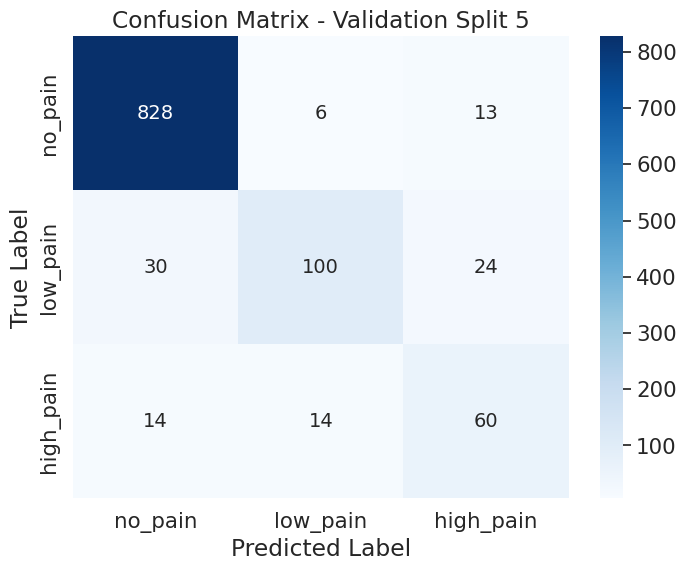

Best score: 0.9302±0.0290
  Experiment (split): hidden_layers_3_hidden_size_128/split_2
  F1 Score: 0.9302±0.0290
CPU times: user 7h 50min 7s, sys: 1h 12min 52s, total: 9h 2min 59s
Wall time: 8h 38min 57s


In [86]:
# @title Run
%%time
# Define parameters to search
param_grid = {
    'hidden_layers': [1, 2, 3],
    'hidden_size': [32, 64, 128],
}

# Fixed hyperparameters (not being tuned)
fixed_params = {
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'dropout_rate': DROPOUT_RATE,
    'l1_lambda': L1_LAMBDA,
    'l2_lambda': L2_LAMBDA,
    'window_size': WINDOW_SIZE,
    'stride': STRIDE,
    'rnn_type': RNN_TYPE,
    'bidirectional': BIDIRECTIONAL
}

# Cross-validation settings
cv_params = {
    'epochs': EPOCHS,
    'criterion': criterion,
    'device': device,
    'k': K,
    'test_size': VAL_SIZE,
    'patience': PATIENCE,
    'verbose': 50,
    'seed': SEED
}


# Execute search
results, best_config, best_score, best_experiment_name = grid_search_cv_rnn(
    df=df_features,
    df_labels=df_labels,
    param_grid=param_grid,
    fixed_params=fixed_params,
    cv_params=cv_params
)

final_best_params = {**fixed_params, **best_config}
# the actual split with the best results
# -- best_experiment_name = "_".join([f"{k}_{v}" for k, v in best_config.items()])

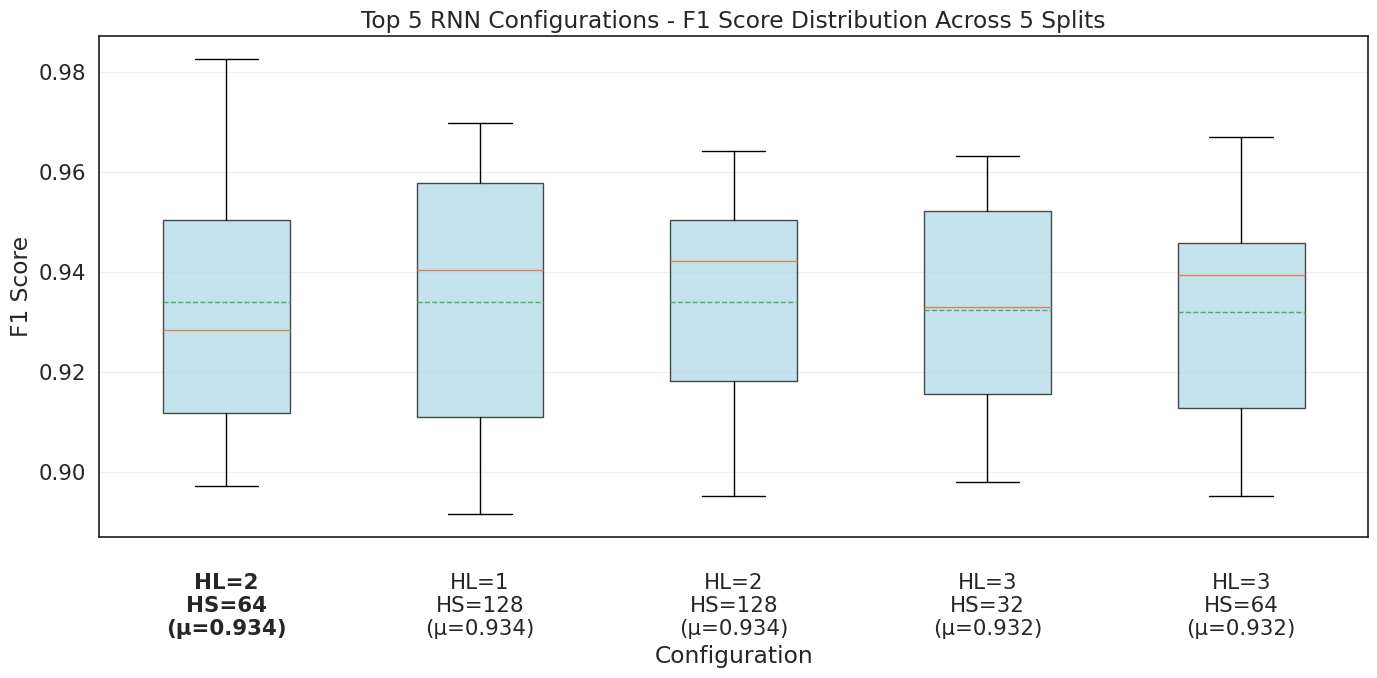

<Figure size 640x480 with 0 Axes>

In [87]:
# @title Plot results
# Visualise results
plot_top_configurations_rnn(results, k_splits=K, top_n=5)

---
## ❌ **4. Run without bidirectionality...**
> Bidirectional option to false. </br>
> `Best score: 0.9495±0.0105`. Minor underfitting.

In [118]:
# @title Configuration
# Cross-validation
K = 3                    # Number of splits (5 and 10 are considered good values)
VAL_SIZE = 99            # Size or fraction for validation splits

# Training
EPOCHS = 10000           # Maximum epochs (increase to improve performance)
PATIENCE = 100           # Early stopping patience (increase to improve performance)
VERBOSE = 10             # Print frequency

# Optimisation
LEARNING_RATE = 1e-3     # Learning rate
BATCH_SIZE = 32          # Batch size
WINDOW_SIZE = 50         # Input window size
STRIDE = 10               # Input stride

# Architecture
HIDDEN_LAYERS = 2        # Hidden layers
HIDDEN_SIZE = 64         # Neurons per layer
RNN_TYPE = 'LSTM'        # Type of RNN architecture
BIDIRECTIONAL = False     # Bidirectional RNN

# Regularisation
DROPOUT_RATE = 0.2       # Dropout probability
L1_LAMBDA = 0            # L1 penalty
L2_LAMBDA = 1e-4         # L2 penalty

# Loss function
ALPHA = 0.1              # Smoothing applied on the loss (between 0 and 1)
CLASS_WEIGHTS_LIST = [0.43, 2.32, 4.0]
CLASS_WEIGHTS = torch.tensor(CLASS_WEIGHTS_LIST, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=ALPHA, weight=CLASS_WEIGHTS)


# Experiment name
base_experiment_name = f'{str(datetime.now())}_vol-trend_lstm_v4_unidir'
print(f"Experiment: {base_experiment_name}")

# Setup TensorBoard writer
writer = SummaryWriter("./"+logs_dir+"/"+base_experiment_name)

# Initialize best model tracking variables
best_model = None
best_experiment_name = None
best_performance = float('-inf')

Experiment: 2025-11-13 23:33:07.236983_vol-trend_lstm_v4_unidir


Split 1/3
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2010, F1 Score=0.3374 | Val: Loss=1.3710, F1 Score=0.5813
Epoch  10/10000 | Train: Loss=0.9318, F1 Score=0.8225 | Val: Loss=1.3233, F1 Score=0.7062
Epoch  20/10000 | Train: Loss=0.7958, F1 Score=0.8945 | Val: Loss=1.1893, F1 Score=0.8476
Epoch  30/10000 | Train: Loss=0.6894, F1 Score=0.9429 | Val: Loss=1.1000, F1 Score=0.8981
Epoch  40/10000 | Train: Loss=0.6408, F1 Score=0.9625 | Val: Loss=1.0950, F1 Score=0.8907
Epoch  50/10000 | Train: Loss=0.6441, F1 Score=0.9660 | Val: Loss=1.1338, F1 Score=0.8889
Epoch  60/10000 | Train: Loss=0.6067, F1 Score=0.9725 | Val: Loss=1.1235, F1 Score=0.8760
Epoch  70/10000 | Train: Loss=0.5974, F1 Score=0.9837 | Val: Loss=1.0940, F1 Score=0.9082
Epoch  80/10000 | Train: Loss=0.5956, F1 Score=0.9832 | Val: Loss=1.1229, F1 Score=0.90

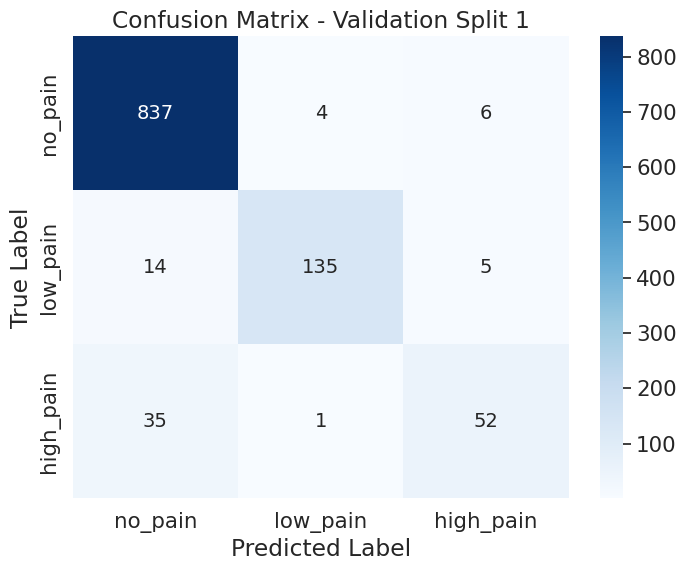

Split 2/3
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2154, F1 Score=0.3450 | Val: Loss=1.3359, F1 Score=0.1754
Epoch  10/10000 | Train: Loss=0.9584, F1 Score=0.7839 | Val: Loss=1.1427, F1 Score=0.8669
Epoch  20/10000 | Train: Loss=0.8355, F1 Score=0.8447 | Val: Loss=1.1048, F1 Score=0.8081
Epoch  30/10000 | Train: Loss=0.7089, F1 Score=0.9046 | Val: Loss=1.0996, F1 Score=0.8558
Epoch  40/10000 | Train: Loss=0.6850, F1 Score=0.9306 | Val: Loss=1.0966, F1 Score=0.9100
Epoch  50/10000 | Train: Loss=0.6529, F1 Score=0.9424 | Val: Loss=1.0754, F1 Score=0.8338
Epoch  60/10000 | Train: Loss=0.6416, F1 Score=0.9520 | Val: Loss=1.0766, F1 Score=0.9146
Epoch  70/10000 | Train: Loss=0.6212, F1 Score=0.9646 | Val: Loss=1.1094, F1 Score=0.8632
Epoch  80/10000 | Train: Loss=0.6160, F1 Score=0.9702 | Val: Loss=1.0177, F1 Score=0.91

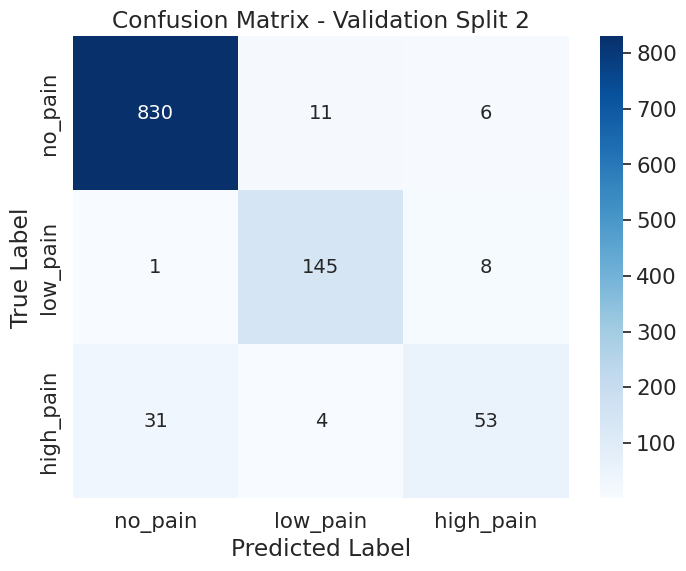

Split 3/3
  Training set shape: (73060, 96)
  Validation set shape: (12870, 96)
  Training sequences shape: (6182, 50, 94)
  Validation sequences shape: (1089, 50, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2087, F1 Score=0.2852 | Val: Loss=1.3474, F1 Score=0.5840
Epoch  10/10000 | Train: Loss=0.9455, F1 Score=0.8127 | Val: Loss=1.2438, F1 Score=0.5941
Epoch  20/10000 | Train: Loss=0.8046, F1 Score=0.8539 | Val: Loss=1.1181, F1 Score=0.8219
Epoch  30/10000 | Train: Loss=0.7363, F1 Score=0.8984 | Val: Loss=1.1259, F1 Score=0.8402
Epoch  40/10000 | Train: Loss=0.6822, F1 Score=0.9342 | Val: Loss=1.1350, F1 Score=0.8935
Epoch  50/10000 | Train: Loss=0.6511, F1 Score=0.9503 | Val: Loss=1.1324, F1 Score=0.9073
Epoch  60/10000 | Train: Loss=0.6240, F1 Score=0.9660 | Val: Loss=1.0080, F1 Score=0.9229
Epoch  70/10000 | Train: Loss=0.6337, F1 Score=0.9584 | Val: Loss=1.0143, F1 Score=0.8962
Epoch  80/10000 | Train: Loss=0.6204, F1 Score=0.9699 | Val: Loss=0.8714, F1 Score=0.95

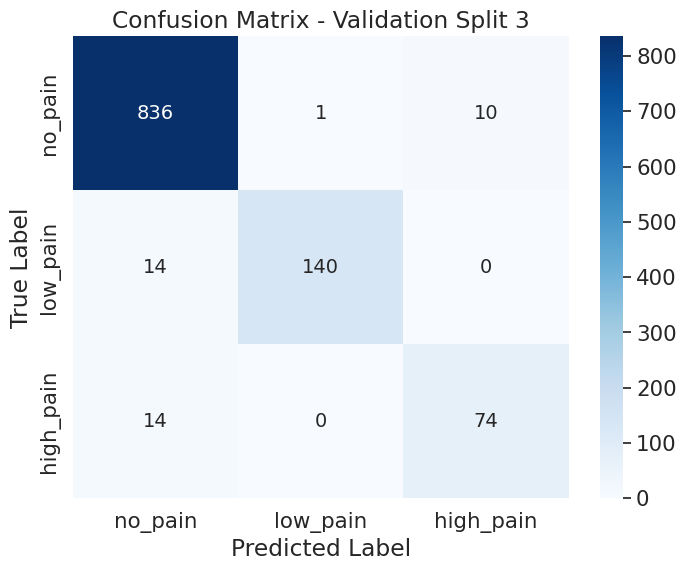

Best score: 0.9495±0.0105
Best experiment split: 2025-11-13 23:33:07.236983_vol-trend_lstm_v4_unidir/split_2
CPU times: user 34min 42s, sys: 5min 1s, total: 39min 43s
Wall time: 28min 1s


In [119]:
# @title Run
%%time
# Execute K-fold cross-validation with baseline configuration
losses, metrics, best_scores, best_model, best_experiment_name = k_shuffle_split_cross_validation_round_rnn(
    df=df_features,
    df_labels=df_labels,
    epochs=EPOCHS,
    criterion=criterion,
    device=device,
    k=K,
    batch_size=BATCH_SIZE,
    hidden_layers=HIDDEN_LAYERS,
    hidden_size=HIDDEN_SIZE,
    learning_rate=LEARNING_RATE,
    dropout_rate=DROPOUT_RATE,
    l1_lambda=L1_LAMBDA,
    l2_lambda=L2_LAMBDA,
    verbose=VERBOSE,
    patience=PATIENCE,
    seed=SEED,
    experiment_name=base_experiment_name,
    test_size=VAL_SIZE,
    window_size=WINDOW_SIZE,
    stride=STRIDE,
    rnn_type=RNN_TYPE,
    bidirectional=BIDIRECTIONAL,
    writer=writer
)

final_best_params = {
  'k': K,
  'test_size': VAL_SIZE,
  'epochs': EPOCHS,
  'patience': PATIENCE,
  'verbose': 0,
  'learning_rate': LEARNING_RATE,
  'batch_size': BATCH_SIZE,
  'window_size': WINDOW_SIZE,
  'stride': STRIDE,
  'hidden_layers': HIDDEN_LAYERS,
  'hidden_size': HIDDEN_SIZE,
  'rnn_type': RNN_TYPE,
  'bidirectional': BIDIRECTIONAL,
  'dropout_rate': DROPOUT_RATE,
  'l1_lambda': L1_LAMBDA,
  'l2_lambda': L2_LAMBDA,
  'criterion': criterion,
  'device': device,
  'seed': SEED
}

print(f"Best experiment split: {best_experiment_name}")

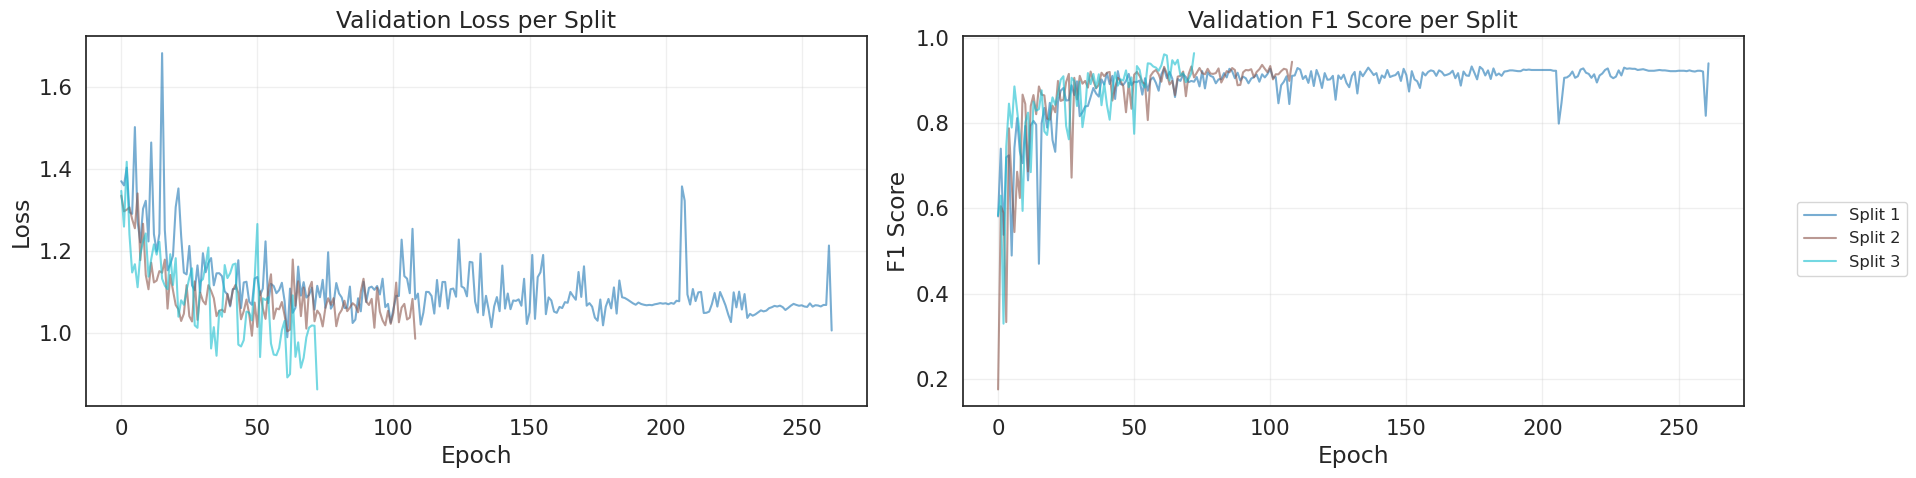

In [120]:
# @title Plot history
# Create figure with two subplots sharing x axis
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5), sharex=True)

# Color palette for K splits
colors = plt.cm.get_cmap('tab10', K)

# Plot validation loss for each split
for split in range(K):
    axes[0].plot(losses[f'split_{split}'][:-PATIENCE], label=f'Split {split+1}',
                 color=colors(split), alpha=0.6)
axes[0].set_title('Validation Loss per Split')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].grid(alpha=0.3)

# Plot validation F1 score for each split
for split in range(K):
    axes[1].plot(metrics[f'split_{split}'][:-PATIENCE], label=f'Split {split+1}',
                 color=colors(split), alpha=0.6)
axes[1].set_title('Validation F1 Score per Split')
axes[1].set_ylabel('F1 Score')
axes[1].set_xlabel('Epoch')
axes[1].grid(alpha=0.3)

# Add shared legend on the right
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(right=0.975)
plt.savefig(f'models/{base_experiment_name}/validation_f1-score_history.png')
plt.show()

---
## 🚀 **4b. Run with grid search over windowing...**
> Window size in 40, 60, 80, 100. Stride in 10, 20. </br>
> The best models seems to be our 40/10 windowing strategy.

In [20]:
# @title Configuration
# Cross-validation
K = 5                    # Number of splits (5 and 10 are considered good values)
VAL_SIZE = 99            # Size or fraction for validation splits

# Training
EPOCHS = 10000           # Maximum epochs (increase to improve performance)
PATIENCE = 100           # Early stopping patience (increase to improve performance)
VERBOSE = 100            # Print frequency

# Optimisation
LEARNING_RATE = 1e-3     # Learning rate
BATCH_SIZE = 32          # Batch size
# WINDOW_SIZE = 50         # Input window size
# STRIDE = 10               # Input stride

# Architecture
HIDDEN_LAYERS = 2        # Hidden layers
HIDDEN_SIZE = 64         # Neurons per layer
RNN_TYPE = 'LSTM'        # Type of RNN architecture
BIDIRECTIONAL = True     # Bidirectional RNN

# Regularisation
DROPOUT_RATE = 0.2       # Dropout probability
L1_LAMBDA = 0            # L1 penalty
L2_LAMBDA = 1e-4         # L2 penalty

# Loss function
ALPHA = 0.1              # Smoothing applied on the loss (between 0 and 1)
CLASS_WEIGHTS_LIST = [0.43, 2.32, 4.0]
CLASS_WEIGHTS = torch.tensor(CLASS_WEIGHTS_LIST, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=ALPHA, weight=CLASS_WEIGHTS)


# Experiment name
base_experiment_name = f'{str(datetime.now())}_vol-trend_lstm_v4b_GS-windowing'
print(f"Experiment: {base_experiment_name}")

# Setup TensorBoard writer
# --- writer = SummaryWriter("./"+logs_dir+"/"+base_experiment_name)

# Initialize best model tracking variables
best_model = None
best_experiment_name = None
best_performance = float('-inf')

Experiment: 2025-11-14 09:40:38.065699_vol-trend_lstm_v4b_GS-windowing



Configuration 1/8:
  window_size: 40
  stride: 10
Split 1/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (7306, 40, 94)
  Validation sequences shape: (1287, 40, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.1774, F1 Score=0.4312 | Val: Loss=1.5048, F1 Score=0.3015
Epoch  50/10000 | Train: Loss=0.6305, F1 Score=0.9667 | Val: Loss=1.1343, F1 Score=0.8664
Epoch 100/10000 | Train: Loss=0.5801, F1 Score=0.9864 | Val: Loss=1.0877, F1 Score=0.9037
Epoch 150/10000 | Train: Loss=0.5693, F1 Score=0.9945 | Val: Loss=1.0586, F1 Score=0.9122
Epoch 200/10000 | Train: Loss=0.5661, F1 Score=0.9973 | Val: Loss=1.1193, F1 Score=0.8967
Epoch 250/10000 | Train: Loss=0.6144, F1 Score=0.9782 | Val: Loss=1.1108, F1 Score=0.9021
Epoch 300/10000 | Train: Loss=0.5564, F1 Score=1.0000 | Val: Loss=1.0999, F1 Score=0.9138
Epoch 350/10000 | Train: Loss=0.5640, F1 Score=0.9960 | Val: Loss=1.1086, F1 Score=0.9099
Epoch 400/10000 | Train: Loss=0.5574

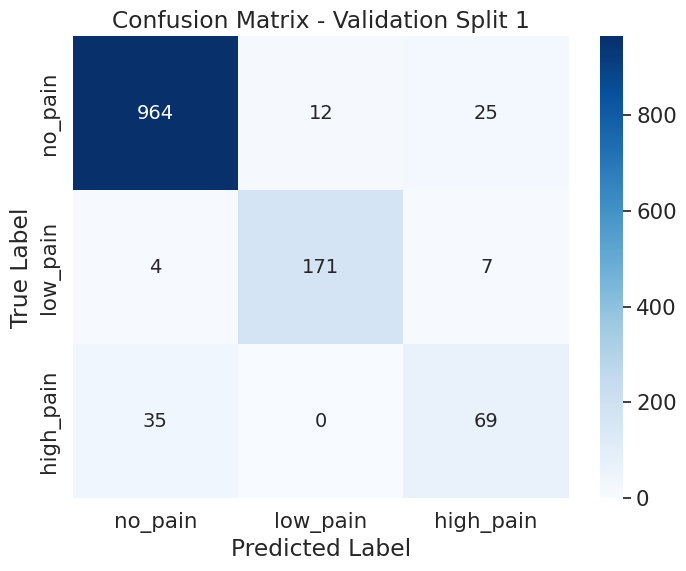

Split 2/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (7306, 40, 94)
  Validation sequences shape: (1287, 40, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.1885, F1 Score=0.4372 | Val: Loss=1.4193, F1 Score=0.1671
Epoch  50/10000 | Train: Loss=0.6201, F1 Score=0.9676 | Val: Loss=1.0251, F1 Score=0.9161
Epoch 100/10000 | Train: Loss=0.5827, F1 Score=0.9838 | Val: Loss=0.9826, F1 Score=0.9324
Early stopping triggered after 141 epochs.
Best model restored from epoch 41 with val_f1 0.9479

Saved confusion matrix plot to: 'models/window_size_40_stride_10/split_1/confusion_matrix_Validation_Split_2.png'


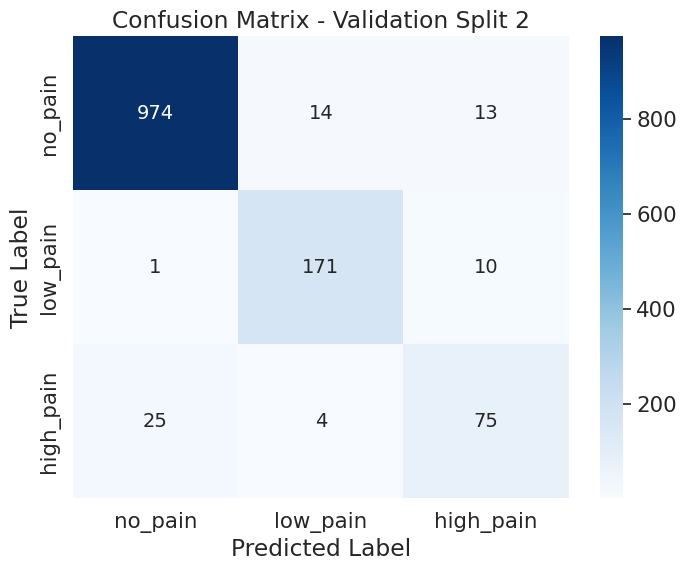

Split 3/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (7306, 40, 94)
  Validation sequences shape: (1287, 40, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.1816, F1 Score=0.4250 | Val: Loss=1.2742, F1 Score=0.7863
Epoch  50/10000 | Train: Loss=0.6193, F1 Score=0.9613 | Val: Loss=1.0047, F1 Score=0.8881
Epoch 100/10000 | Train: Loss=0.5948, F1 Score=0.9771 | Val: Loss=0.8885, F1 Score=0.9674
Epoch 150/10000 | Train: Loss=0.5926, F1 Score=0.9849 | Val: Loss=1.0172, F1 Score=0.9200
Epoch 200/10000 | Train: Loss=0.5763, F1 Score=0.9914 | Val: Loss=0.9581, F1 Score=0.9378
Early stopping triggered after 230 epochs.
Best model restored from epoch 130 with val_f1 0.9720

Saved confusion matrix plot to: 'models/window_size_40_stride_10/split_2/confusion_matrix_Validation_Split_3.png'


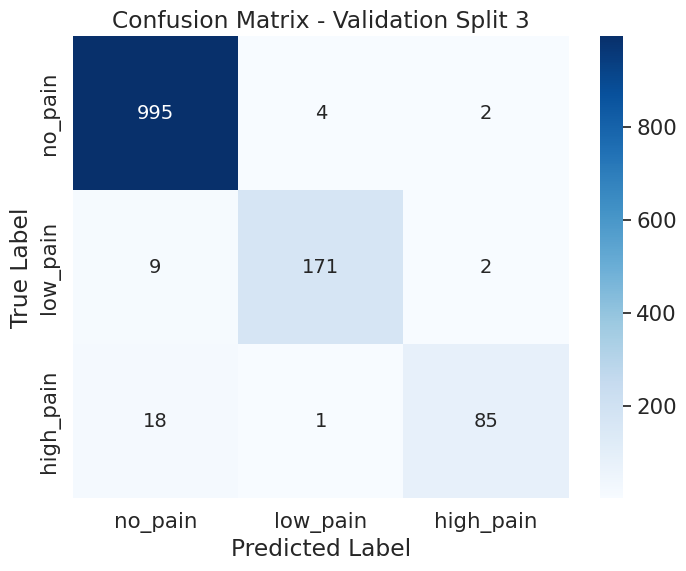

Split 4/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (7306, 40, 94)
  Validation sequences shape: (1287, 40, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.1820, F1 Score=0.4804 | Val: Loss=1.3495, F1 Score=0.2502
Epoch  50/10000 | Train: Loss=0.6197, F1 Score=0.9745 | Val: Loss=1.2037, F1 Score=0.8493
Epoch 100/10000 | Train: Loss=0.5982, F1 Score=0.9845 | Val: Loss=1.1656, F1 Score=0.8741
Epoch 150/10000 | Train: Loss=0.5666, F1 Score=0.9952 | Val: Loss=1.1789, F1 Score=0.8811
Early stopping triggered after 191 epochs.
Best model restored from epoch 91 with val_f1 0.9044

Saved confusion matrix plot to: 'models/window_size_40_stride_10/split_3/confusion_matrix_Validation_Split_4.png'


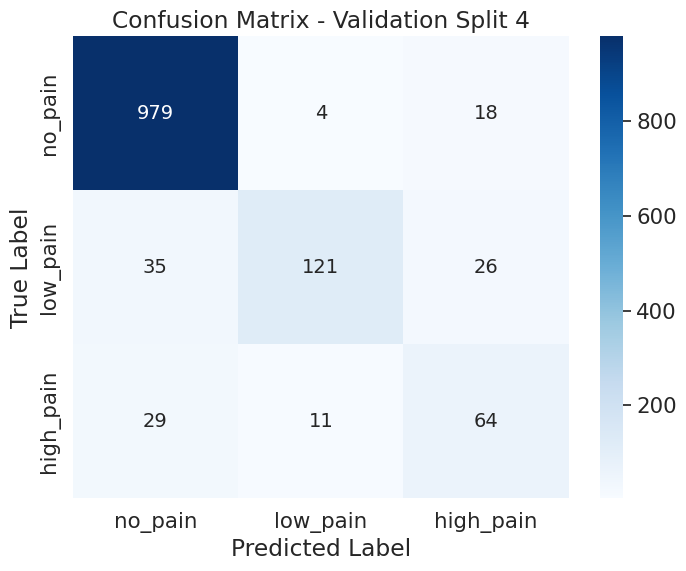

Split 5/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (7306, 40, 94)
  Validation sequences shape: (1287, 40, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2039, F1 Score=0.3890 | Val: Loss=1.2590, F1 Score=0.7040
Epoch  50/10000 | Train: Loss=0.6193, F1 Score=0.9667 | Val: Loss=1.2405, F1 Score=0.8718
Epoch 100/10000 | Train: Loss=0.6018, F1 Score=0.9767 | Val: Loss=1.2463, F1 Score=0.8648
Epoch 150/10000 | Train: Loss=0.5778, F1 Score=0.9904 | Val: Loss=1.2863, F1 Score=0.8516
Epoch 200/10000 | Train: Loss=0.5734, F1 Score=0.9917 | Val: Loss=1.1922, F1 Score=0.8873
Epoch 250/10000 | Train: Loss=0.5599, F1 Score=1.0000 | Val: Loss=1.2561, F1 Score=0.8803
Early stopping triggered after 289 epochs.
Best model restored from epoch 189 with val_f1 0.9122

Saved confusion matrix plot to: 'models/window_size_40_stride_10/split_4/confusion_matrix_Validation_Split_5.png'


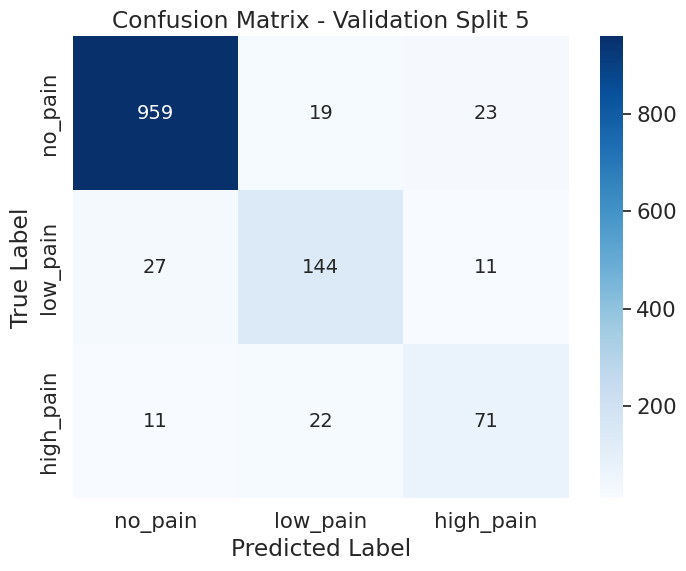

Best score: 0.9344±0.0245
🎉🎉🎉  NEW BEST SCORE! 🎉🎉🎉
  Experiment (split): window_size_40_stride_10/split_2
  F1 Score: 0.9344±0.0245

Configuration 2/8:
  window_size: 40
  stride: 20
Split 1/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (3934, 40, 94)
  Validation sequences shape: (693, 40, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2204, F1 Score=0.2944 | Val: Loss=1.4195, F1 Score=0.1198
Epoch  50/10000 | Train: Loss=0.6776, F1 Score=0.9316 | Val: Loss=1.1249, F1 Score=0.8557
Epoch 100/10000 | Train: Loss=0.6130, F1 Score=0.9644 | Val: Loss=1.0604, F1 Score=0.8990
Epoch 150/10000 | Train: Loss=0.5836, F1 Score=0.9888 | Val: Loss=1.0086, F1 Score=0.8975
Epoch 200/10000 | Train: Loss=0.5858, F1 Score=0.9898 | Val: Loss=1.0612, F1 Score=0.8990
Epoch 250/10000 | Train: Loss=0.5578, F1 Score=0.9992 | Val: Loss=1.0560, F1 Score=0.9048
Epoch 300/10000 | Train: Loss=0.5675, F1 Score=0.9982 | Val: Loss=1.0347, F1 Score=0.

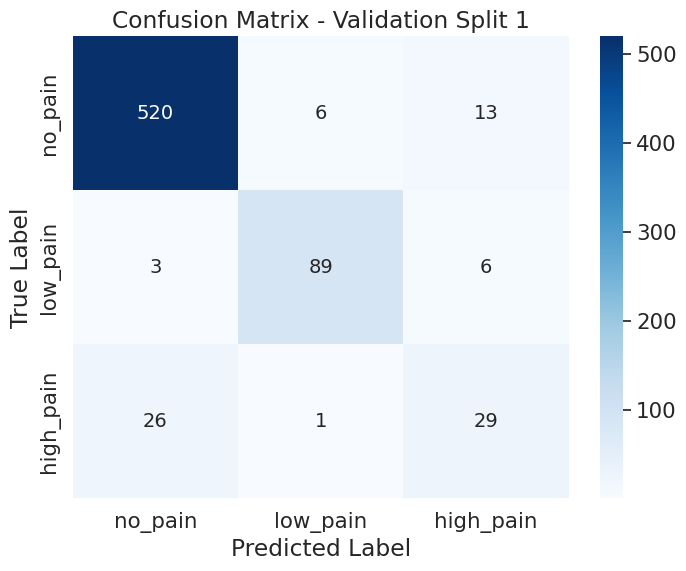

Split 2/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (3934, 40, 94)
  Validation sequences shape: (693, 40, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2183, F1 Score=0.3106 | Val: Loss=1.2787, F1 Score=0.7359
Epoch  50/10000 | Train: Loss=0.6804, F1 Score=0.9189 | Val: Loss=0.9709, F1 Score=0.8802
Epoch 100/10000 | Train: Loss=0.6233, F1 Score=0.9581 | Val: Loss=1.0039, F1 Score=0.9235
Epoch 150/10000 | Train: Loss=0.6094, F1 Score=0.9784 | Val: Loss=1.0222, F1 Score=0.9091
Epoch 200/10000 | Train: Loss=0.5696, F1 Score=0.9911 | Val: Loss=0.9934, F1 Score=0.9221
Early stopping triggered after 215 epochs.
Best model restored from epoch 115 with val_f1 0.9408

Saved confusion matrix plot to: 'models/window_size_40_stride_20/split_1/confusion_matrix_Validation_Split_2.png'


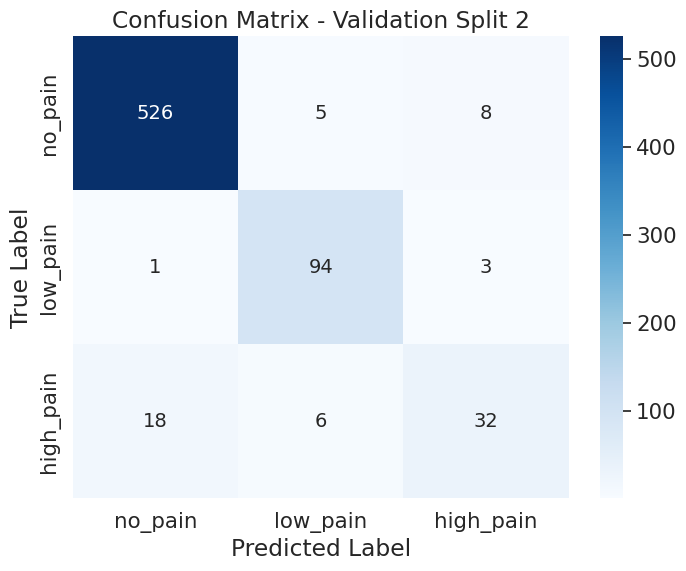

Split 3/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (3934, 40, 94)
  Validation sequences shape: (693, 40, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2194, F1 Score=0.3582 | Val: Loss=1.2535, F1 Score=0.7244
Epoch  50/10000 | Train: Loss=0.6955, F1 Score=0.9202 | Val: Loss=0.9089, F1 Score=0.9033
Epoch 100/10000 | Train: Loss=0.6062, F1 Score=0.9738 | Val: Loss=0.9684, F1 Score=0.9091
Epoch 150/10000 | Train: Loss=0.5803, F1 Score=0.9878 | Val: Loss=0.8832, F1 Score=0.9293
Epoch 200/10000 | Train: Loss=0.5625, F1 Score=0.9964 | Val: Loss=0.9759, F1 Score=0.9105
Early stopping triggered after 205 epochs.
Best model restored from epoch 105 with val_f1 0.9610

Saved confusion matrix plot to: 'models/window_size_40_stride_20/split_2/confusion_matrix_Validation_Split_3.png'


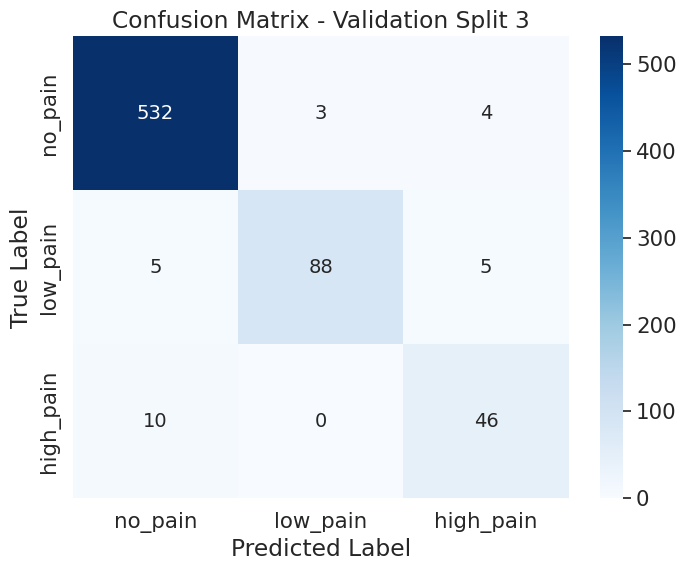

Split 4/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (3934, 40, 94)
  Validation sequences shape: (693, 40, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.1973, F1 Score=0.3594 | Val: Loss=1.3744, F1 Score=0.1789
Epoch  50/10000 | Train: Loss=0.6980, F1 Score=0.9176 | Val: Loss=1.0570, F1 Score=0.8398
Epoch 100/10000 | Train: Loss=0.5972, F1 Score=0.9825 | Val: Loss=1.1329, F1 Score=0.8413
Epoch 150/10000 | Train: Loss=0.5784, F1 Score=0.9903 | Val: Loss=1.1788, F1 Score=0.8543
Epoch 200/10000 | Train: Loss=0.5660, F1 Score=0.9942 | Val: Loss=1.0611, F1 Score=0.8802
Epoch 250/10000 | Train: Loss=0.5632, F1 Score=0.9962 | Val: Loss=1.1604, F1 Score=0.8499
Early stopping triggered after 278 epochs.
Best model restored from epoch 178 with val_f1 0.8932

Saved confusion matrix plot to: 'models/window_size_40_stride_20/split_3/confusion_matrix_Validation_Split_4.png'


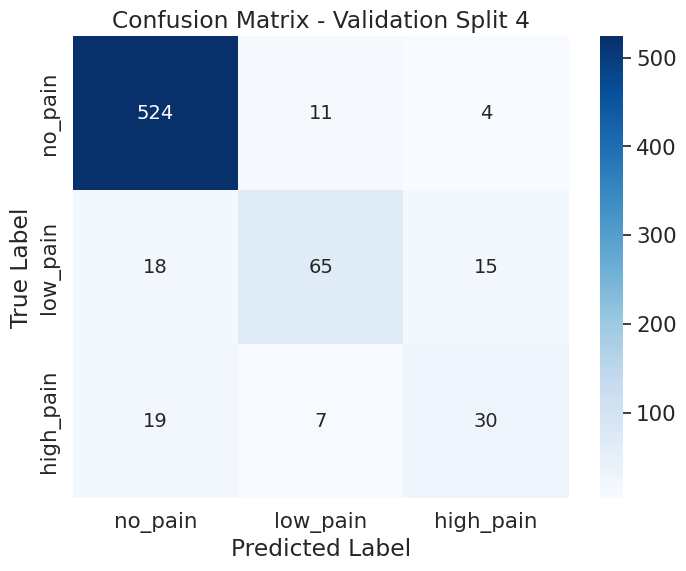

Split 5/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (3934, 40, 94)
  Validation sequences shape: (693, 40, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2194, F1 Score=0.2860 | Val: Loss=1.2167, F1 Score=0.7850
Epoch  50/10000 | Train: Loss=0.6723, F1 Score=0.9225 | Val: Loss=1.2448, F1 Score=0.8543
Epoch 100/10000 | Train: Loss=0.5990, F1 Score=0.9736 | Val: Loss=1.1894, F1 Score=0.8586
Epoch 150/10000 | Train: Loss=0.5746, F1 Score=0.9911 | Val: Loss=1.3225, F1 Score=0.8413
Epoch 200/10000 | Train: Loss=0.5744, F1 Score=0.9962 | Val: Loss=1.1478, F1 Score=0.8788
Early stopping triggered after 228 epochs.
Best model restored from epoch 128 with val_f1 0.8889

Saved confusion matrix plot to: 'models/window_size_40_stride_20/split_4/confusion_matrix_Validation_Split_5.png'


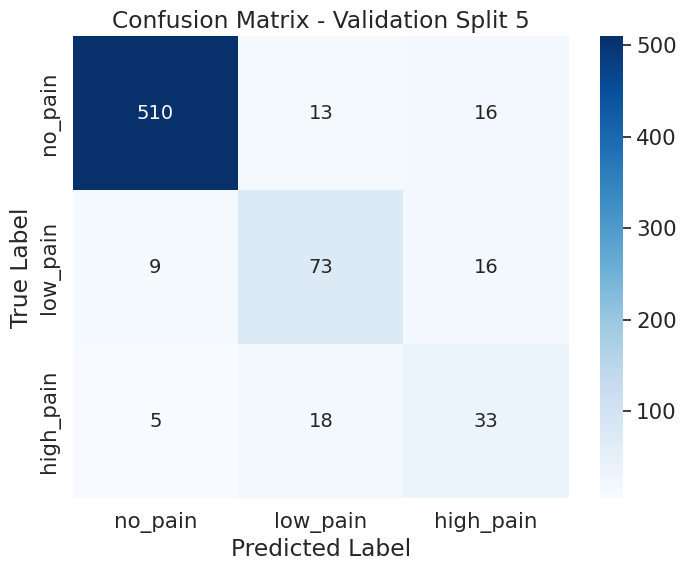

Best score: 0.9209±0.0276
  Experiment (split): window_size_40_stride_20/split_2
  F1 Score: 0.9209±0.0276

Configuration 3/8:
  window_size: 60
  stride: 10
Split 1/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (7306, 60, 94)
  Validation sequences shape: (1287, 60, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.1805, F1 Score=0.4812 | Val: Loss=1.3834, F1 Score=0.3714
Epoch  50/10000 | Train: Loss=0.6272, F1 Score=0.9640 | Val: Loss=1.0943, F1 Score=0.8912
Epoch 100/10000 | Train: Loss=0.5863, F1 Score=0.9860 | Val: Loss=1.0800, F1 Score=0.9138
Epoch 150/10000 | Train: Loss=0.5786, F1 Score=0.9900 | Val: Loss=1.1395, F1 Score=0.8920
Epoch 200/10000 | Train: Loss=0.5611, F1 Score=0.9966 | Val: Loss=1.1594, F1 Score=0.8687
Early stopping triggered after 211 epochs.
Best model restored from epoch 111 with val_f1 0.9324

Saved confusion matrix plot to: 'models/window_size_60_stride_10/split_0/confusion_matrix_Validation_

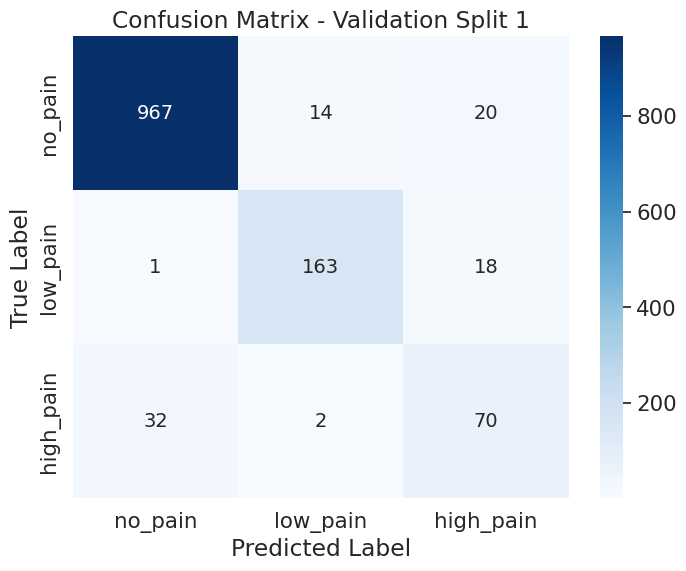

Split 2/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (7306, 60, 94)
  Validation sequences shape: (1287, 60, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.1899, F1 Score=0.4331 | Val: Loss=1.3058, F1 Score=0.4095
Epoch  50/10000 | Train: Loss=0.6295, F1 Score=0.9578 | Val: Loss=1.1479, F1 Score=0.8827
Epoch 100/10000 | Train: Loss=0.6014, F1 Score=0.9851 | Val: Loss=1.0124, F1 Score=0.9340
Early stopping triggered after 145 epochs.
Best model restored from epoch 45 with val_f1 0.9425

Saved confusion matrix plot to: 'models/window_size_60_stride_10/split_1/confusion_matrix_Validation_Split_2.png'


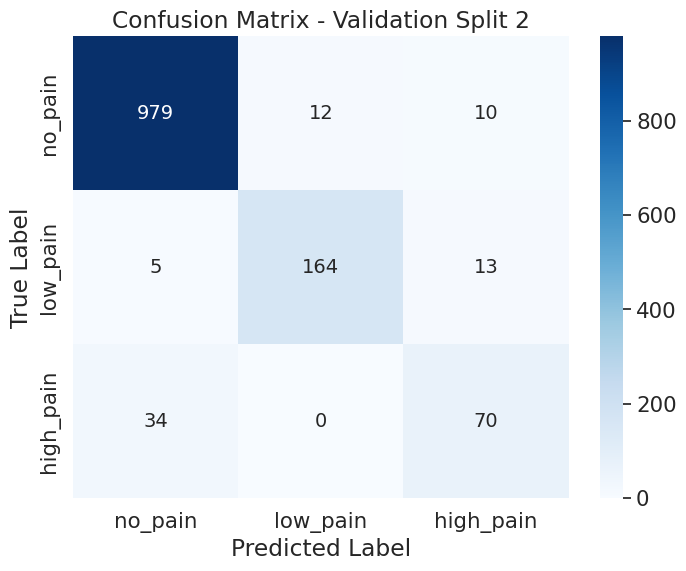

Split 3/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (7306, 60, 94)
  Validation sequences shape: (1287, 60, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.1909, F1 Score=0.4817 | Val: Loss=1.4354, F1 Score=0.4779
Epoch  50/10000 | Train: Loss=0.6208, F1 Score=0.9588 | Val: Loss=1.0636, F1 Score=0.8982
Epoch 100/10000 | Train: Loss=0.5751, F1 Score=0.9899 | Val: Loss=0.9415, F1 Score=0.9534
Epoch 150/10000 | Train: Loss=0.5606, F1 Score=0.9977 | Val: Loss=0.9518, F1 Score=0.9510
Epoch 200/10000 | Train: Loss=0.5554, F1 Score=1.0000 | Val: Loss=0.9636, F1 Score=0.9495
Early stopping triggered after 206 epochs.
Best model restored from epoch 106 with val_f1 0.9611

Saved confusion matrix plot to: 'models/window_size_60_stride_10/split_2/confusion_matrix_Validation_Split_3.png'


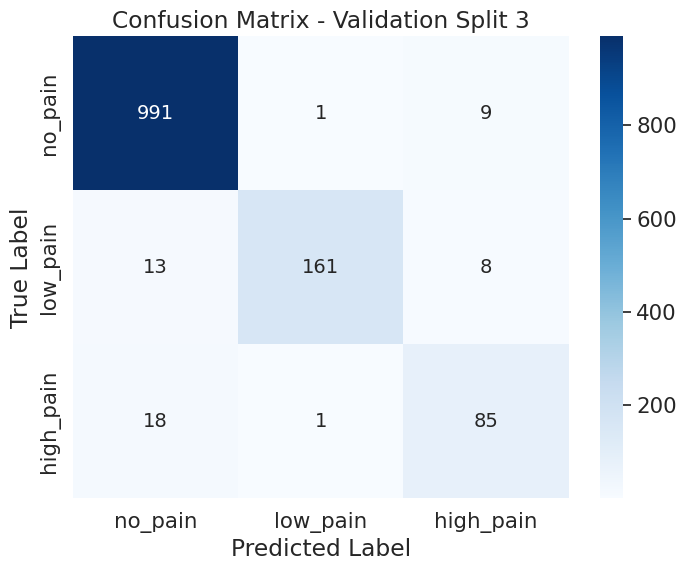

Split 4/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (7306, 60, 94)
  Validation sequences shape: (1287, 60, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.1948, F1 Score=0.4561 | Val: Loss=1.2627, F1 Score=0.7778
Epoch  50/10000 | Train: Loss=0.6117, F1 Score=0.9715 | Val: Loss=1.1610, F1 Score=0.8749
Epoch 100/10000 | Train: Loss=0.5769, F1 Score=0.9912 | Val: Loss=1.1629, F1 Score=0.8866
Epoch 150/10000 | Train: Loss=0.5642, F1 Score=0.9964 | Val: Loss=1.2026, F1 Score=0.8687
Epoch 200/10000 | Train: Loss=0.5545, F1 Score=1.0000 | Val: Loss=1.2036, F1 Score=0.8796
Early stopping triggered after 212 epochs.
Best model restored from epoch 112 with val_f1 0.8959

Saved confusion matrix plot to: 'models/window_size_60_stride_10/split_3/confusion_matrix_Validation_Split_4.png'


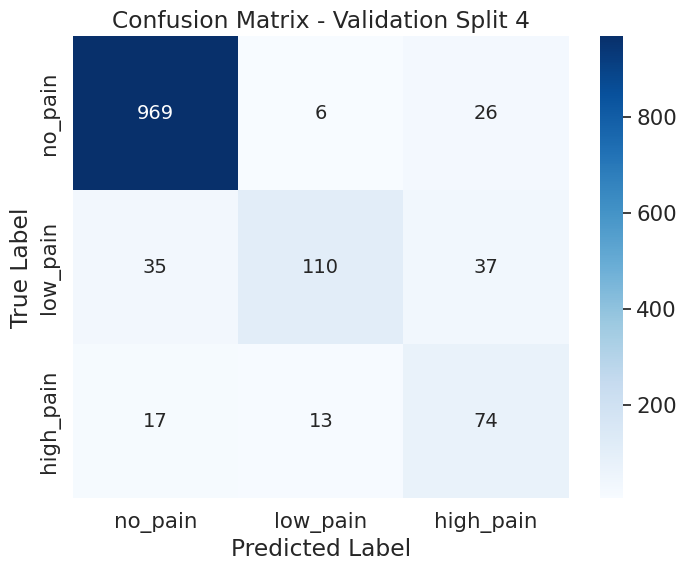

Split 5/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (7306, 60, 94)
  Validation sequences shape: (1287, 60, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2224, F1 Score=0.3241 | Val: Loss=1.3131, F1 Score=0.4204
Epoch  50/10000 | Train: Loss=0.6264, F1 Score=0.9592 | Val: Loss=1.2103, F1 Score=0.8726
Epoch 100/10000 | Train: Loss=0.6001, F1 Score=0.9825 | Val: Loss=1.2198, F1 Score=0.8493
Epoch 150/10000 | Train: Loss=0.5780, F1 Score=0.9910 | Val: Loss=1.1685, F1 Score=0.8974
Epoch 200/10000 | Train: Loss=0.5687, F1 Score=0.9955 | Val: Loss=1.1611, F1 Score=0.8943
Early stopping triggered after 223 epochs.
Best model restored from epoch 123 with val_f1 0.9037

Saved confusion matrix plot to: 'models/window_size_60_stride_10/split_4/confusion_matrix_Validation_Split_5.png'


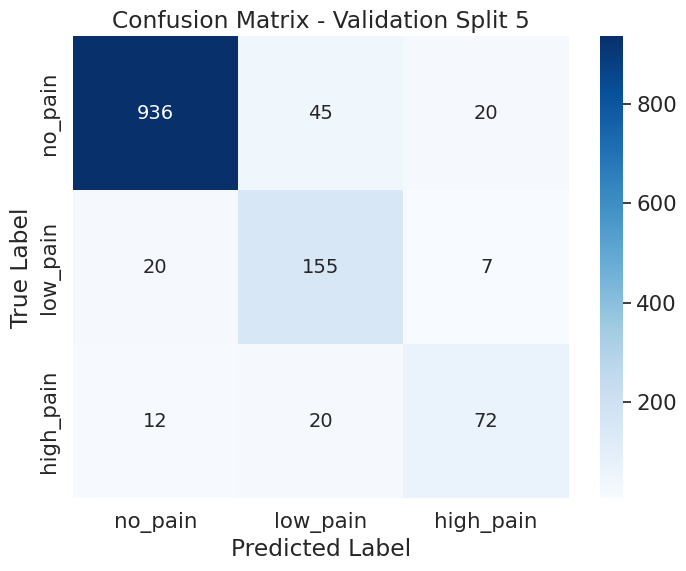

Best score: 0.9271±0.0243
  Experiment (split): window_size_60_stride_10/split_2
  F1 Score: 0.9271±0.0243

Configuration 4/8:
  window_size: 60
  stride: 20
Split 1/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (3934, 60, 94)
  Validation sequences shape: (693, 60, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2152, F1 Score=0.3312 | Val: Loss=1.3731, F1 Score=0.3608
Epoch  50/10000 | Train: Loss=0.7201, F1 Score=0.9146 | Val: Loss=1.0742, F1 Score=0.8687
Epoch 100/10000 | Train: Loss=0.5888, F1 Score=0.9825 | Val: Loss=1.1638, F1 Score=0.8874
Epoch 150/10000 | Train: Loss=0.5870, F1 Score=0.9886 | Val: Loss=0.9766, F1 Score=0.9206
Epoch 200/10000 | Train: Loss=0.5668, F1 Score=0.9969 | Val: Loss=1.0280, F1 Score=0.9004
Epoch 250/10000 | Train: Loss=0.5773, F1 Score=0.9898 | Val: Loss=0.9745, F1 Score=0.9278
Epoch 300/10000 | Train: Loss=0.5657, F1 Score=0.9964 | Val: Loss=1.0082, F1 Score=0.9163
Early stopping trigg

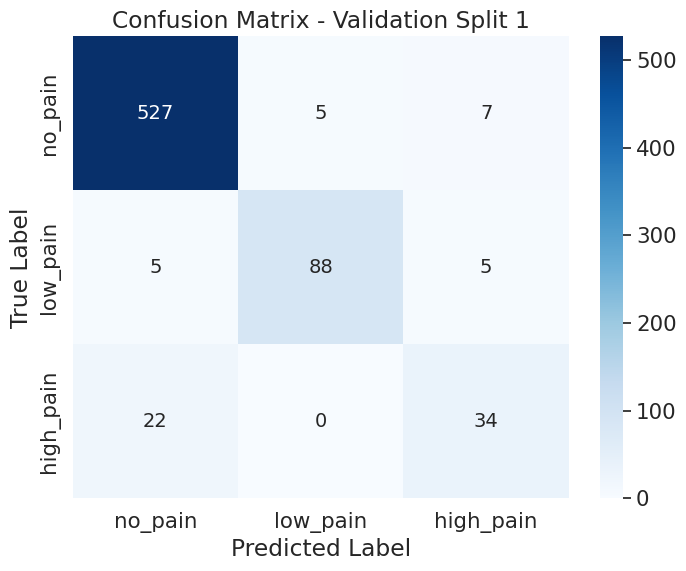

Split 2/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (3934, 60, 94)
  Validation sequences shape: (693, 60, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2085, F1 Score=0.3546 | Val: Loss=1.2528, F1 Score=0.7734
Epoch  50/10000 | Train: Loss=0.6797, F1 Score=0.9314 | Val: Loss=1.2692, F1 Score=0.8470
Epoch 100/10000 | Train: Loss=0.6093, F1 Score=0.9710 | Val: Loss=0.9926, F1 Score=0.9134
Epoch 150/10000 | Train: Loss=0.5944, F1 Score=0.9830 | Val: Loss=0.9578, F1 Score=0.9177
Epoch 200/10000 | Train: Loss=0.5769, F1 Score=0.9931 | Val: Loss=1.1072, F1 Score=0.8687
Early stopping triggered after 201 epochs.
Best model restored from epoch 101 with val_f1 0.9553

Saved confusion matrix plot to: 'models/window_size_60_stride_20/split_1/confusion_matrix_Validation_Split_2.png'


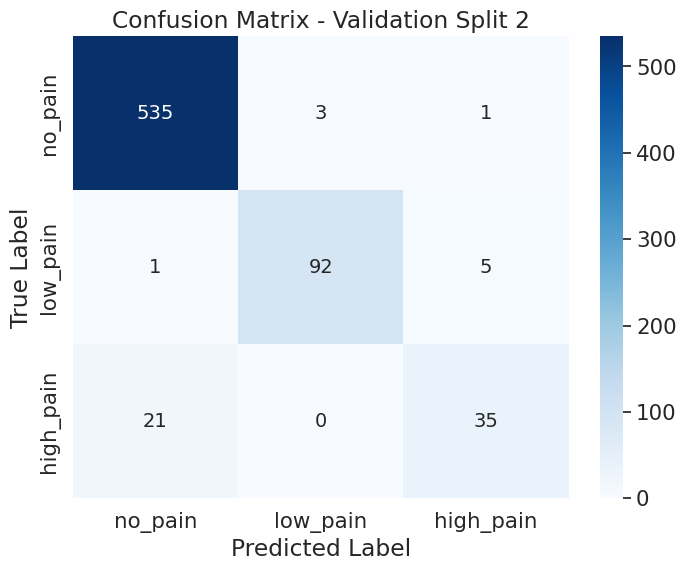

Split 3/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (3934, 60, 94)
  Validation sequences shape: (693, 60, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2107, F1 Score=0.3071 | Val: Loss=1.2315, F1 Score=0.7720
Epoch  50/10000 | Train: Loss=0.6767, F1 Score=0.9133 | Val: Loss=0.9134, F1 Score=0.9235
Epoch 100/10000 | Train: Loss=0.5942, F1 Score=0.9779 | Val: Loss=0.9741, F1 Score=0.8903
Epoch 150/10000 | Train: Loss=0.5817, F1 Score=0.9881 | Val: Loss=0.8971, F1 Score=0.9380
Epoch 200/10000 | Train: Loss=0.5604, F1 Score=0.9975 | Val: Loss=0.9009, F1 Score=0.9351
Early stopping triggered after 222 epochs.
Best model restored from epoch 122 with val_f1 0.9625

Saved confusion matrix plot to: 'models/window_size_60_stride_20/split_2/confusion_matrix_Validation_Split_3.png'


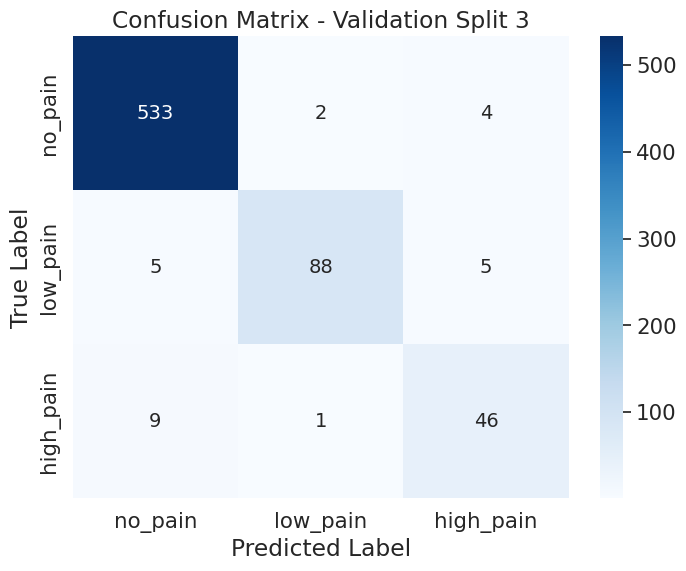

Split 4/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (3934, 60, 94)
  Validation sequences shape: (693, 60, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2172, F1 Score=0.3160 | Val: Loss=1.2158, F1 Score=0.4978
Epoch  50/10000 | Train: Loss=0.6604, F1 Score=0.9423 | Val: Loss=1.1682, F1 Score=0.8470
Epoch 100/10000 | Train: Loss=0.5953, F1 Score=0.9799 | Val: Loss=1.0994, F1 Score=0.8629
Epoch 150/10000 | Train: Loss=0.5977, F1 Score=0.9850 | Val: Loss=1.1424, F1 Score=0.8629
Epoch 200/10000 | Train: Loss=0.5797, F1 Score=0.9893 | Val: Loss=1.0890, F1 Score=0.8817
Epoch 250/10000 | Train: Loss=0.5805, F1 Score=0.9888 | Val: Loss=1.1394, F1 Score=0.8817
Early stopping triggered after 260 epochs.
Best model restored from epoch 160 with val_f1 0.8961

Saved confusion matrix plot to: 'models/window_size_60_stride_20/split_3/confusion_matrix_Validation_Split_4.png'


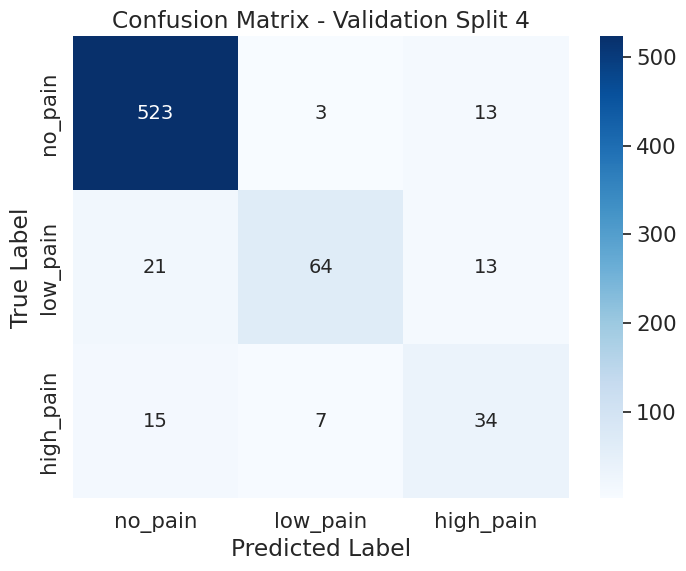

Split 5/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (3934, 60, 94)
  Validation sequences shape: (693, 60, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2233, F1 Score=0.2877 | Val: Loss=1.2530, F1 Score=0.4055
Epoch  50/10000 | Train: Loss=0.6789, F1 Score=0.9232 | Val: Loss=1.3150, F1 Score=0.8153
Epoch 100/10000 | Train: Loss=0.6004, F1 Score=0.9771 | Val: Loss=1.2028, F1 Score=0.8398
Epoch 150/10000 | Train: Loss=0.5723, F1 Score=0.9964 | Val: Loss=1.2686, F1 Score=0.8658
Epoch 200/10000 | Train: Loss=0.5800, F1 Score=0.9919 | Val: Loss=1.2149, F1 Score=0.8773
Epoch 250/10000 | Train: Loss=0.5526, F1 Score=1.0000 | Val: Loss=1.2212, F1 Score=0.8773
Early stopping triggered after 267 epochs.
Best model restored from epoch 167 with val_f1 0.8918

Saved confusion matrix plot to: 'models/window_size_60_stride_20/split_4/confusion_matrix_Validation_Split_5.png'


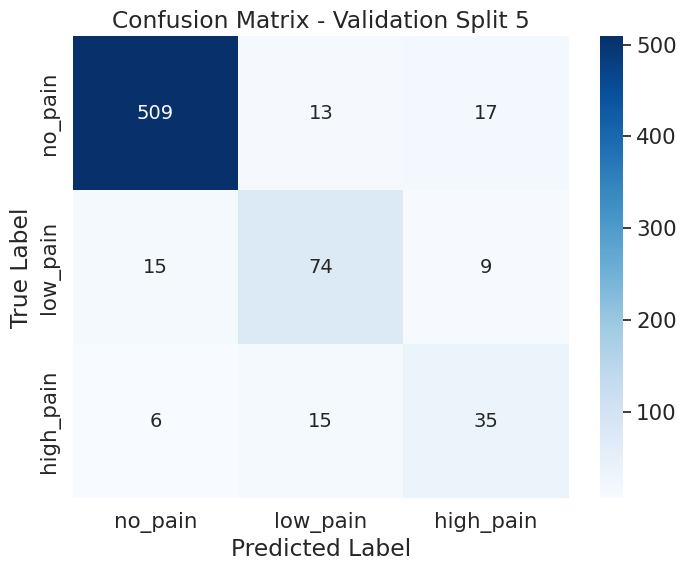

Best score: 0.9284±0.0294
  Experiment (split): window_size_60_stride_20/split_2
  F1 Score: 0.9284±0.0294

Configuration 5/8:
  window_size: 80
  stride: 10
Split 1/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (5058, 80, 94)
  Validation sequences shape: (891, 80, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.1993, F1 Score=0.4081 | Val: Loss=1.3291, F1 Score=0.6880
Epoch  50/10000 | Train: Loss=0.6296, F1 Score=0.9660 | Val: Loss=1.0517, F1 Score=0.8866
Epoch 100/10000 | Train: Loss=0.5886, F1 Score=0.9885 | Val: Loss=1.0557, F1 Score=0.8900
Epoch 150/10000 | Train: Loss=0.5671, F1 Score=0.9970 | Val: Loss=1.0943, F1 Score=0.8923
Early stopping triggered after 185 epochs.
Best model restored from epoch 85 with val_f1 0.9125

Saved confusion matrix plot to: 'models/window_size_80_stride_10/split_0/confusion_matrix_Validation_Split_1.png'


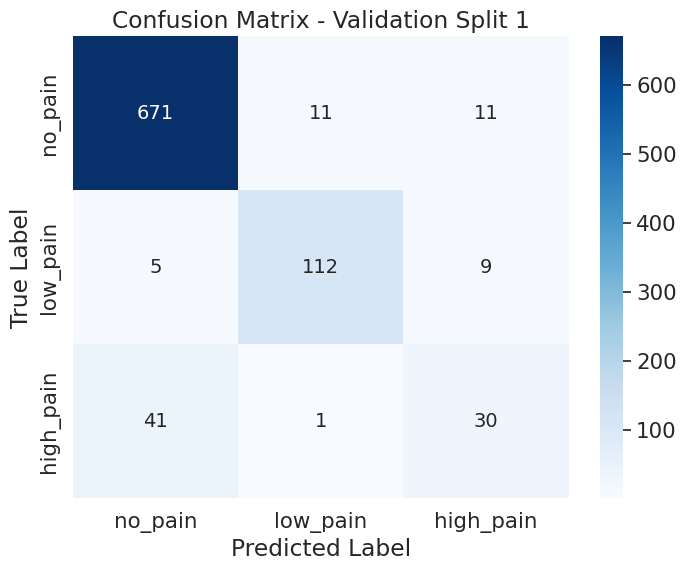

Split 2/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (5058, 80, 94)
  Validation sequences shape: (891, 80, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2058, F1 Score=0.3764 | Val: Loss=1.2763, F1 Score=0.7576
Epoch  50/10000 | Train: Loss=0.6232, F1 Score=0.9597 | Val: Loss=0.9676, F1 Score=0.9237
Epoch 100/10000 | Train: Loss=0.5702, F1 Score=0.9917 | Val: Loss=0.8958, F1 Score=0.9529
Epoch 150/10000 | Train: Loss=0.5614, F1 Score=0.9960 | Val: Loss=0.8709, F1 Score=0.9630
Epoch 200/10000 | Train: Loss=0.5543, F1 Score=1.0000 | Val: Loss=0.9333, F1 Score=0.9540
Epoch 250/10000 | Train: Loss=0.5542, F1 Score=1.0000 | Val: Loss=0.9593, F1 Score=0.9416
Early stopping triggered after 278 epochs.
Best model restored from epoch 178 with val_f1 0.9652

Saved confusion matrix plot to: 'models/window_size_80_stride_10/split_1/confusion_matrix_Validation_Split_2.png'


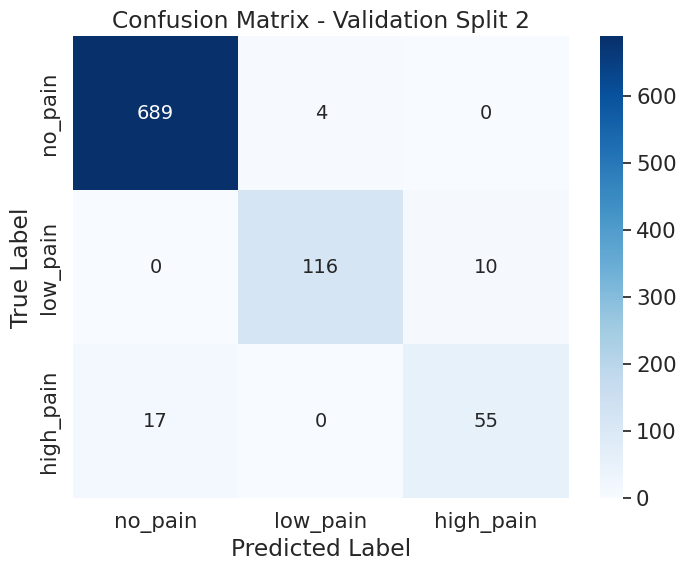

Split 3/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (5058, 80, 94)
  Validation sequences shape: (891, 80, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2054, F1 Score=0.3565 | Val: Loss=1.2811, F1 Score=0.7273
Epoch  50/10000 | Train: Loss=0.6412, F1 Score=0.9454 | Val: Loss=0.9143, F1 Score=0.9192
Epoch 100/10000 | Train: Loss=0.5983, F1 Score=0.9804 | Val: Loss=0.9769, F1 Score=0.9315
Epoch 150/10000 | Train: Loss=0.5814, F1 Score=0.9905 | Val: Loss=0.9486, F1 Score=0.9506
Epoch 200/10000 | Train: Loss=0.5579, F1 Score=1.0000 | Val: Loss=0.8612, F1 Score=0.9731
Epoch 250/10000 | Train: Loss=0.5577, F1 Score=1.0000 | Val: Loss=0.9497, F1 Score=0.9618
Epoch 300/10000 | Train: Loss=0.6490, F1 Score=0.9612 | Val: Loss=1.0018, F1 Score=0.9461
Epoch 350/10000 | Train: Loss=0.5590, F1 Score=1.0000 | Val: Loss=0.9036, F1 Score=0.9663
Early stopping triggered after 382 epochs.
Best model restored from epoch 282 with val_f

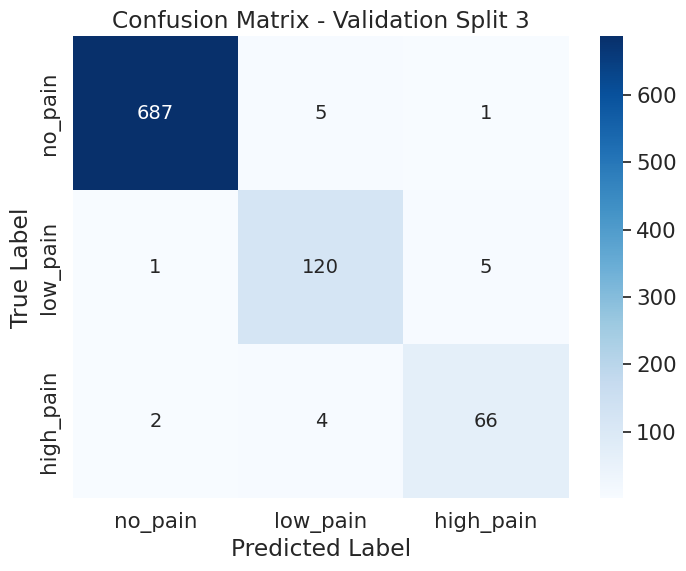

Split 4/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (5058, 80, 94)
  Validation sequences shape: (891, 80, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2043, F1 Score=0.4160 | Val: Loss=1.2810, F1 Score=0.7441
Epoch  50/10000 | Train: Loss=0.6215, F1 Score=0.9658 | Val: Loss=1.1630, F1 Score=0.8541
Epoch 100/10000 | Train: Loss=0.6425, F1 Score=0.9656 | Val: Loss=1.2146, F1 Score=0.8597
Epoch 150/10000 | Train: Loss=0.5656, F1 Score=0.9962 | Val: Loss=1.5379, F1 Score=0.7464
Early stopping triggered after 170 epochs.
Best model restored from epoch 70 with val_f1 0.8979

Saved confusion matrix plot to: 'models/window_size_80_stride_10/split_3/confusion_matrix_Validation_Split_4.png'


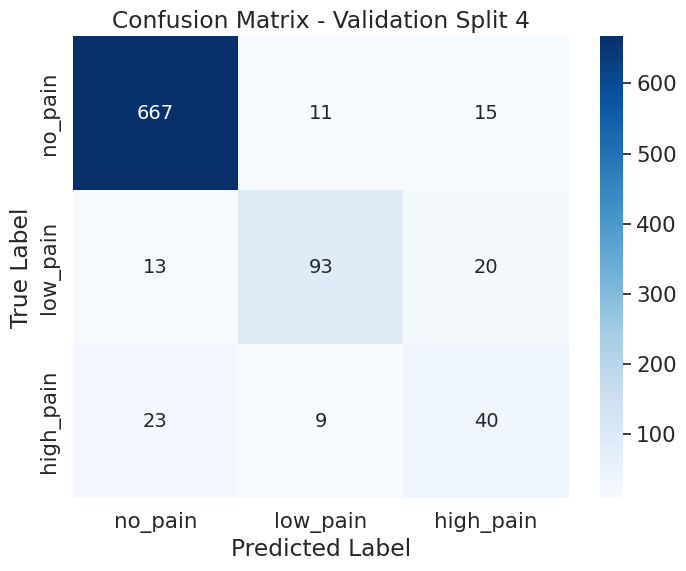

Split 5/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (5058, 80, 94)
  Validation sequences shape: (891, 80, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2386, F1 Score=0.2495 | Val: Loss=1.2800, F1 Score=0.6038
Epoch  50/10000 | Train: Loss=0.6552, F1 Score=0.9411 | Val: Loss=1.2684, F1 Score=0.8575
Epoch 100/10000 | Train: Loss=0.5866, F1 Score=0.9913 | Val: Loss=1.2061, F1 Score=0.8653
Epoch 150/10000 | Train: Loss=0.6665, F1 Score=0.9575 | Val: Loss=1.1842, F1 Score=0.8855
Epoch 200/10000 | Train: Loss=0.5560, F1 Score=1.0000 | Val: Loss=1.2539, F1 Score=0.8754
Early stopping triggered after 214 epochs.
Best model restored from epoch 114 with val_f1 0.8967

Saved confusion matrix plot to: 'models/window_size_80_stride_10/split_4/confusion_matrix_Validation_Split_5.png'


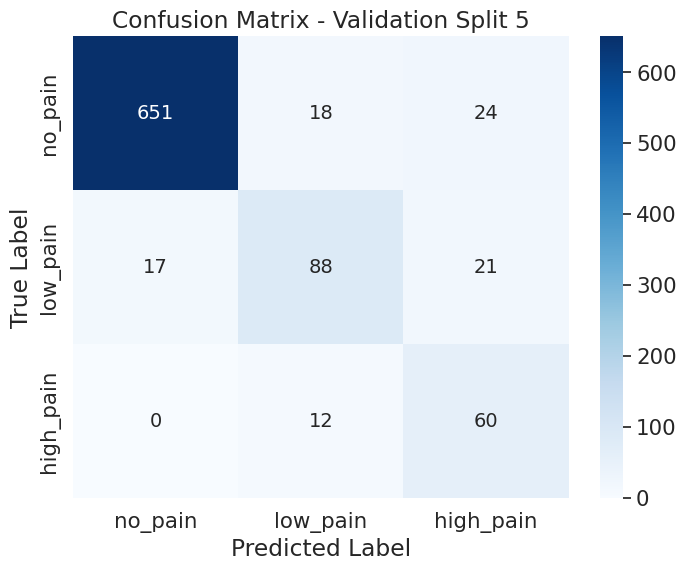

Best score: 0.9304±0.0351
  Experiment (split): window_size_80_stride_10/split_2
  F1 Score: 0.9304±0.0351

Configuration 6/8:
  window_size: 80
  stride: 20
Split 1/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (2810, 80, 94)
  Validation sequences shape: (495, 80, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2315, F1 Score=0.3057 | Val: Loss=1.2895, F1 Score=0.1172
Epoch  50/10000 | Train: Loss=0.6859, F1 Score=0.9217 | Val: Loss=1.0634, F1 Score=0.8222
Epoch 100/10000 | Train: Loss=0.5832, F1 Score=0.9854 | Val: Loss=1.0094, F1 Score=0.8929
Epoch 150/10000 | Train: Loss=0.5744, F1 Score=0.9918 | Val: Loss=1.0024, F1 Score=0.9010
Epoch 200/10000 | Train: Loss=0.5577, F1 Score=0.9996 | Val: Loss=1.0521, F1 Score=0.8909
Early stopping triggered after 208 epochs.
Best model restored from epoch 108 with val_f1 0.9111

Saved confusion matrix plot to: 'models/window_size_80_stride_20/split_0/confusion_matrix_Validation_S

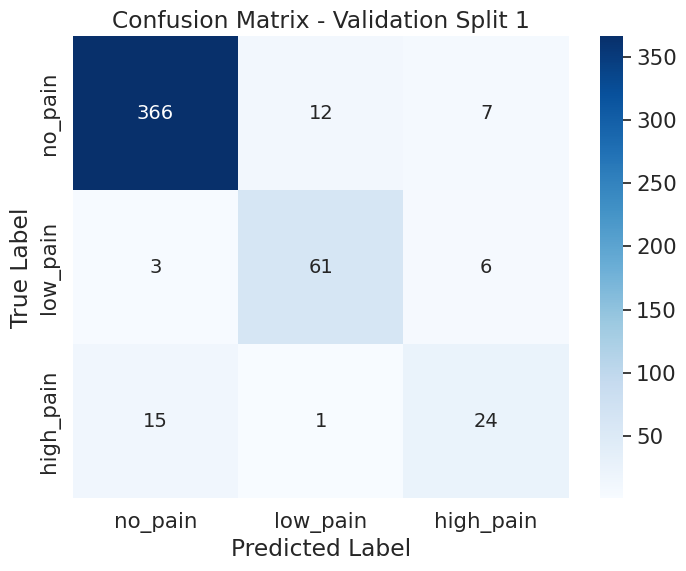

Split 2/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (2810, 80, 94)
  Validation sequences shape: (495, 80, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2191, F1 Score=0.2114 | Val: Loss=1.2642, F1 Score=0.6808
Epoch  50/10000 | Train: Loss=0.7808, F1 Score=0.8505 | Val: Loss=1.0042, F1 Score=0.7293
Epoch 100/10000 | Train: Loss=0.6067, F1 Score=0.9747 | Val: Loss=0.9546, F1 Score=0.9333
Epoch 150/10000 | Train: Loss=0.6076, F1 Score=0.9790 | Val: Loss=0.8655, F1 Score=0.9313
Epoch 200/10000 | Train: Loss=0.5623, F1 Score=0.9972 | Val: Loss=0.8958, F1 Score=0.9333
Early stopping triggered after 216 epochs.
Best model restored from epoch 116 with val_f1 0.9576

Saved confusion matrix plot to: 'models/window_size_80_stride_20/split_1/confusion_matrix_Validation_Split_2.png'


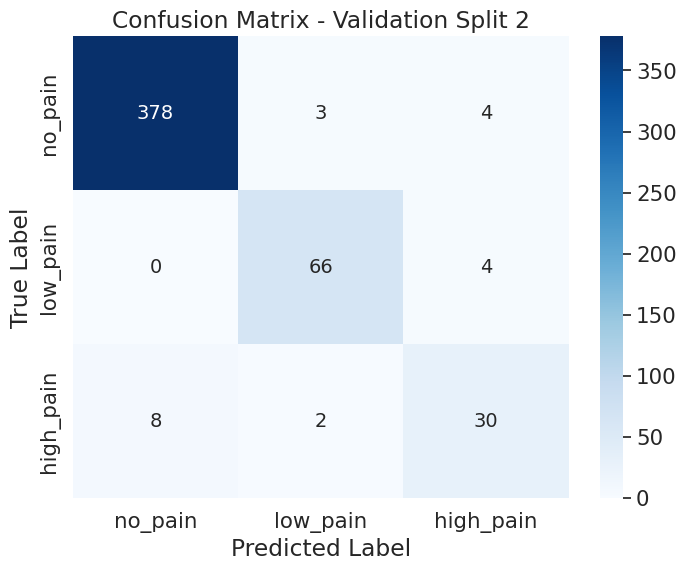

Split 3/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (2810, 80, 94)
  Validation sequences shape: (495, 80, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2371, F1 Score=0.2665 | Val: Loss=1.2769, F1 Score=0.0808
Epoch  50/10000 | Train: Loss=0.7440, F1 Score=0.8875 | Val: Loss=1.0544, F1 Score=0.8566
Epoch 100/10000 | Train: Loss=0.6088, F1 Score=0.9662 | Val: Loss=0.8875, F1 Score=0.9030
Epoch 150/10000 | Train: Loss=0.6033, F1 Score=0.9776 | Val: Loss=0.8835, F1 Score=0.9394
Epoch 200/10000 | Train: Loss=0.5620, F1 Score=0.9989 | Val: Loss=0.8628, F1 Score=0.9515
Epoch 250/10000 | Train: Loss=0.5694, F1 Score=0.9964 | Val: Loss=0.7981, F1 Score=0.9515
Epoch 300/10000 | Train: Loss=0.5568, F1 Score=1.0000 | Val: Loss=0.8311, F1 Score=0.9576
Epoch 350/10000 | Train: Loss=0.6420, F1 Score=0.9438 | Val: Loss=0.9630, F1 Score=0.9212
Epoch 400/10000 | Train: Loss=0.5574, F1 Score=1.0000 | Val: Loss=0.8432, F1 Score=0.955

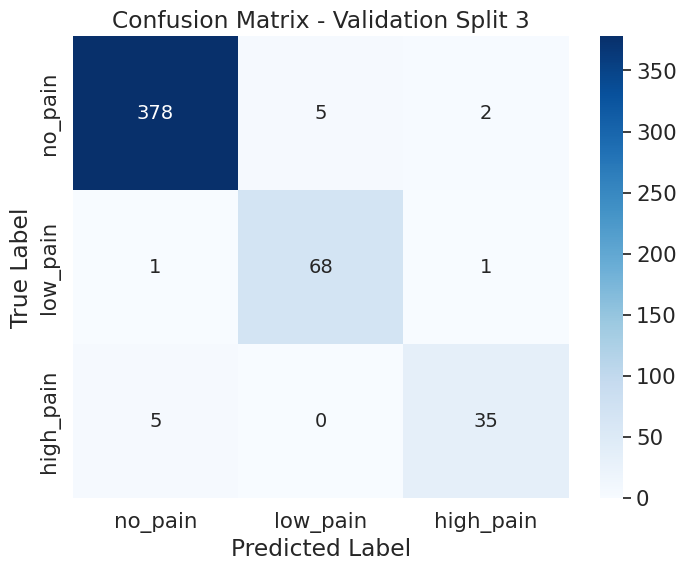

Split 4/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (2810, 80, 94)
  Validation sequences shape: (495, 80, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2323, F1 Score=0.2164 | Val: Loss=1.2467, F1 Score=0.4323
Epoch  50/10000 | Train: Loss=0.7029, F1 Score=0.9285 | Val: Loss=1.1064, F1 Score=0.8283
Epoch 100/10000 | Train: Loss=0.6063, F1 Score=0.9733 | Val: Loss=1.1065, F1 Score=0.8465
Epoch 150/10000 | Train: Loss=0.5731, F1 Score=0.9911 | Val: Loss=1.0332, F1 Score=0.8808
Epoch 200/10000 | Train: Loss=0.5884, F1 Score=0.9900 | Val: Loss=1.0646, F1 Score=0.8727
Epoch 250/10000 | Train: Loss=0.5700, F1 Score=0.9954 | Val: Loss=1.0148, F1 Score=0.8727
Early stopping triggered after 260 epochs.
Best model restored from epoch 160 with val_f1 0.8990

Saved confusion matrix plot to: 'models/window_size_80_stride_20/split_3/confusion_matrix_Validation_Split_4.png'


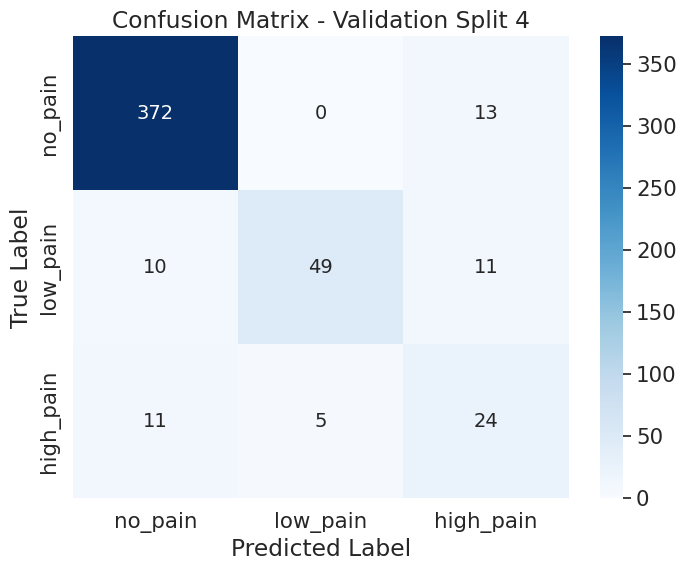

Split 5/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (2810, 80, 94)
  Validation sequences shape: (495, 80, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2376, F1 Score=0.2302 | Val: Loss=1.1862, F1 Score=0.3657
Epoch  50/10000 | Train: Loss=0.7411, F1 Score=0.8815 | Val: Loss=1.1445, F1 Score=0.8242
Epoch 100/10000 | Train: Loss=0.6032, F1 Score=0.9776 | Val: Loss=1.1749, F1 Score=0.8343
Epoch 150/10000 | Train: Loss=0.5984, F1 Score=0.9833 | Val: Loss=1.1006, F1 Score=0.8828
Early stopping triggered after 197 epochs.
Best model restored from epoch 97 with val_f1 0.9051

Saved confusion matrix plot to: 'models/window_size_80_stride_20/split_4/confusion_matrix_Validation_Split_5.png'


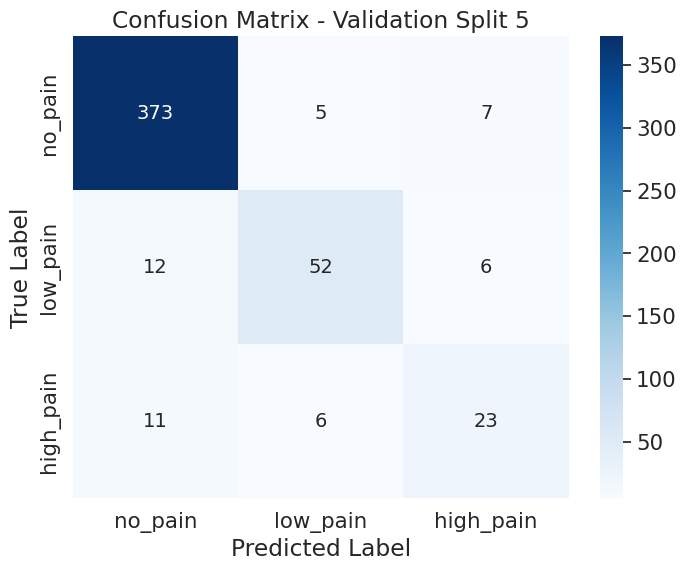

Best score: 0.9289±0.0298
  Experiment (split): window_size_80_stride_20/split_2
  F1 Score: 0.9289±0.0298

Configuration 7/8:
  window_size: 100
  stride: 10
Split 1/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (6182, 100, 94)
  Validation sequences shape: (1089, 100, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.1911, F1 Score=0.4105 | Val: Loss=1.5156, F1 Score=0.3627
Epoch  50/10000 | Train: Loss=0.6280, F1 Score=0.9668 | Val: Loss=1.1225, F1 Score=0.8623
Epoch 100/10000 | Train: Loss=0.5671, F1 Score=0.9951 | Val: Loss=1.1329, F1 Score=0.8935
Epoch 150/10000 | Train: Loss=0.5565, F1 Score=0.9998 | Val: Loss=1.1106, F1 Score=0.9100
Early stopping triggered after 194 epochs.
Best model restored from epoch 94 with val_f1 0.9192

Saved confusion matrix plot to: 'models/window_size_100_stride_10/split_0/confusion_matrix_Validation_Split_1.png'


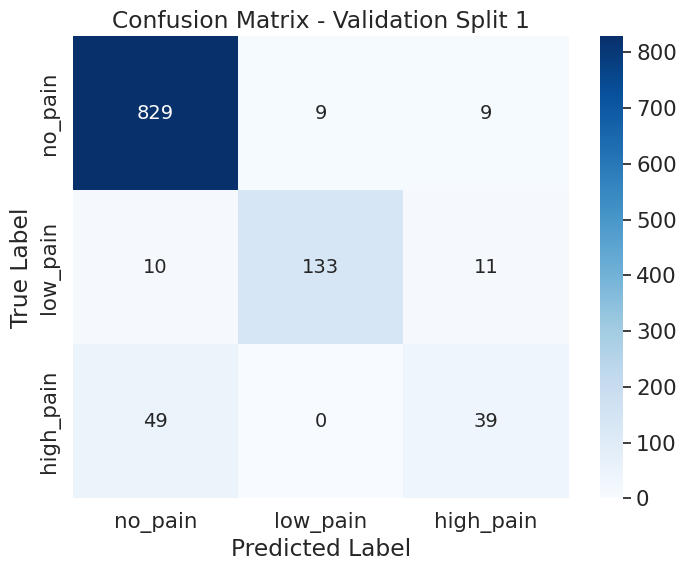

Split 2/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (6182, 100, 94)
  Validation sequences shape: (1089, 100, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2332, F1 Score=0.2667 | Val: Loss=1.2942, F1 Score=0.6437
Epoch  50/10000 | Train: Loss=0.6182, F1 Score=0.9698 | Val: Loss=1.0984, F1 Score=0.9229
Epoch 100/10000 | Train: Loss=0.5839, F1 Score=0.9879 | Val: Loss=1.0455, F1 Score=0.9229
Epoch 150/10000 | Train: Loss=0.5649, F1 Score=0.9958 | Val: Loss=1.0548, F1 Score=0.9210
Early stopping triggered after 172 epochs.
Best model restored from epoch 72 with val_f1 0.9532

Saved confusion matrix plot to: 'models/window_size_100_stride_10/split_1/confusion_matrix_Validation_Split_2.png'


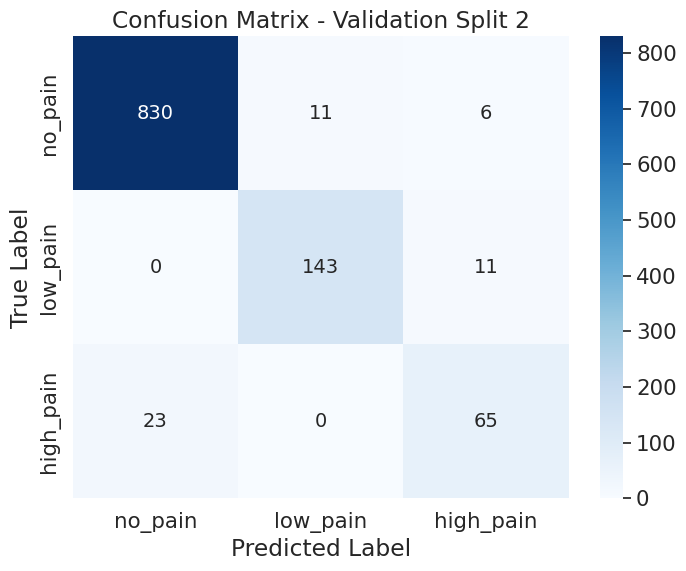

Split 3/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (6182, 100, 94)
  Validation sequences shape: (1089, 100, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.1915, F1 Score=0.4209 | Val: Loss=1.2824, F1 Score=0.7080
Epoch  50/10000 | Train: Loss=0.6087, F1 Score=0.9748 | Val: Loss=0.9248, F1 Score=0.9330
Epoch 100/10000 | Train: Loss=0.5830, F1 Score=0.9911 | Val: Loss=0.9123, F1 Score=0.9541
Epoch 150/10000 | Train: Loss=0.5582, F1 Score=1.0000 | Val: Loss=0.9320, F1 Score=0.9504
Early stopping triggered after 168 epochs.
Best model restored from epoch 68 with val_f1 0.9651

Saved confusion matrix plot to: 'models/window_size_100_stride_10/split_2/confusion_matrix_Validation_Split_3.png'


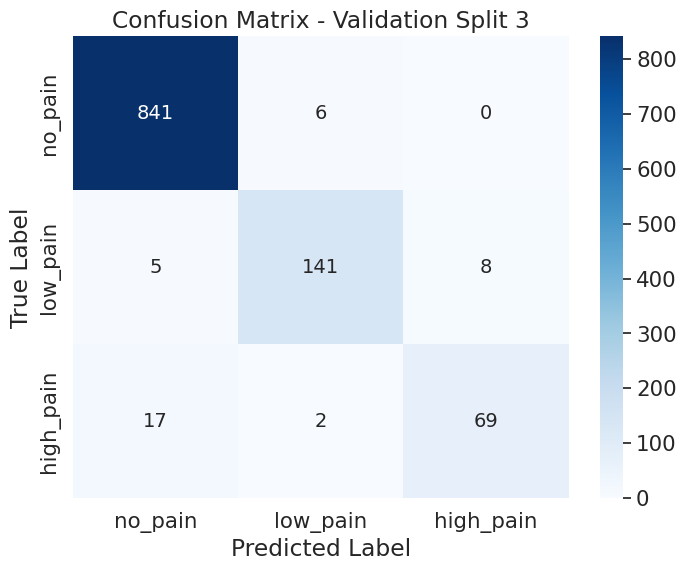

Split 4/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (6182, 100, 94)
  Validation sequences shape: (1089, 100, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2061, F1 Score=0.3921 | Val: Loss=1.3455, F1 Score=0.6731
Epoch  50/10000 | Train: Loss=0.6260, F1 Score=0.9660 | Val: Loss=1.2522, F1 Score=0.8457
Epoch 100/10000 | Train: Loss=0.5797, F1 Score=0.9922 | Val: Loss=1.2585, F1 Score=0.8356
Epoch 150/10000 | Train: Loss=0.5560, F1 Score=1.0000 | Val: Loss=1.2628, F1 Score=0.8577
Epoch 200/10000 | Train: Loss=0.6351, F1 Score=0.9743 | Val: Loss=1.2640, F1 Score=0.8411
Epoch 250/10000 | Train: Loss=0.5666, F1 Score=0.9953 | Val: Loss=1.1738, F1 Score=0.8678
Early stopping triggered after 280 epochs.
Best model restored from epoch 180 with val_f1 0.8999

Saved confusion matrix plot to: 'models/window_size_100_stride_10/split_3/confusion_matrix_Validation_Split_4.png'


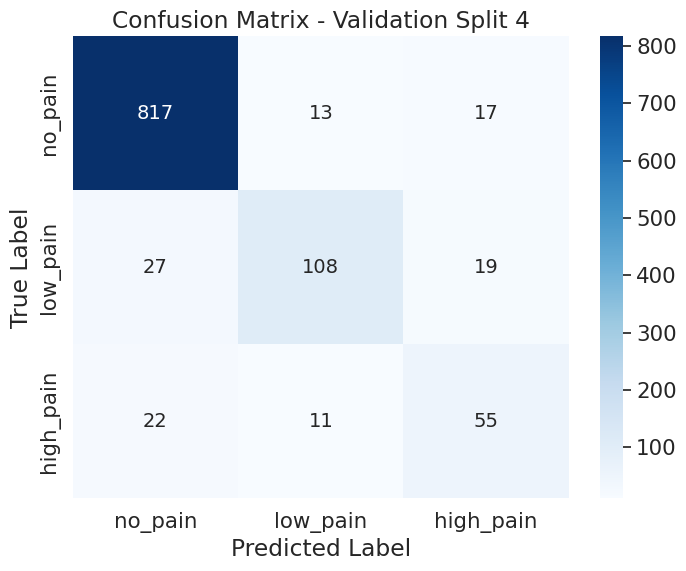

Split 5/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (6182, 100, 94)
  Validation sequences shape: (1089, 100, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2119, F1 Score=0.3471 | Val: Loss=1.2525, F1 Score=0.5317
Epoch  50/10000 | Train: Loss=0.6414, F1 Score=0.9605 | Val: Loss=1.2752, F1 Score=0.8724
Epoch 100/10000 | Train: Loss=0.5909, F1 Score=0.9892 | Val: Loss=1.1842, F1 Score=0.8806
Epoch 150/10000 | Train: Loss=0.5583, F1 Score=0.9989 | Val: Loss=1.1829, F1 Score=0.8898
Epoch 200/10000 | Train: Loss=0.5795, F1 Score=0.9911 | Val: Loss=1.2059, F1 Score=0.8815
Epoch 250/10000 | Train: Loss=0.6473, F1 Score=0.9698 | Val: Loss=1.2431, F1 Score=0.8714
Early stopping triggered after 289 epochs.
Best model restored from epoch 189 with val_f1 0.8990

Saved confusion matrix plot to: 'models/window_size_100_stride_10/split_4/confusion_matrix_Validation_Split_5.png'


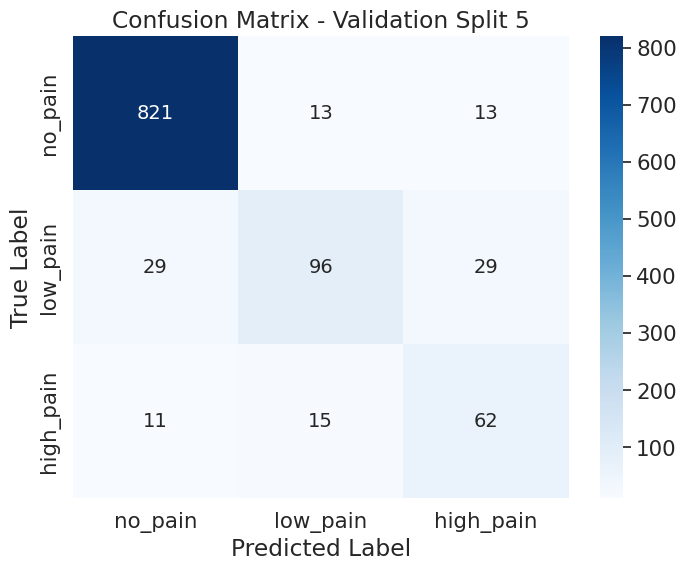

Best score: 0.9273±0.0273
  Experiment (split): window_size_100_stride_10/split_2
  F1 Score: 0.9273±0.0273

Configuration 8/8:
  window_size: 100
  stride: 20
Split 1/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (3372, 100, 94)
  Validation sequences shape: (594, 100, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2259, F1 Score=0.2808 | Val: Loss=1.3033, F1 Score=0.7340
Epoch  50/10000 | Train: Loss=0.6861, F1 Score=0.9374 | Val: Loss=1.1876, F1 Score=0.7929
Epoch 100/10000 | Train: Loss=0.5992, F1 Score=0.9786 | Val: Loss=1.0796, F1 Score=0.8939
Epoch 150/10000 | Train: Loss=0.6088, F1 Score=0.9798 | Val: Loss=1.1176, F1 Score=0.8855
Epoch 200/10000 | Train: Loss=0.5878, F1 Score=0.9852 | Val: Loss=1.0322, F1 Score=0.8822
Epoch 250/10000 | Train: Loss=0.5554, F1 Score=1.0000 | Val: Loss=1.0432, F1 Score=0.9024
Epoch 300/10000 | Train: Loss=0.5563, F1 Score=1.0000 | Val: Loss=1.0228, F1 Score=0.9057
Early stopping t

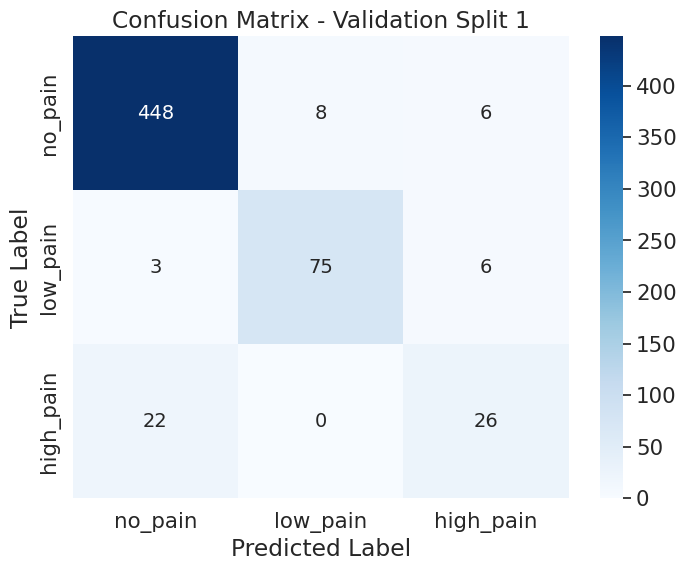

Split 2/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (3372, 100, 94)
  Validation sequences shape: (594, 100, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2194, F1 Score=0.3310 | Val: Loss=1.3292, F1 Score=0.1532
Epoch  50/10000 | Train: Loss=0.7311, F1 Score=0.8882 | Val: Loss=1.0611, F1 Score=0.8754
Epoch 100/10000 | Train: Loss=0.5951, F1 Score=0.9810 | Val: Loss=0.9941, F1 Score=0.9327
Epoch 150/10000 | Train: Loss=0.5890, F1 Score=0.9902 | Val: Loss=0.8997, F1 Score=0.9259
Epoch 200/10000 | Train: Loss=0.6418, F1 Score=0.9600 | Val: Loss=1.0640, F1 Score=0.9091
Epoch 250/10000 | Train: Loss=0.5570, F1 Score=1.0000 | Val: Loss=0.9298, F1 Score=0.9411
Early stopping triggered after 257 epochs.
Best model restored from epoch 157 with val_f1 0.9596

Saved confusion matrix plot to: 'models/window_size_100_stride_20/split_1/confusion_matrix_Validation_Split_2.png'


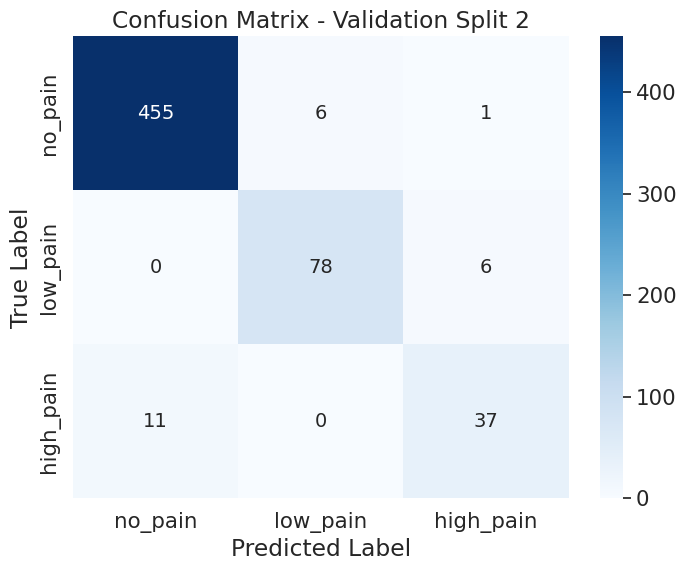

Split 3/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (3372, 100, 94)
  Validation sequences shape: (594, 100, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2310, F1 Score=0.2805 | Val: Loss=1.2325, F1 Score=0.6785
Epoch  50/10000 | Train: Loss=0.7167, F1 Score=0.9054 | Val: Loss=1.0099, F1 Score=0.8384
Epoch 100/10000 | Train: Loss=0.6305, F1 Score=0.9620 | Val: Loss=0.9050, F1 Score=0.9091
Epoch 150/10000 | Train: Loss=0.5828, F1 Score=0.9902 | Val: Loss=0.8738, F1 Score=0.9209
Early stopping triggered after 199 epochs.
Best model restored from epoch 99 with val_f1 0.9512

Saved confusion matrix plot to: 'models/window_size_100_stride_20/split_2/confusion_matrix_Validation_Split_3.png'


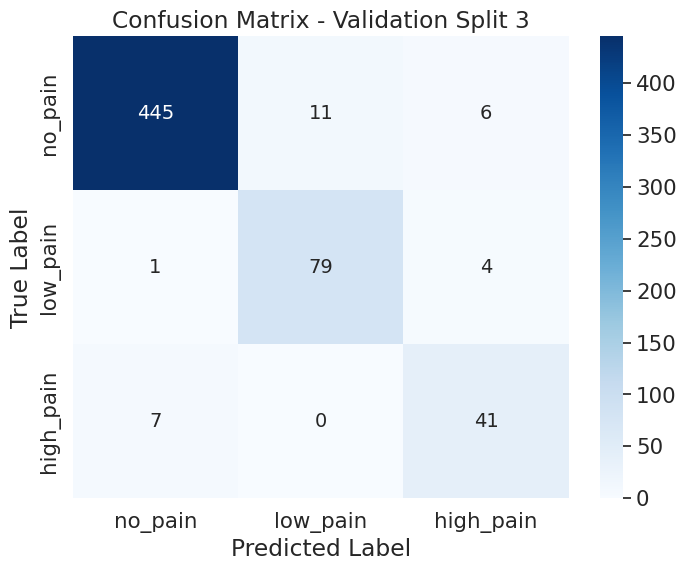

Split 4/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (3372, 100, 94)
  Validation sequences shape: (594, 100, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2210, F1 Score=0.2731 | Val: Loss=1.2382, F1 Score=0.3805
Epoch  50/10000 | Train: Loss=0.7038, F1 Score=0.9282 | Val: Loss=1.1962, F1 Score=0.8620
Epoch 100/10000 | Train: Loss=0.5871, F1 Score=0.9846 | Val: Loss=1.1534, F1 Score=0.8333
Epoch 150/10000 | Train: Loss=0.5724, F1 Score=0.9956 | Val: Loss=1.0545, F1 Score=0.8805
Epoch 200/10000 | Train: Loss=0.5535, F1 Score=1.0000 | Val: Loss=1.0972, F1 Score=0.8670
Epoch 250/10000 | Train: Loss=0.5578, F1 Score=1.0000 | Val: Loss=1.0732, F1 Score=0.8805
Early stopping triggered after 282 epochs.
Best model restored from epoch 182 with val_f1 0.8990

Saved confusion matrix plot to: 'models/window_size_100_stride_20/split_3/confusion_matrix_Validation_Split_4.png'


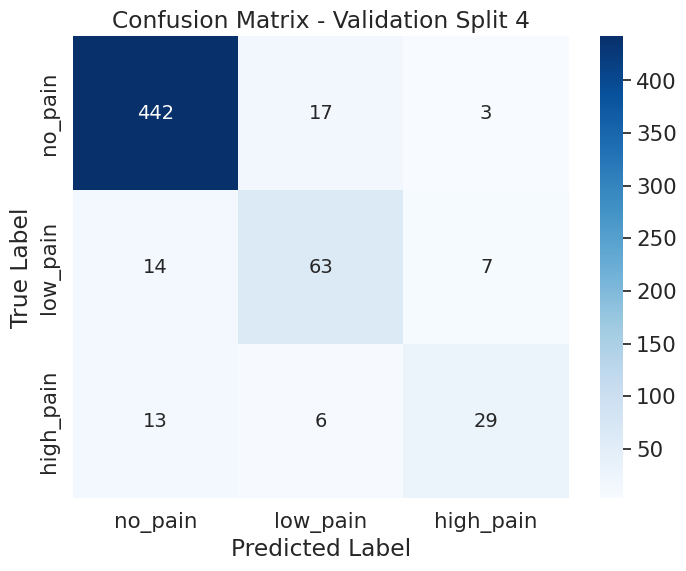

Split 5/5
  Training set shape: (84300, 96)
  Validation set shape: (14850, 96)
  Training sequences shape: (3372, 100, 94)
  Validation sequences shape: (594, 100, 94)
Training 10000 epochs...
Epoch   1/10000 | Train: Loss=1.2282, F1 Score=0.2580 | Val: Loss=1.3720, F1 Score=0.2929
Epoch  50/10000 | Train: Loss=0.7167, F1 Score=0.9122 | Val: Loss=1.2392, F1 Score=0.7963
Epoch 100/10000 | Train: Loss=0.6193, F1 Score=0.9733 | Val: Loss=1.1362, F1 Score=0.8552
Epoch 150/10000 | Train: Loss=0.5919, F1 Score=0.9858 | Val: Loss=1.1142, F1 Score=0.8687
Epoch 200/10000 | Train: Loss=0.5754, F1 Score=0.9932 | Val: Loss=1.1033, F1 Score=0.8788
Early stopping triggered after 230 epochs.
Best model restored from epoch 130 with val_f1 0.9175

Saved confusion matrix plot to: 'models/window_size_100_stride_20/split_4/confusion_matrix_Validation_Split_5.png'


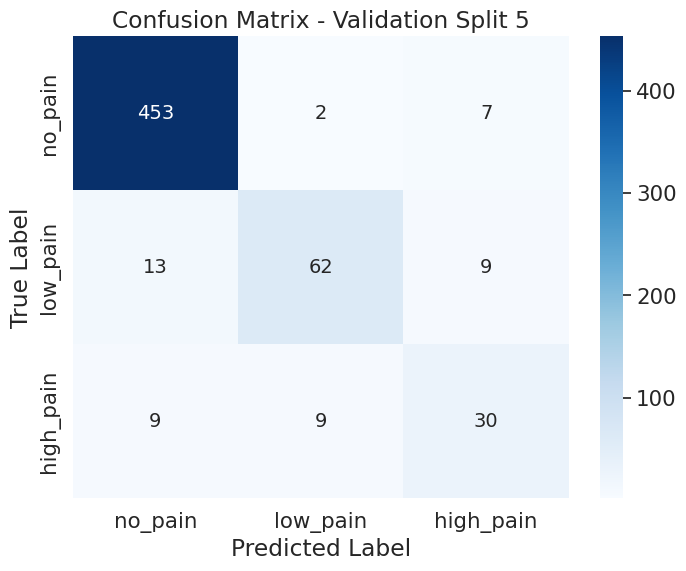

Best score: 0.9303±0.0222
  Experiment (split): window_size_100_stride_20/split_1
  F1 Score: 0.9303±0.0222
CPU times: user 3h 59min 25s, sys: 51min 48s, total: 4h 51min 13s
Wall time: 4h 34min 30s


In [21]:
# @title Run
%%time
# Define parameters to search
param_grid = {
    'window_size': [40, 60, 80, 100],
    'stride': [10, 20]
}

# Fixed hyperparameters (not being tuned)
fixed_params = {
    'hidden_layers': 1,
    'hidden_size': 128,
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'dropout_rate': DROPOUT_RATE,
    'l1_lambda': L1_LAMBDA,
    'l2_lambda': L2_LAMBDA,
    'rnn_type': RNN_TYPE,
    'bidirectional': BIDIRECTIONAL
}

# Cross-validation settings
cv_params = {
    'epochs': EPOCHS,
    'criterion': criterion,
    'device': device,
    'k': K,
    'test_size': VAL_SIZE,
    'patience': PATIENCE,
    'verbose': 50,
    'seed': SEED
}


# Execute search
results, best_config, best_score, best_experiment_name = grid_search_cv_rnn(
    df=df_features,
    df_labels=df_labels,
    param_grid=param_grid,
    fixed_params=fixed_params,
    cv_params=cv_params
)

final_best_params = {**fixed_params, **best_config}
# the actual split with the best results
# -- best_experiment_name = "_".join([f"{k}_{v}" for k, v in best_config.items()])

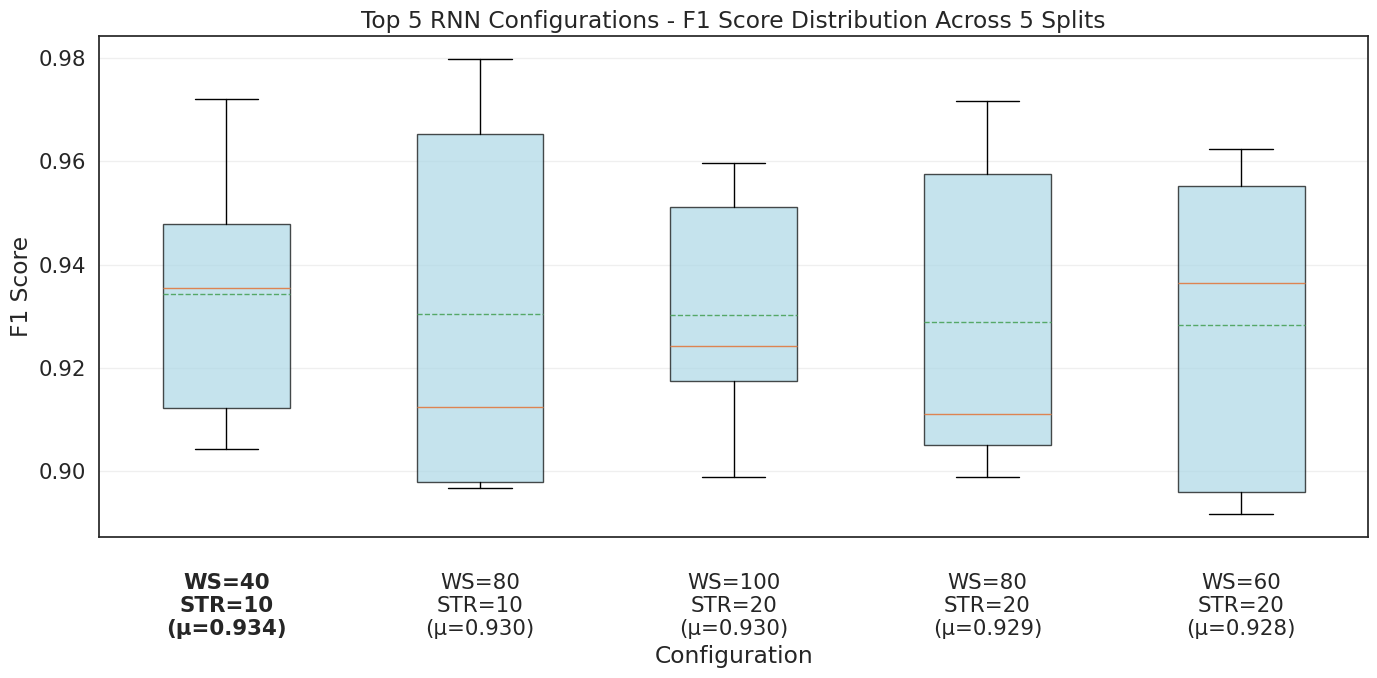

<Figure size 640x480 with 0 Axes>

In [22]:
# @title Plot results
# Visualise results
plot_top_configurations_rnn(results, k_splits=K, top_n=5)

## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [ ]:
# @title Inspect TensorBoard logs
# Copy TensorBoard logs to accessible location for Colab
!rsync -a $current_dir"/"$logs_dir/ "/content/"$logs_dir/

# Launch TensorBoard interface
%tensorboard --logdir "/content/"$logs_dir

## 🔮 **Inference!**

In [90]:
# @title Configuration (if needed to specify)
# Cross-validation
K = 5                    # Number of splits (5 and 10 are considered good values)
VAL_SIZE = 99            # Size or fraction for validation splits

# Training
EPOCHS = 10000           # Maximum epochs (increase to improve performance)
PATIENCE = 100           # Early stopping patience (increase to improve performance)
VERBOSE = 100            # Print frequency

# Optimisation
LEARNING_RATE = 1e-3     # Learning rate
BATCH_SIZE = 32          # Batch size
WINDOW_SIZE = 50         # Input window size
STRIDE = 10               # Input stride

# Architecture
HIDDEN_LAYERS = 2        # Hidden layers
HIDDEN_SIZE = 64         # Neurons per layer
RNN_TYPE = 'LSTM'        # Type of RNN architecture
BIDIRECTIONAL = True     # Bidirectional RNN

# Regularisation
DROPOUT_RATE = 0.2       # Dropout probability
L1_LAMBDA = 0            # L1 penalty
L2_LAMBDA = 1e-4         # L2 penalty

# Loss function
ALPHA = 0.1              # Smoothing applied on the loss (between 0 and 1)
CLASS_WEIGHTS_LIST = [0.43, 2.32, 4.0]
CLASS_WEIGHTS = torch.tensor(CLASS_WEIGHTS_LIST, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=ALPHA, weight=CLASS_WEIGHTS)


final_best_params = {
  'k': K,
  'test_size': VAL_SIZE,
  'epochs': EPOCHS,
  'patience': PATIENCE,
  'verbose': 0,
  'learning_rate': LEARNING_RATE,
  'batch_size': BATCH_SIZE,
  'window_size': WINDOW_SIZE,
  'stride': STRIDE,
  'hidden_layers': HIDDEN_LAYERS,
  'hidden_size': HIDDEN_SIZE,
  'rnn_type': RNN_TYPE,
  'bidirectional': BIDIRECTIONAL,
  'dropout_rate': DROPOUT_RATE,
  'l1_lambda': L1_LAMBDA,
  'l2_lambda': L2_LAMBDA,
  'criterion': criterion,
  'device': device,
  'seed': SEED
}
best_experiment_name = "hidden_layers_2_hidden_size_64/split_2"

## ❗️ **If you want to test directly the `best_experiment_name` model**

In [71]:
# Reload normalization stats used by the specified model
normalization_stats_path = f"models/{best_experiment_name}/normalization_stats.csv"
normalization_stats_df = pd.read_csv(normalization_stats_path)
train_max = normalization_stats_df['train_max'].values[0]
train_min = normalization_stats_df['train_min'].values[0]

In [ ]:
# REQUIRED TO PROCEED:
# - final_best_params         with the whole model configuration
# - best_experiment_name      path to retrieve the model from


# ==============================================================================
#  RELOAD THE BEST MODEL AND ITS STATE
# ==============================================================================
# Rebuild an equivalent model
inference_model = RecurrentClassifier(
        input_size=len(input_features),
        num_classes=len(label_mapping), # (3)
        hidden_size=final_best_params['hidden_size'],
        num_layers=final_best_params['hidden_layers'],
        dropout_rate=final_best_params['dropout_rate'],
        bidirectional=final_best_params['bidirectional'],
        rnn_type=final_best_params['rnn_type']
    ).to(device)

# Reload the weights of the specified model
inference_model_path = f"models/{best_experiment_name}_model.pt"
inference_model.load_state_dict(torch.load(inference_model_path, map_location=device))
print(f"Model loaded successfully from '{best_experiment_name}' as inference model")

# Reload normalization stats used by the specified model
normalization_stats_path = f"models/{best_experiment_name}/normalization_stats.csv"
normalization_stats_df = pd.read_csv(normalization_stats_path, index_col=0)
# Correctly load train_max and train_min as Series
train_max = normalization_stats_df['train_max']
train_min = normalization_stats_df['train_min']



# ==============================================================================
#  INFERENCE
# ==============================================================================
# Normalise features using training set statistics
to_norm_features = [*joint_cols, *joint_vol_cols, *joint_trend_cols]
df_test_inference = df_test.copy()
df_test_inference[to_norm_features] = (df_test_inference[to_norm_features] - train_max) / (train_max - train_min + 1e-8)

# Prepare inputs for testing using the modified build_sequences function
X_test, test_sequence_sample_indices = build_sequences(
    df_features=df_test_inference,
    df_labels=None, # No labels for test data
    window=final_best_params['window_size'],
    stride=final_best_params['stride']
)
test_ds = TensorDataset(torch.from_numpy(X_test))
test_loader = make_loader(test_ds, batch_size=final_best_params['batch_size'], shuffle=False, drop_last=False)
print(f"Test dataset prepared to be fed into '{best_experiment_name}'")

# Start inference
print("Starting inference...")
inference_model.eval()
all_test_preds = []

with torch.no_grad():
    for (inputs,) in test_loader: # Note: (inputs,) because there's no 'y' !!!
        inputs = inputs.to(device)
        inputs = inputs.to(torch.float32)

        logits = inference_model(inputs)
        preds = logits.argmax(dim=1)

        all_test_preds.append(preds.cpu().numpy())

# Concatenate all predictions
all_test_preds = np.concatenate(all_test_preds)
# Create a DataFrame to associate predictions with original sample indices
predictions_df = pd.DataFrame({
    'sample_index': test_sequence_sample_indices,
    'prediction': all_test_preds
})
# Filter the predictions DataFrame to keep only the last prediction for each sample
last_sequence_indices = predictions_df.groupby('sample_index').tail(1).index
last_predictions_df = predictions_df.loc[last_sequence_indices]
# Sort by sample_index to ensure consistent order with original test sample indices
last_predictions_df = last_predictions_df.sort_values(by='sample_index').reset_index(drop=True)



# ==============================================================================
#  SUBMISSION PREPARATION AND DUMP
# ==============================================================================
# Inverse labels mapping from integer encoding to string
inv_label_mapping = {v: k for k, v in label_mapping.items()}
test_predictions_labels = [inv_label_mapping[pred] for pred in last_predictions_df['prediction']]

# Create the submission DataFrame
df_submission = pd.DataFrame({
    'sample_index': last_predictions_df['sample_index'], # Use sample indices from the filtered predictions
    'label': test_predictions_labels
})

# Save submission DataFrame into a CSV file
submission_dir = f'submissions/{best_experiment_name}'
os.makedirs(submission_dir, exist_ok=True)
submission_filename = f'{str(datetime.now())}.csv'
submission_path = os.path.join(submission_dir, submission_filename)
df_submission.to_csv(submission_path, index=False)
print(f"\nSaved submission for {best_experiment_name} into: {submission_path}")

print(f"\nSubmission inspection:")
print(df_submission.shape)
display(df_submission.head())

## ❗️ **Only if you want to retrain a model with the given `final_best_params` and the WHOLE training data**

In [ ]:
# REQUIRED TO PROCEED:
# - final_best_params         with the whole model configuration
# - best_experiment_name      just to name the retrained model after

# ==============================================================================
#  RE-TRAIN WITH WHOLE TRAINING DATASET
# ==============================================================================
df_retrain = df_features.copy()
to_norm_features = [*joint_cols, *joint_vol_cols, *joint_trend_cols]
whole_train_max = df_retrain[to_norm_features].max()
whole_train_min = df_retrain[to_norm_features].min()
df_retrain[to_norm_features] = (df_retrain[to_norm_features] - whole_train_min) / (whole_train_max - whole_train_min + 1e-8)

_, _, _, retrained_model, _ = k_shuffle_split_cross_validation_round_rnn(
    df=df_retrain, df_labels=df_labels,
    epochs=final_best_params['epochs'],
    criterion=final_best_params['criterion'],
    device=final_best_params['device'],
    k=final_best_params['k'],
    test_size=0,
    batch_size=final_best_params['batch_size'],
    hidden_layers=final_best_params['hidden_layers'],
    hidden_size=final_best_params['hidden_size'],
    learning_rate=final_best_params['learning_rate'],
    dropout_rate=final_best_params['dropout_rate'],
    window_size=final_best_params['window_size'], stride=final_best_params['stride'],
    rnn_type=final_best_params['rnn_type'], bidirectional=final_best_params['bidirectional'],
    l1_lambda=final_best_params['l1_lambda'], l2_lambda=final_best_params['l2_lambda'],
    patience=0,
    evaluation_metric="val_f1", mode='max',
    verbose=final_best_params['verbose'],
    seed=final_best_params['seed'],
    experiment_name=f"{best_experiment_name}_retrain"
  )


# ==============================================================================
#  INFERENCE
# ==============================================================================
# Normalise features using training set statistics
to_norm_features = [*joint_cols]
whole_train_max = df_features[to_norm_features].max()
whole_train_min = df_features[to_norm_features].min()
df_test_inference = df_test.copy()
df_test_inference[to_norm_features] = (df_test_inference[to_norm_features] - whole_train_min) / (whole_train_max - whole_train_min + 1e-8)

# Prepare inputs for testing using the modified build_sequences function
X_test, test_sequence_sample_indices = build_sequences(
    df_features=df_test_inference,
    df_labels=None, # No labels for test data
    window=final_best_params['window_size'],
    stride=final_best_params['stride']
)
test_ds = TensorDataset(torch.from_numpy(X_test))
test_loader = make_loader(test_ds, batch_size=final_best_params['batch_size'], shuffle=False, drop_last=False)
print(f"Test dataset prepared to be fed into '{best_experiment_name}'")

# Start inference
print("Starting inference...")
retrained_model.eval()
all_test_preds = []

with torch.no_grad():
    for (inputs,) in test_loader: # Note: (inputs,) because there's no 'y' !!!
        inputs = inputs.to(device)
        inputs = inputs.to(torch.float32)

        logits = retrained_model(inputs)
        preds = logits.argmax(dim=1)

        all_test_preds.append(preds.cpu().numpy())

# Concatenate all predictions
all_test_preds = np.concatenate(all_test_preds)
# Create a DataFrame to associate predictions with original sample indices
predictions_df = pd.DataFrame({
    'sample_index': test_sequence_sample_indices,
    'prediction': all_test_preds
})
# Filter the predictions DataFrame to keep only the last prediction for each sample
last_sequence_indices = predictions_df.groupby('sample_index').tail(1).index
last_predictions_df = predictions_df.loc[last_sequence_indices]
# Sort by sample_index to ensure consistent order with original test sample indices
last_predictions_df = last_predictions_df.sort_values(by='sample_index').reset_index(drop=True)



# ==============================================================================
#  SUBMISSION PREPARATION AND DUMP
# ==============================================================================
# Inverse labels mapping from integer encoding to string
inv_label_mapping = {v: k for k, v in label_mapping.items()}
test_predictions_labels = [inv_label_mapping[pred] for pred in last_predictions_df['prediction']]

# Create the submission DataFrame
df_submission = pd.DataFrame({
    'sample_index': last_predictions_df['sample_index'], # Use sample indices from the filtered predictions
    'label': test_predictions_labels
})

# Save submission DataFrame into a CSV file
submission_dir = f'submissions/{best_experiment_name}'
os.makedirs(submission_dir, exist_ok=True)
submission_filename = f'{str(datetime.now())}.csv'
submission_path = os.path.join(submission_dir, submission_filename)
df_submission.to_csv(submission_path, index=False)
print(f"\nSaved submission for {best_experiment_name} into: {submission_path}")

print(f"\nSubmission inspection:")
print(df_submission.shape)
display(df_submission.head())
